

# Gaussian mixture networks for posterior density estimation

This notebook is about approximate Bayesian computation using Gaussian mixtures. Gaussian mixture densities form a dense set in the space of all density functions under L1 metric. 

In [ ]:
import torch
import torch.nn as nn
import torch.distributions as torch_dist
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

import pyvi.utils.GMMLossFunc as lf
import pyvi.utils.HelperFunc as hf

torch.set_default_dtype(torch.float64)
plt.rcParams['figure.dpi'] = 150


# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Approximating d-dimensional posterior distributions

  We consider the case where the observation model is $$ X \sim \mathcal{N}(\mu, \sigma^2)$$ and both $\mu$ and $\sigma^2$ are unknown. We set the prior 
  
  \begin{align*} \sigma^2 &\sim  \text{Inverse Gamma} (\alpha, \beta) \\ 
  \mu|\sigma^2 &\sim  \mathcal{N}\left(\mu_0, \frac{\sigma^2}{\kappa}\right) \end{align*} 
  
  which is a conjugate prior for $\mathcal{\theta} = (\mu, \sigma^2)$. This will comparison between the approximate density obtained by Gaussian mixture density estimation and the true posterior density. 

#### Posterior distribution

It is easy to show that given independent observations $x_1, x_2, \dots, x_n$ of $X$, the posterior density of $(\mu, \sigma^2)$ is given by: 

\begin{align*}
    &p(\mu, \sigma^2|x_1, \dots, x_n) = p(\mu| \sigma^2;x_1, \dots, x_n) p(\sigma^2|x_1, \dots, x_n), \\
    \text{where } \quad &\mu| \sigma^2;x_1, \dots, x_n \sim \mathcal{N}\left(\mu_*, \frac{\sigma^2}{N+\kappa} \right), \\
      & \sigma^2 |x_1, \dots, x_n \sim \text{Inverse Gamma}\left(\alpha + \frac{1}{2}, \beta_* \right),\\
      & \mu_* = \frac{\kappa}{N + \kappa}\mu_0 + \frac{N}{N + \kappa}\bar{x}, \\
     & \beta_* = \frac{1}{2}\big[N\bar{S} + \kappa \mu_0^2 + 2\beta - (N + \kappa)\mu_*^2 \big],
\end{align*}
and $$\bar{x} = \frac{1}{N}\sum_{i=1}^{N} x_i, \qquad \bar{S} = \frac{1}{N}\sum_{i=1}^{N} x_i^2$$

#### Marginal posterior distributions

* It's clear that the marginal posterior distribution of $\sigma^2$ is $$\sigma^2 |x_1, \dots, x_n \sim \text{Inverse Gamma}\left(\alpha + \frac{N}{2}, \beta_* \right)$$
* It's also easy to show that the marginal posterior distribution of $\mu$ is $$\mu |x_1, \dots, x_n \sim \text{lst}(\mu_*, \tau^2, \nu),$$ where **lst** denotes the *location-scale t-distribution* and $$\tau^2 = \frac{\beta^*}{\alpha + \frac{1}{2}} \text{ and } \nu = 2\alpha + 1$$ denote the scale parameter and the degrees of freedom, respectively.

#### Loss function

$$J(\phi) = \frac{1}{2}\sum_{i=1}^N \left[
L_\phi^T(D_i)\big(\theta_i - \mu_\phi(D_i)\big)\right]^T\left[L_\phi^T(D_i)\big(\theta_i - \mu_\phi(D_i)\big)\right] - \sum_{i=1}^N \sum_{j=1}^d \log\big(L_\phi^{jj}(D_i)\big) +  \frac{N d}{2} \log(2\pi), $$

where $\phi$ is a vector containing the neural net weights and bias, the $x_i \sim \pi(x|\theta_i)$ are observations corresponding to model parameters $\theta_i$, $L_{\phi}(D_i)$ is the lower triangular Cholesky factor of the precision matrix corresponding to observed data $D_i = \{x_1^{(i)}, x_2^{(i)}, \dots, x_n^{(i)} \}$,   $\: \mu_\phi(D_i)$ is the corresponding mean vector, $N$ is the number of training examples and $d$ is the dimension of the posterior distribution.

#### Neural network model

In [2]:
class GMMnD_Model(nn.Module):
    def __init__(self, input_size, posterior_dimension=1, p=0.2):
        super().__init__()
        '''
        define neural network archictecture for computing the mean and Cholesky factor of the
        approximate posterior density of theta. If the posterior is d-dimensional, then the neural net
        has a d * (d + 3) / 2 output space, where the first d entries are for the mean, and the remaining
        d*(d + 1)/2 dimensions are for the Cholesky factor of the precision matrix, with only its non-zero
        elements being calculated
        '''
        d = posterior_dimension
        self.hidden = nn.Sequential(          # hidden layers
            nn.Linear(input_size, 64),
            nn.ELU(),
            nn.Linear(64, 64),
            nn.ELU(),
            nn.Linear(64, 64),
            nn.ELU(),
            nn.Linear(64, 32),
            nn.ELU()
        )
        self.dropout = nn.Dropout(p=p)
        self.mean = nn.Sequential(     # approximate posterior mean
            nn.Linear(32, d)

        )       

        self.cholesky_precision = nn.Sequential(     # Cholesky factor of the precision matrix (log for diagonal entries)
            nn.Linear(32, int(d * (d + 1) / 2))
        )        
    
    def forward(self, x):
        x = x.sort().values
        x = self.hidden(x)
        #x = self.dropout(x)
        theta_mean = self.mean(x)
        theta_precision = self.cholesky_precision(x)
        
        return theta_mean, theta_precision
    

#### Neural network optimizer

In [3]:
def nn_optimizer(model, data_loader, loss_fn, learning_rate = 0.001,
                 K=1, sd_noise = 1e-4, num_epochs=100, echo_after=20, 
                 aggr=None, verbose=True, path=None):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, 
                                 fused=True, weight_decay=1e-3)
    loss_hist = [0] * num_epochs
    
    # optimization loop
    for epoch in range(num_epochs):
        for x_batch, y_batch in data_loader:
            # add Gaussian white noise to the training data for regularization
            x_batch += torch.randn_like(x_batch) * sd_noise
            # if (epoch + 1) % 50 == 0:
            #     x_batch = x_batch.sort(dim=-1).values
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            gmm_mean, gmm_precision = model(x_batch)
            
            loss = loss_fn(y_batch, gmm_mean, gmm_precision)
            # else:
            #     gmm_mean, gmm_precision, gmm_coeffs = model(x_batch)
            
            #     loss = loss_fn(y_batch, gmm_mean, gmm_precision, gmm_coeffs, aggr)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
            loss_hist[epoch] += loss.item() * y_batch.size(0)

        loss_hist[epoch] /= len(data_loader.dataset)

        if (epoch + 1)  % echo_after == 0 and verbose:
            print('Epoch', epoch + 1,  'Loss', loss_hist[epoch], '\n')
        
     # saving the model
    if path:
        torch.save(model, path)
    
    plt.figure(figsize=(8,4))
    plt.plot(np.arange(num_epochs), loss_hist)
    plt.xlabel('epoch')
    plt.ylabel('loss')
        
    return model

##### model training

In [4]:
#Explicitly provided seeds for training process
random_seed = 12345 # recommend to find optimal value for you solution
torch.manual_seed(random_seed)

cuda = torch.cuda.is_available()
if cuda:
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

# sample training data
n = 10                   # sample size
α = 1.0                  # prior mean
β = 1.0                  # prior standard deviation
μ_0 = 0.0                 
κ = 1.0
dim = 2
N = 10000
data_loader = hf.train_gmm_nd(alpha=α, beta=β, mu_0=μ_0, kappa=κ,
                            sample_size=n, N=N, truncated=True,
                            upper=0.9, batch_size=30, num_shuffle=1)


## instantiate DNN model
gmm_nd = GMMnD_Model(input_size=n,
                     posterior_dimension=dim, p=0.3).to(device)
loss_fn = lf.GaussianMixtureLoss(aggr='mean')

# # train DNN model
# gmm_nd = nn_optimizer(model=gmm_nd, 
#                        data_loader=data_loader,
#                        loss_fn=loss_fn,
#                        learning_rate=1e-4, 
#                        sd_noise=1e-4,
#                        num_epochs=200,
#                        verbose=True,
#                        echo_after=10,
#                        path='trained_models/gmm/gaussian_mean_logvariance_truncated_3.pt'
#                       )

gmm_nd = torch.load('trained_models/gmm/gaussian_mean_logvariance_truncated_3.pt')

### 2.3. Testing
#### 2.3.1. Comparision with exact marginals

In [ ]:
### testing on a single example
X, theta = hf.train_gmm_nd(alpha=α, beta=β, mu_0=μ_0, kappa=κ,
                        sample_size=n, N=10, truncated=True,
                        upper=0.9, lower=0.1, test=True)
for i in range(3):
    hf.compare_marginals_gaussian(model=gmm_nd, x=X[i, :], theta=theta[i, :], alpha=α, 
                               beta=β, mu_0=μ_0, kappa=κ, upper=0.9)

#### testing for values of $\sigma^2$ from the tail of the marginal prior

In [6]:
# ### testing on a single example
# X, theta = tails_test_gmm(alpha=α, beta=4.0,
#                                 mu_0=μ_0, kappa=κ,
#                                 prob_right=0.01,
#                                 prob_left=0.99,
#                                 sample_size=n,
#                                 N=10000)
# for i in range(5):
#     compare_marginals_gaussian(model=gmm_nd, x=X[i, :], theta=theta[i, :], alpha=α, beta=β, mu_0=μ_0, kappa=κ)

### approximate posterior correctness check : cdf uniformity test

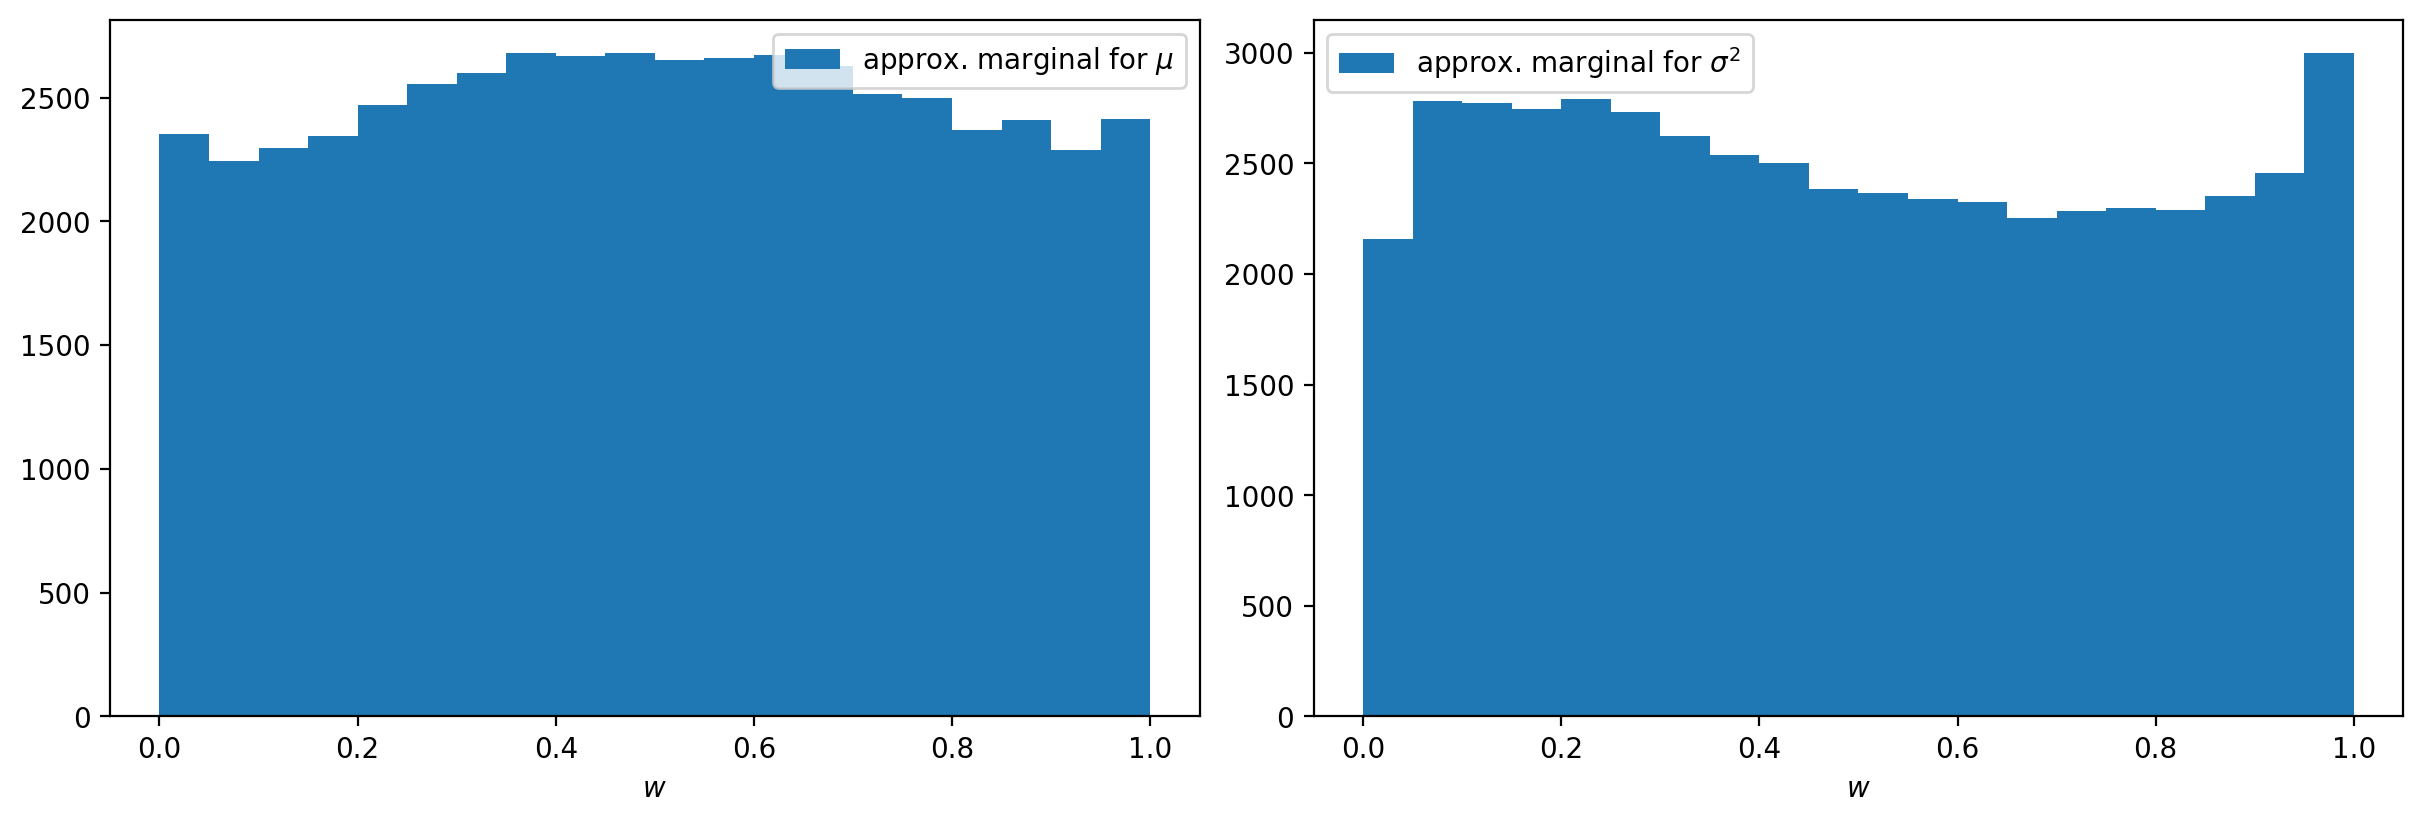

In [7]:
################################################
# sample testing data
################################################
n_test = 50000
# X, theta = tails_test_gmm(alpha=α, beta=3.0,
#                                 mu_0=μ_0, kappa=κ,
#                                 prob_right=0.01,
#                                 prob_left=0.99,
#                                 sample_size=n,
#                                 N=n_test,
#                                 nontails=False)
# n_test = theta.shape[0]
# print('number of tail examples: ', n_test)
X, theta = hf.train_gmm_nd(alpha=α, beta=β, mu_0=μ_0, kappa=κ,
                            sample_size=n, N=n_test, truncated=True,
                            upper=0.9, test=True)


########################################################################################################################
# calculate the mean(s) and Cholesky factor(s) of the GMM using the trained neural net for all testing examples at once
#########################################################################################################################
with torch.no_grad():
    gmm_mean, gmm_cholesky  = gmm_nd(X.to(device))
    
# write Cholesky factor of the precision matrix as a triangular matrix (note that the diagonal elements are on log-scale)
gmm_mean, gmm_cholesky = gmm_mean.cpu(), gmm_cholesky.cpu()

# compute covariance of q_phi from Cholesky factor
gmm_cholesky = lf.to_triangular(gmm_cholesky, dim)
gmm_cholesky = torch.vmap(lf.exp_diagonal)(gmm_cholesky)
gmm_precision = gmm_cholesky @ gmm_cholesky.transpose(1,2)
gmm_covariance = torch.linalg.inv(gmm_precision)

#########################################################
# evaluate the approximate marginal posterior cdf
########################################################
W_mean = torch.zeros(n_test)
W_var = torch.zeros(n_test)

for i in range(n_test):
    # evaluate the respective marginal cdf at the parameter values
    W_mean[i] = hf.mu_cdf_eval(gmm_mean[i,0], gmm_covariance[i, 0, 0], theta[i, 0])
    W_var[i] = hf.var_cdf_eval(gmm_mean[i,1], gmm_covariance[i, 1, 1], theta[i, 1])
    
# compute cdf of w from Uniform distribution
uniform = torch_dist.uniform.Uniform(0.0, 1.0)
F_w_mean = uniform.cdf(W_mean)
F_w_var = uniform.cdf(W_var)

# plotting'
fig = plt.figure(layout='constrained', figsize=(12,4), dpi=200)
fig.add_subplot(121)
plt.hist(W_mean, bins=20,  label=r'approx. marginal for $\mu$')
#plt.plot(W_var, F_w_var, 'k-', lw=.5,  label=r'approx. marginal for $\sigma^2$')
plt.xlabel(r'$w$')
#plt.ylabel(r'$F_w$')
plt.legend()


fig.add_subplot(122)
plt.hist(W_var, bins=20,   label=r'approx. marginal for $\sigma^2$')
#plt.plot(W_var, F_w_var, 'k-', lw=.5,  label=r'approx. marginal for $\sigma^2$')
plt.xlabel(r'$w$')
#plt.ylabel(r'$F_w$')
plt.legend()
plt.show()

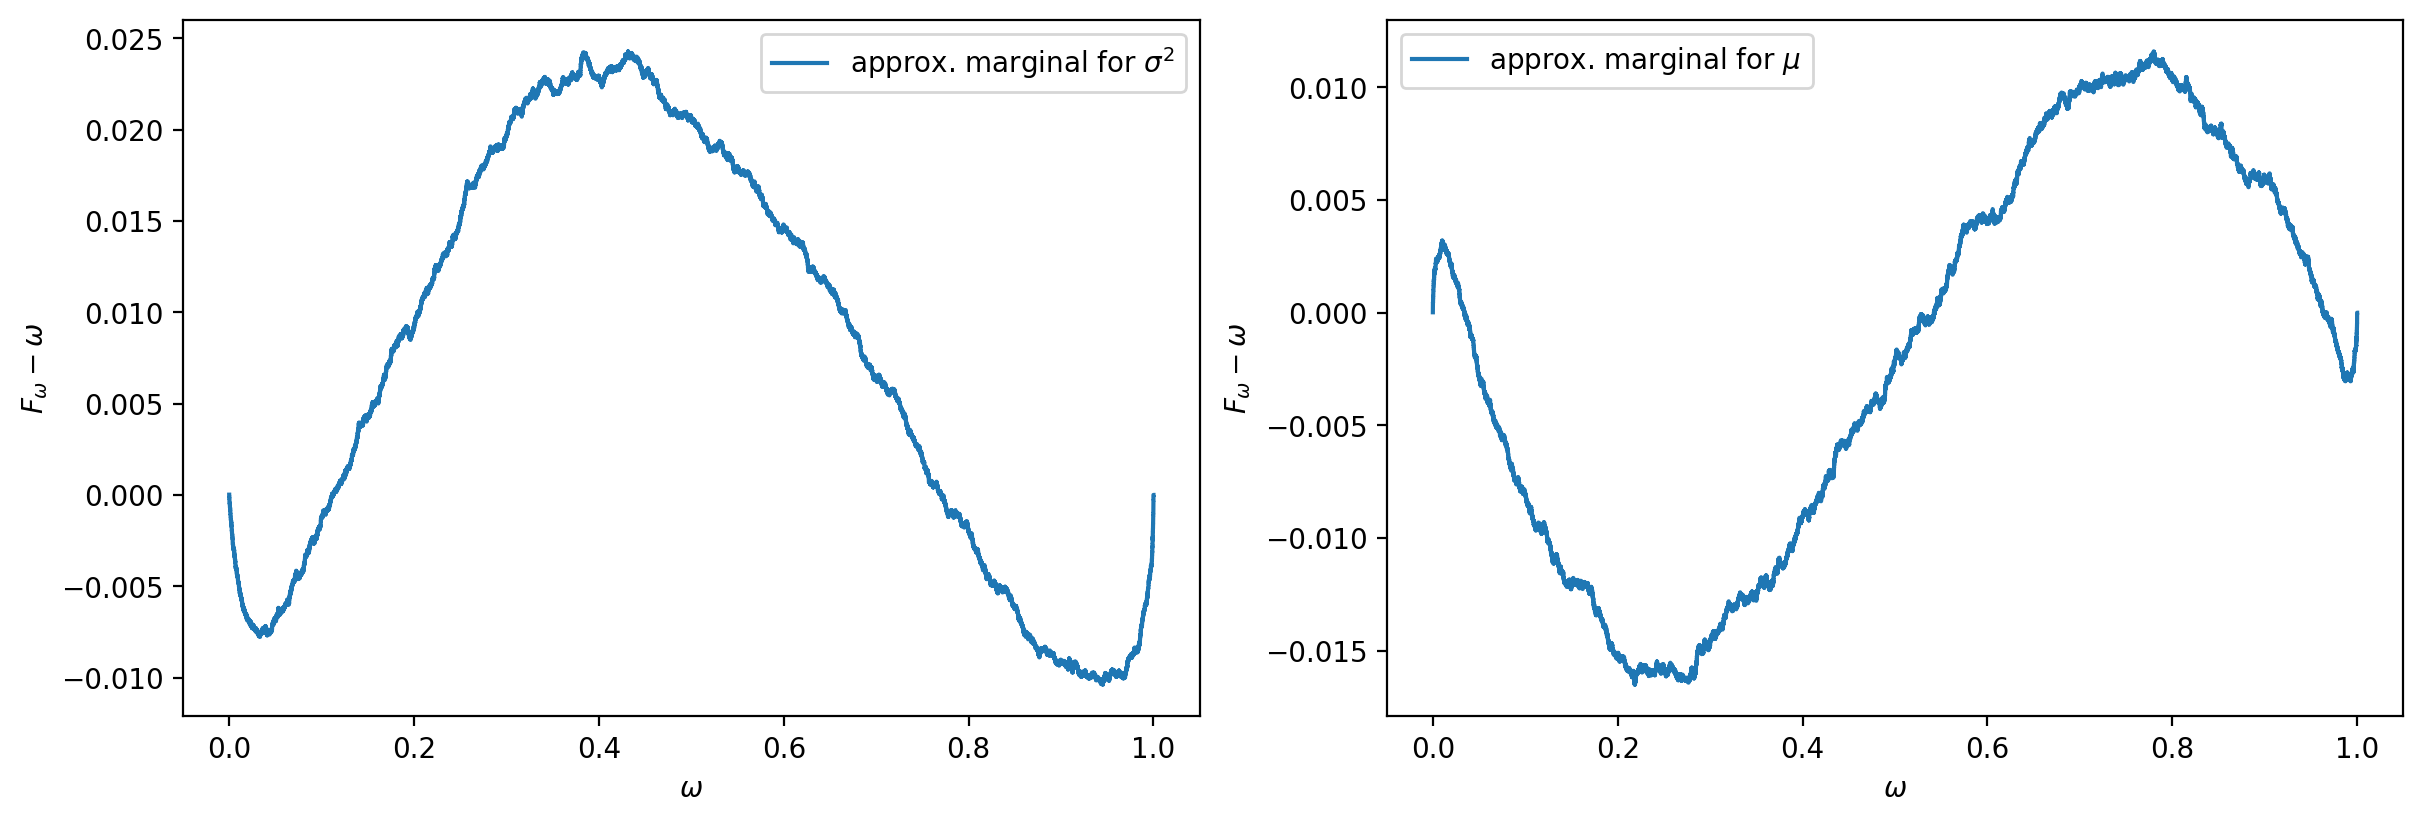

In [9]:
fig = plt.figure(figsize=(12,4), layout='constrained', dpi=200)

data = W_var
# Calculate the empirical cumulative distribution function (ECDF)
sorted_data = np.sort(data)
ecdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

# Plot the ECDF
fig.add_subplot(121)
plt.step(sorted_data, ecdf - sorted_data, label=r'approx. marginal for $\sigma^2$')
plt.xlabel(r'$\omega$')
plt.ylabel(r'$F_{\omega} - \omega$')
plt.legend()


fig.add_subplot(122)
data = W_mean

# Calculate the empirical cumulative distribution function (ECDF)
sorted_data = np.sort(data)
ecdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

# Plot the ECDF
plt.step(sorted_data, ecdf - sorted_data, label=r'approx. marginal for $\mu$')
plt.xlabel(r'$\omega$')
plt.ylabel(r'$F_{\omega} - \omega$')
plt.legend()
plt.show()

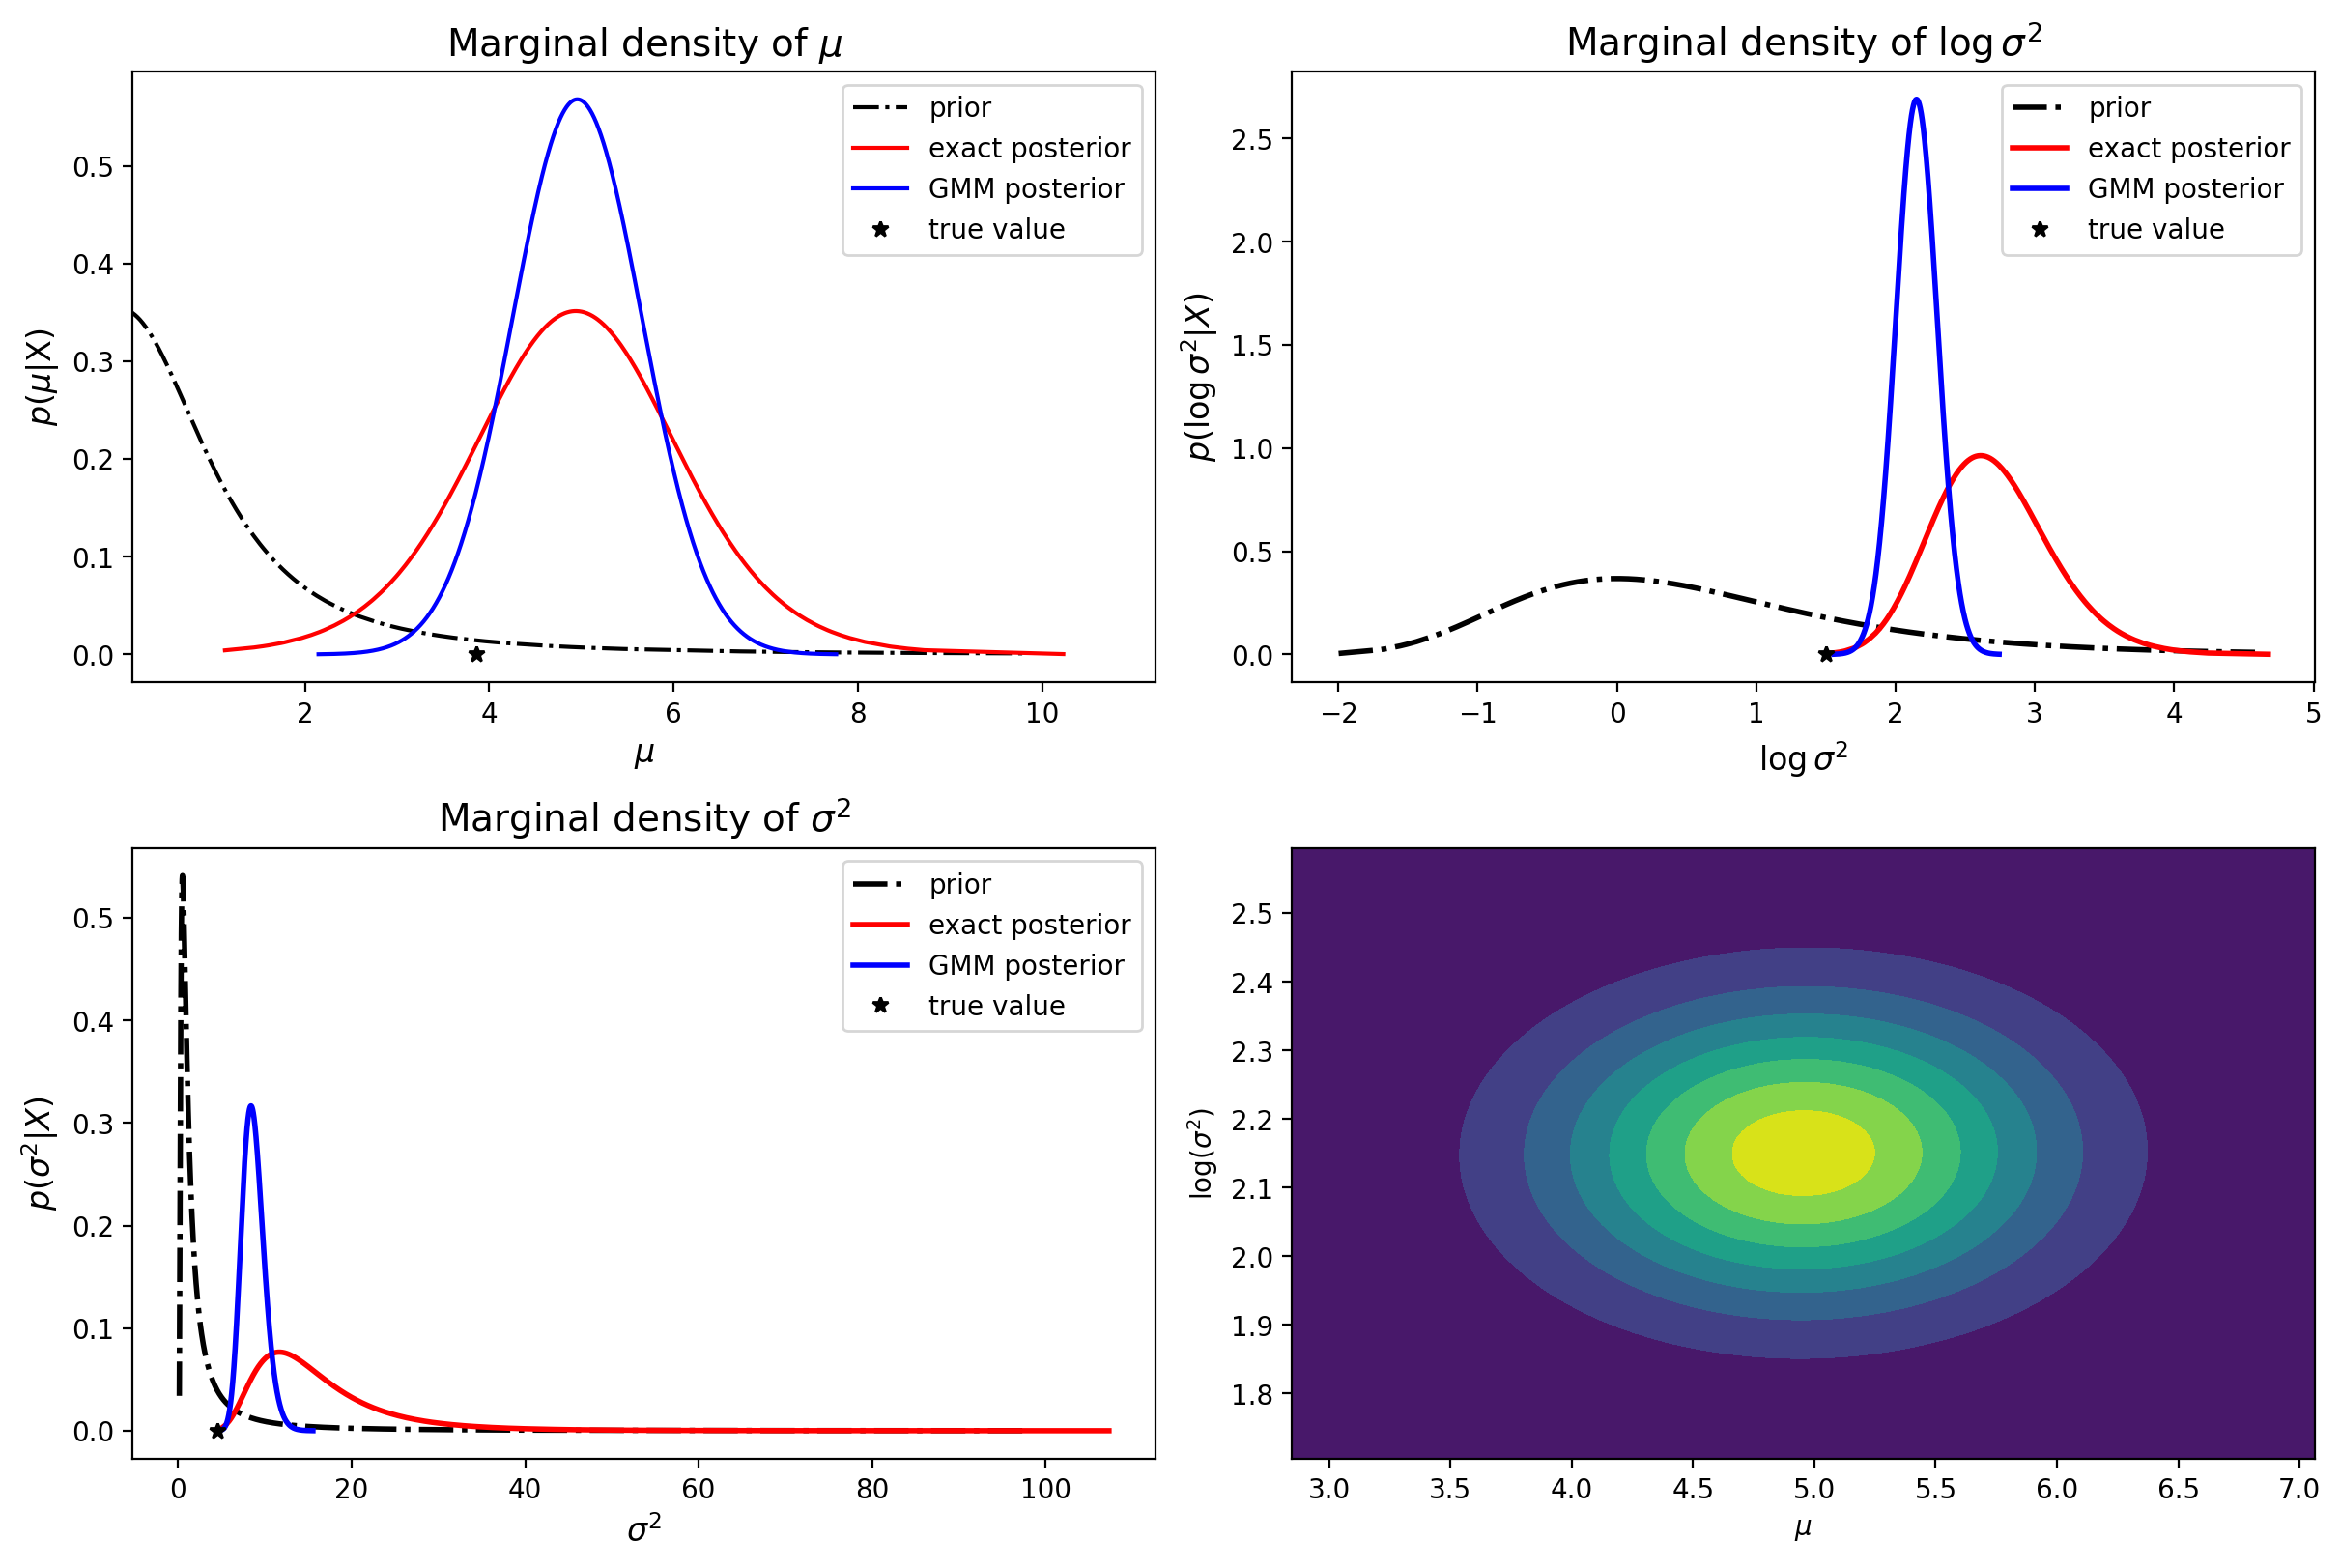

In [8]:
i = W_var.argmin()
x0 = X[i, :]
θ0 = theta[i, :]
gmm_covariance_ = gmm_covariance[i, :, :]
gmm_mean_ = gmm_mean[i, :]

hf.compare_marginals_gaussian(model=gmm_nd, x=X[i, :], theta=theta[i, :], alpha=α,
                            beta=β, mu_0=μ_0, kappa=κ, prior_only=False, posterior_only=False,upper=0.99)



In [60]:
def compare_marginals_gaussian(model, x, theta, alpha, beta, mu_0, kappa,
                                upper=1.0, lower=0.0, num_samples=1000,
                                prior_only=False, posterior_only=False):
    ########################################################
    ###     evaluate approximate joint posterior         ###
    ########################################################
    # calculate mean and covariance params of q_phi
    with torch.no_grad():
        gmm_mean, gmm_cholesky = model(x.to(device))

    gmm_mean, gmm_cholesky = gmm_mean.squeeze().cpu(), gmm_cholesky.squeeze().cpu()

    # compute covariance of q_phi from Cholesky factor
    gmm_cholesky = exp_diagonal(triangular(gmm_cholesky.unsqueeze(0),
                                           d=gmm_mean.shape[0],
                                             upper=False).squeeze())

    gmm_precision = gmm_cholesky @ gmm_cholesky.T
    gmm_covariance = torch.linalg.inv(gmm_precision)              

    #########################################################
    # evaluate the marginal prior densities
    ########################################################
    prior = gaussian_ig_prior(alpha=alpha, beta=beta, mu_0=mu_0, kappa=kappa,
                               upper=upper, lower=lower, num_samples=num_samples)
    data_prior = prior.truncatedprior_sampler()
    data_prior = data_prior.sort(dim=0).values
    
    mu_pdf_prior, sigma_2_pdf_prior = pdf_marginal_priors(alpha=alpha, beta=beta, mu_0=mu_0, kappa=kappa, 
                                                            data_mean=data_prior[:,0],
                                                            data_sigma_2=data_prior[:,1])
    
    #########################################################
    # evaluate the exact marginal posterior densities
    ########################################################
    data_pdf_exact = pdf_marginal_posteriors(alpha=alpha, beta=beta, mu_0=mu_0, kappa=kappa,
                                                               X=x)
    
    #########################################################
    # evaluate the approximate marginal posterior densities
    ########################################################
    mu_vals = data_pdf_exact['mean']['samples']
    sigma_2_vals = data_pdf_exact['sigma2']['samples']
    logsigma_2_vals = torch.log(data_pdf_exact['sigma2']['samples'])
    
    
    mu_gmm = torch_dist.normal.Normal(gmm_mean[0], torch.sqrt(gmm_covariance[0,0]))
    mu_pdf_gmm = torch.exp(mu_gmm.log_prob(mu_vals))

    #  use the change of variable formula to evaluate the approximate pdf of σ^2 from that of log(σ^2)
    logvar_gmm = torch_dist.normal.Normal(gmm_mean[1], torch.sqrt(gmm_covariance[1,1]))
    sigma_2_pdf_gmm = torch.exp(logvar_gmm.log_prob(torch.log(sigma_2_vals))) / sigma_2_vals 
    logsigma_2_pdf_gmm = torch.exp(logvar_gmm.log_prob(torch.log(sigma_2_vals))) 

    #####################################
    #  plotting
    #####################################
    fig = plt.figure(layout='constrained', figsize=(12,6), dpi=200)

    if prior_only == False:
        if posterior_only == False:
            # μ
            fig.add_subplot(221)
            plt.plot(data_prior[:,0], mu_pdf_prior, 'k-.', lw=1.5, label='prior')
            plt.plot(data_pdf_exact['mean']['samples'], data_pdf_exact['mean']['pdf_samples'], 
                     'r-', lw=1.5, label='exact posterior')
            plt.plot(mu_vals, mu_pdf_gmm, 'b-', lw=1.5, label='GMM posterior')
            plt.plot(theta[0], torch.zeros(1), 'k*',  lw=5, label='true value')
            plt.xlim(data_pdf_exact['mean']['samples'].min()-1,
                      data_pdf_exact['mean']['samples'].max()+1)
            plt.xlabel(r'$\mu$', fontsize=12)
            plt.ylabel(r'$p(\mu$|X)', fontsize=12)
            plt.title('Marginal density of $\mu$', fontsize=14)
            plt.legend(fontsize=10)

            # log(σ^2)
            fig.add_subplot(222)
            plt.plot(torch.log(data_prior[:,1]), sigma_2_pdf_prior * data_prior[:,1], 'k-.', lw=2, label='prior')
            plt.plot(torch.log(data_pdf_exact['sigma2']['samples']),
                      data_pdf_exact['sigma2']['pdf_samples'] * data_pdf_exact['sigma2']['samples'],
                      'r-', lw=2, label='exact posterior')
            plt.plot(torch.log(sigma_2_vals), logsigma_2_pdf_gmm, 'b-', lw=2, label='GMM posterior')
            plt.plot(theta[1], torch.zeros(1), 'k*',  lw=5, label='true value')
            plt.xlabel(r'$\log\sigma^2$', fontsize=12)
            plt.ylabel(r'$p(\log\sigma^2|X)$', fontsize=12)
            plt.title('Marginal density of $\log\sigma^2$', fontsize=14)
            plt.legend(fontsize=10)

            # σ^2
            fig.add_subplot(223)
            plt.plot(data_prior[:,1], sigma_2_pdf_prior, 'k-.', lw=2, label='prior')
            plt.plot(data_pdf_exact['sigma2']['samples'],
                      data_pdf_exact['sigma2']['pdf_samples'], 'r-', lw=2, label='exact posterior')
            plt.plot(sigma_2_vals, sigma_2_pdf_gmm, 'b-', lw=2, label='GMM posterior')
            plt.plot(torch.exp(theta[1]), torch.zeros(1), 'k*',  lw=5, label='true value')
            #plt.xlim(right=alpha_star)
            plt.xlabel(r'$\sigma^2$', fontsize=12)
            plt.ylabel(r'$p(\sigma^2|X)$', fontsize=12)
            plt.title('Marginal density of $\sigma^2$', fontsize=14)
            plt.legend(fontsize=10)
        
        else:
             # μ
            fig.add_subplot(221)
            plt.plot(data_pdf_exact['mu']['samples'],
                      data_pdf_exact['mu']['pdf_samples'], 'r-', lw=1.5, label='exact posterior')
            plt.plot(mu_vals, mu_pdf_gmm, 'b-', lw=1.5, label='GMM posterior')
            plt.plot(theta[0], torch.zeros(1), 'k*',  lw=5, label='true value')
            plt.xlabel(r'$\mu$', fontsize=12)
            plt.ylabel(r'$p(\mu$|X)', fontsize=12)
            plt.title('Marginal density of $\mu$', fontsize=14)
            plt.legend(fontsize=10)

            # log(σ^2)
            fig.add_subplot(222)
            plt.plot(torch.log(data_pdf_exact['sigma2']['samples']),
                      data_pdf_exact['sigma2']['pdf_samples'] * data_pdf_exact['sigma2']['samples'],
                        'r-', lw=2, label='exact posterior')
            plt.plot(torch.log(sigma_2_vals), logsigma_2_pdf_gmm, 'b-', lw=2, label='GMM posterior')
            plt.plot(theta[1], torch.zeros(1), 'k*',  lw=5, label='true value')
            plt.xlabel(r'$\log\sigma^2$', fontsize=12)
            plt.ylabel(r'$p(\log\sigma^2|X)$', fontsize=12)
            plt.title('Marginal density of $\log\sigma^2$', fontsize=14)
            plt.legend(fontsize=10)

            # σ^2
            fig.add_subplot(223)
            plt.plot(data_pdf_exact['sigma2']['samples'], data_pdf_exact['sigma2']['pdf_samples'], 'r-', lw=2, label='exact posterior')
            plt.plot(sigma_2_vals, sigma_2_pdf_gmm, 'b-', lw=2, label='GMM posterior')
            plt.plot(torch.exp(theta[1]), torch.zeros(1), 'k*',  lw=5, label='true value')
            #plt.xlim(right=alpha_star)
            plt.xlabel(r'$\sigma^2$', fontsize=12)
            plt.ylabel(r'$p(\sigma^2|X)$', fontsize=12)
            plt.title('Marginal density of $\sigma^2$', fontsize=14)
            plt.legend(fontsize=10)
    
    else:
        # μ
        fig.add_subplot(221)
        plt.plot(data_prior[:,0], mu_pdf_prior, 'k-.', lw=1.5, label='prior')
        plt.plot(theta[0], torch.zeros(1), 'k*',  lw=5, label='true value')
        plt.xlabel(r'$\mu$', fontsize=12)
        plt.ylabel(r'$p(\mu$|X)', fontsize=12)
        plt.title('Marginal density of $\mu$', fontsize=14)
        plt.legend(fontsize=10)

        # log(σ^2)
        fig.add_subplot(222)
        plt.plot(torch.log(data_prior[:,1]), sigma_2_pdf_prior * data_prior[:,1], 'k-.', lw=2, label='prior')
        plt.plot(theta[1], torch.zeros(1), 'k*',  lw=5, label='true value')
        plt.xlabel(r'$\log\sigma^2$', fontsize=12)
        plt.ylabel(r'$p(\log\sigma^2|X)$', fontsize=12)
        plt.title('Marginal density of $\log\sigma^2$', fontsize=14)
        plt.legend(fontsize=10)

        # σ^2
        fig.add_subplot(223)
        plt.plot(data_prior[:,1], sigma_2_pdf_prior, 'k-.', lw=2, label='prior')
        plt.plot(torch.exp(theta[1]), torch.zeros(1), 'k*',  lw=5, label='true value')
        plt.xlabel(r'$\sigma^2$', fontsize=12)
        plt.ylabel(r'$p(\sigma^2|X)$', fontsize=12)
        plt.title('Marginal density of $\sigma^2$', fontsize=14)
        plt.legend(fontsize=10)

    fig.add_subplot(224)
    labels = ['$\mu$', '$\log(\sigma^2)$']
    z = gauss2d(gmm_mean, gmm_covariance, True, labels)

    plt.show()


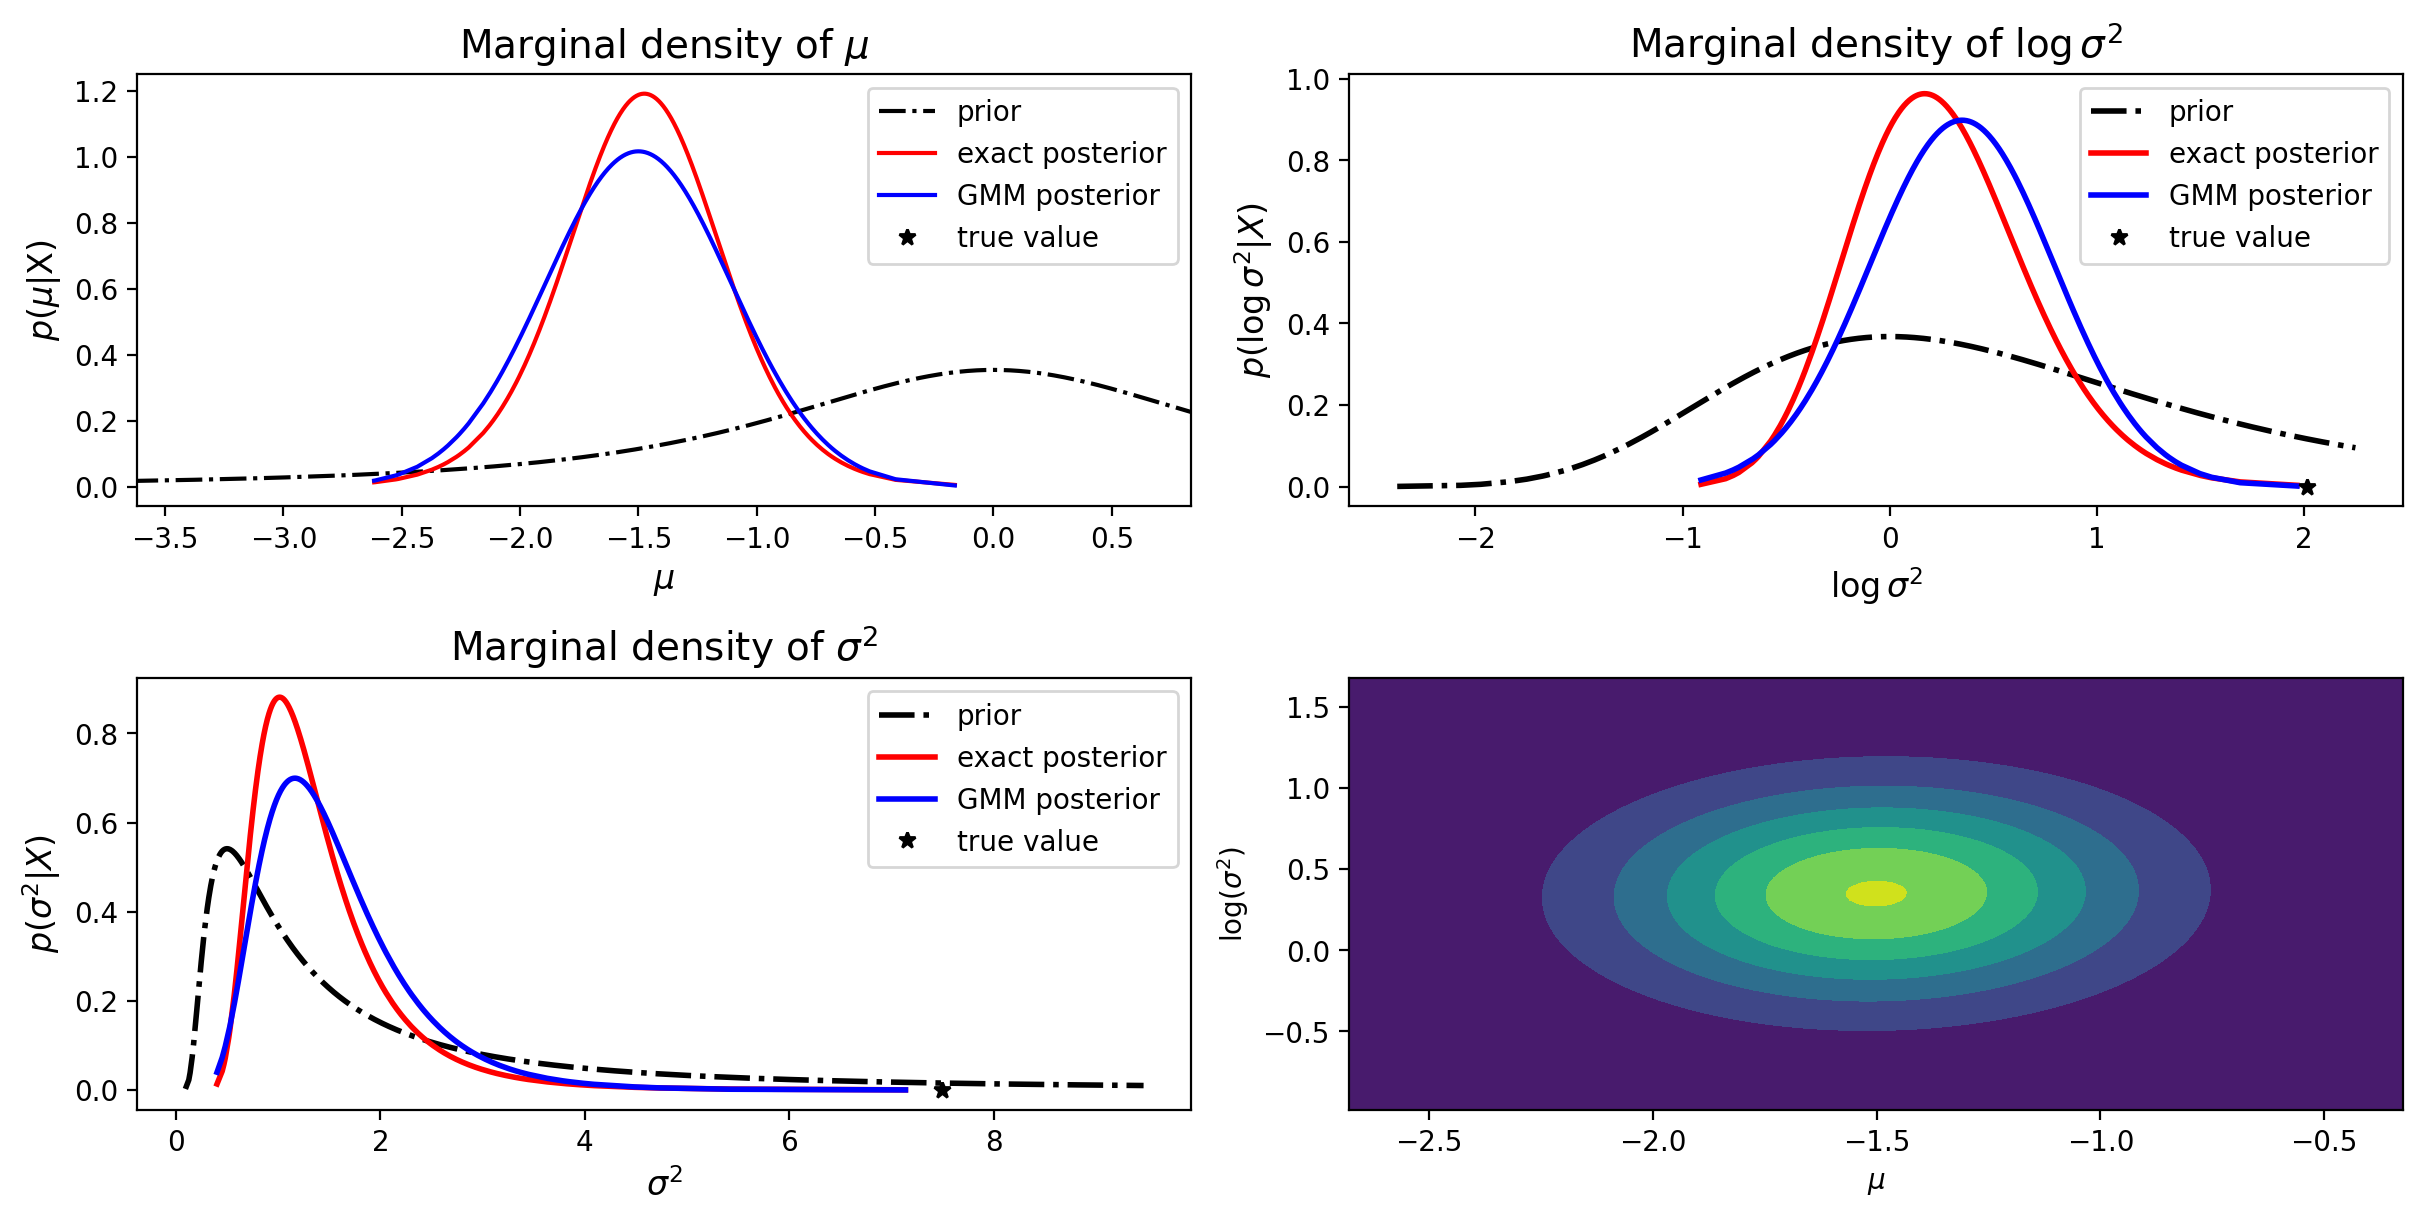

In [61]:
i = W_mean.argmin()
x0 = X[i, :]
θ0 = theta[i, :]
gmm_covariance_ = gmm_covariance[i, :, :]
gmm_mean_ = gmm_mean[i, :]

compare_marginals_gaussian(model=gmm_nd, x=X[i, :], theta=theta[i, :], alpha=α, beta=β, mu_0=μ_0, kappa=κ,
                            prior_only=False, posterior_only=False, upper=0.9)



**Sample variance**

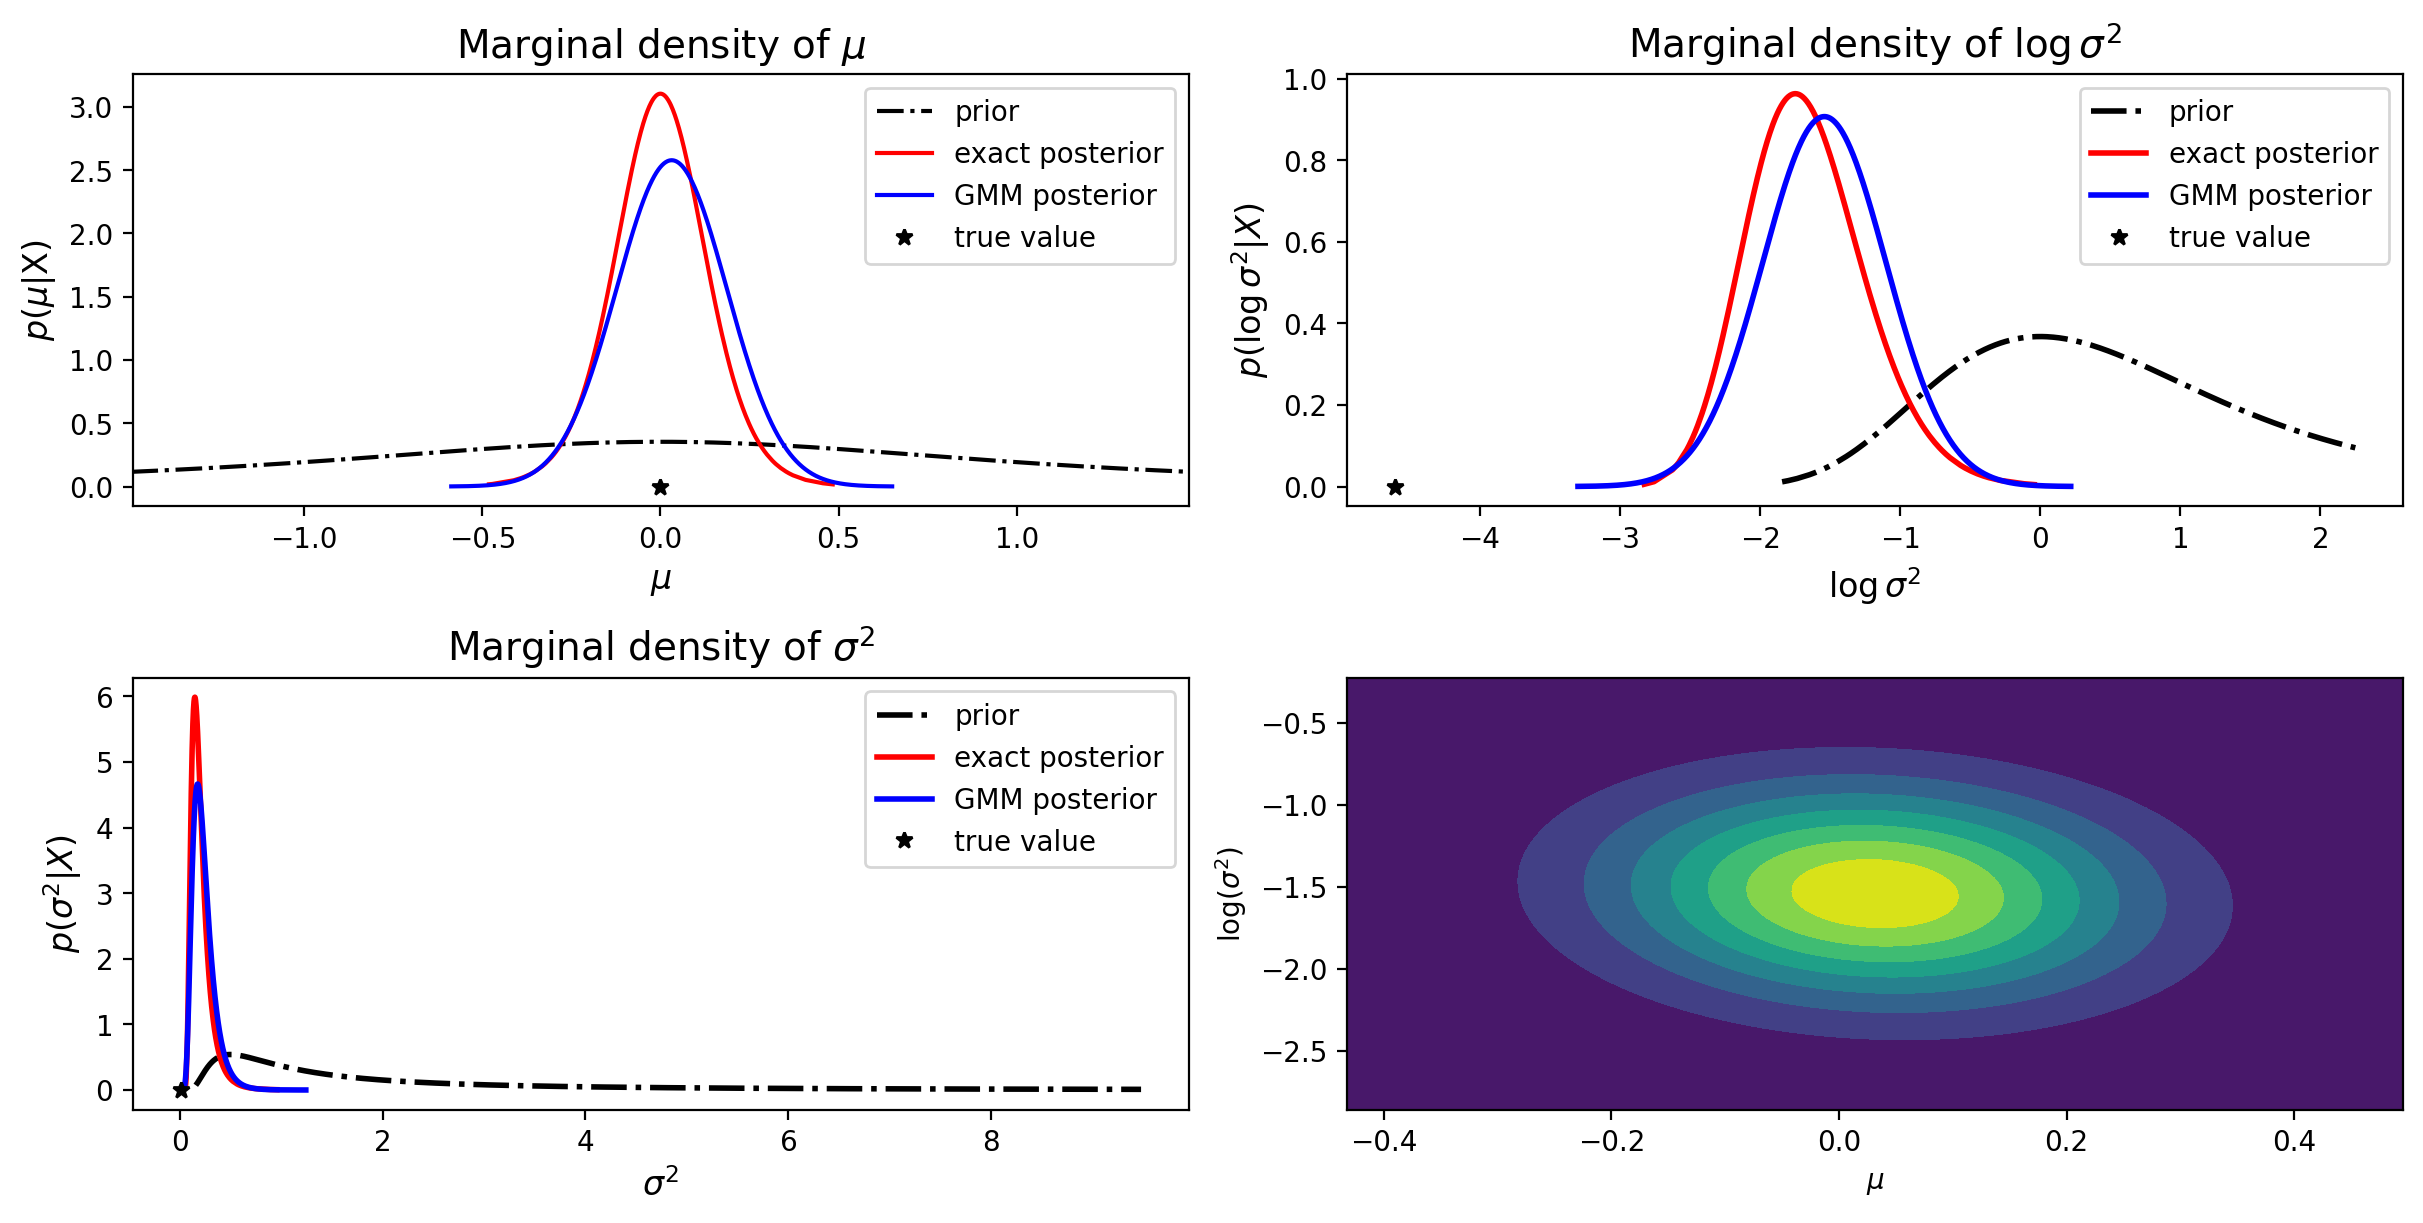

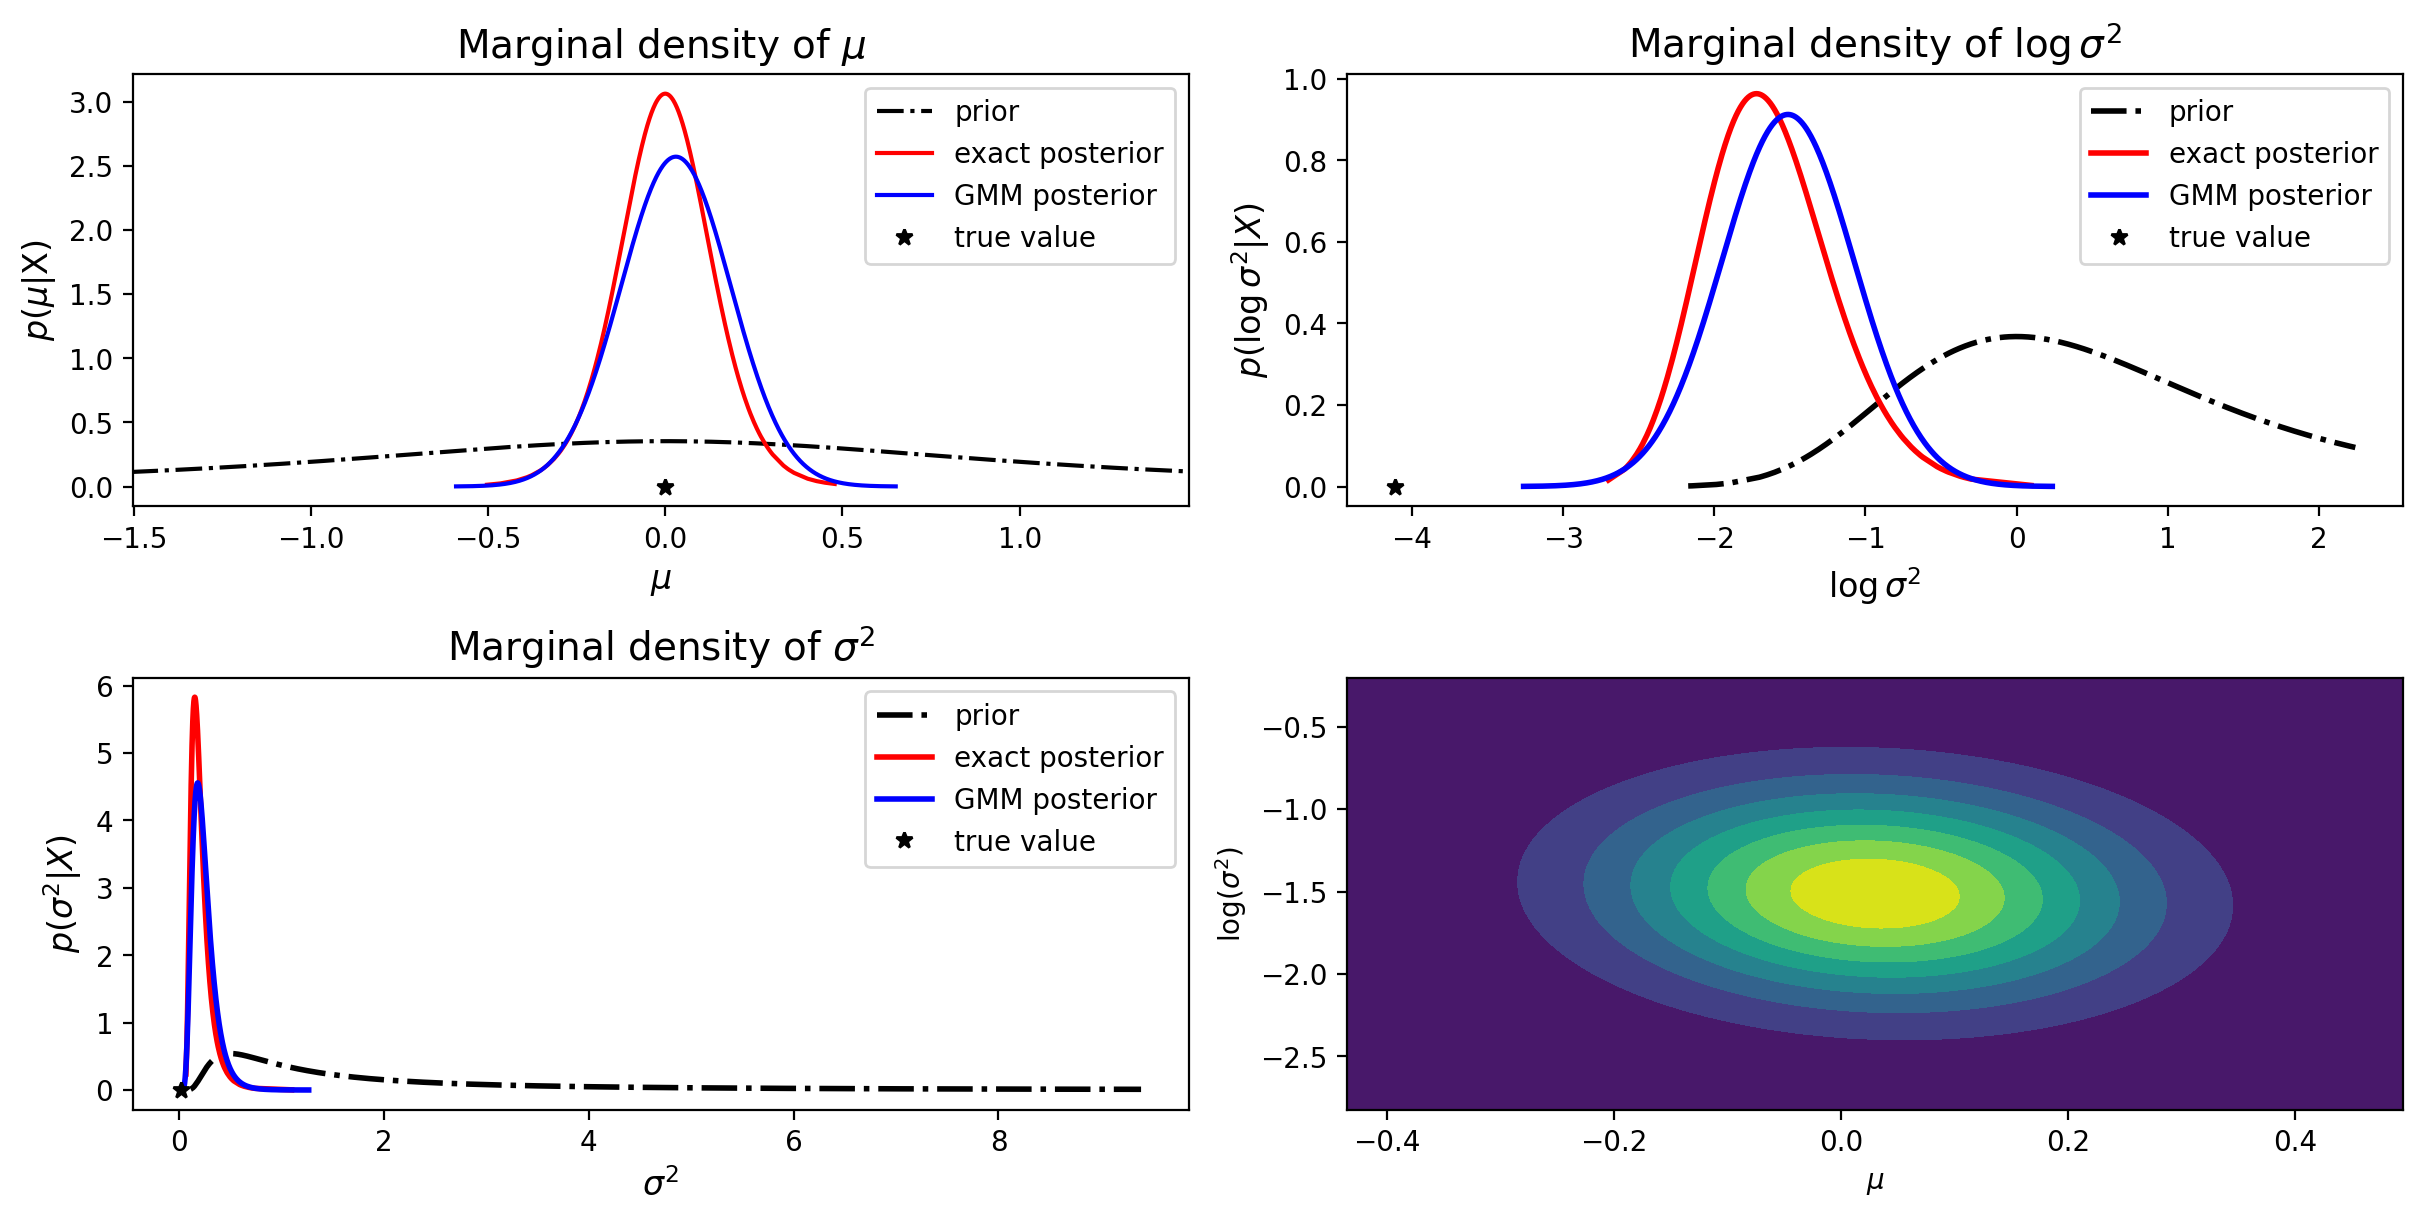

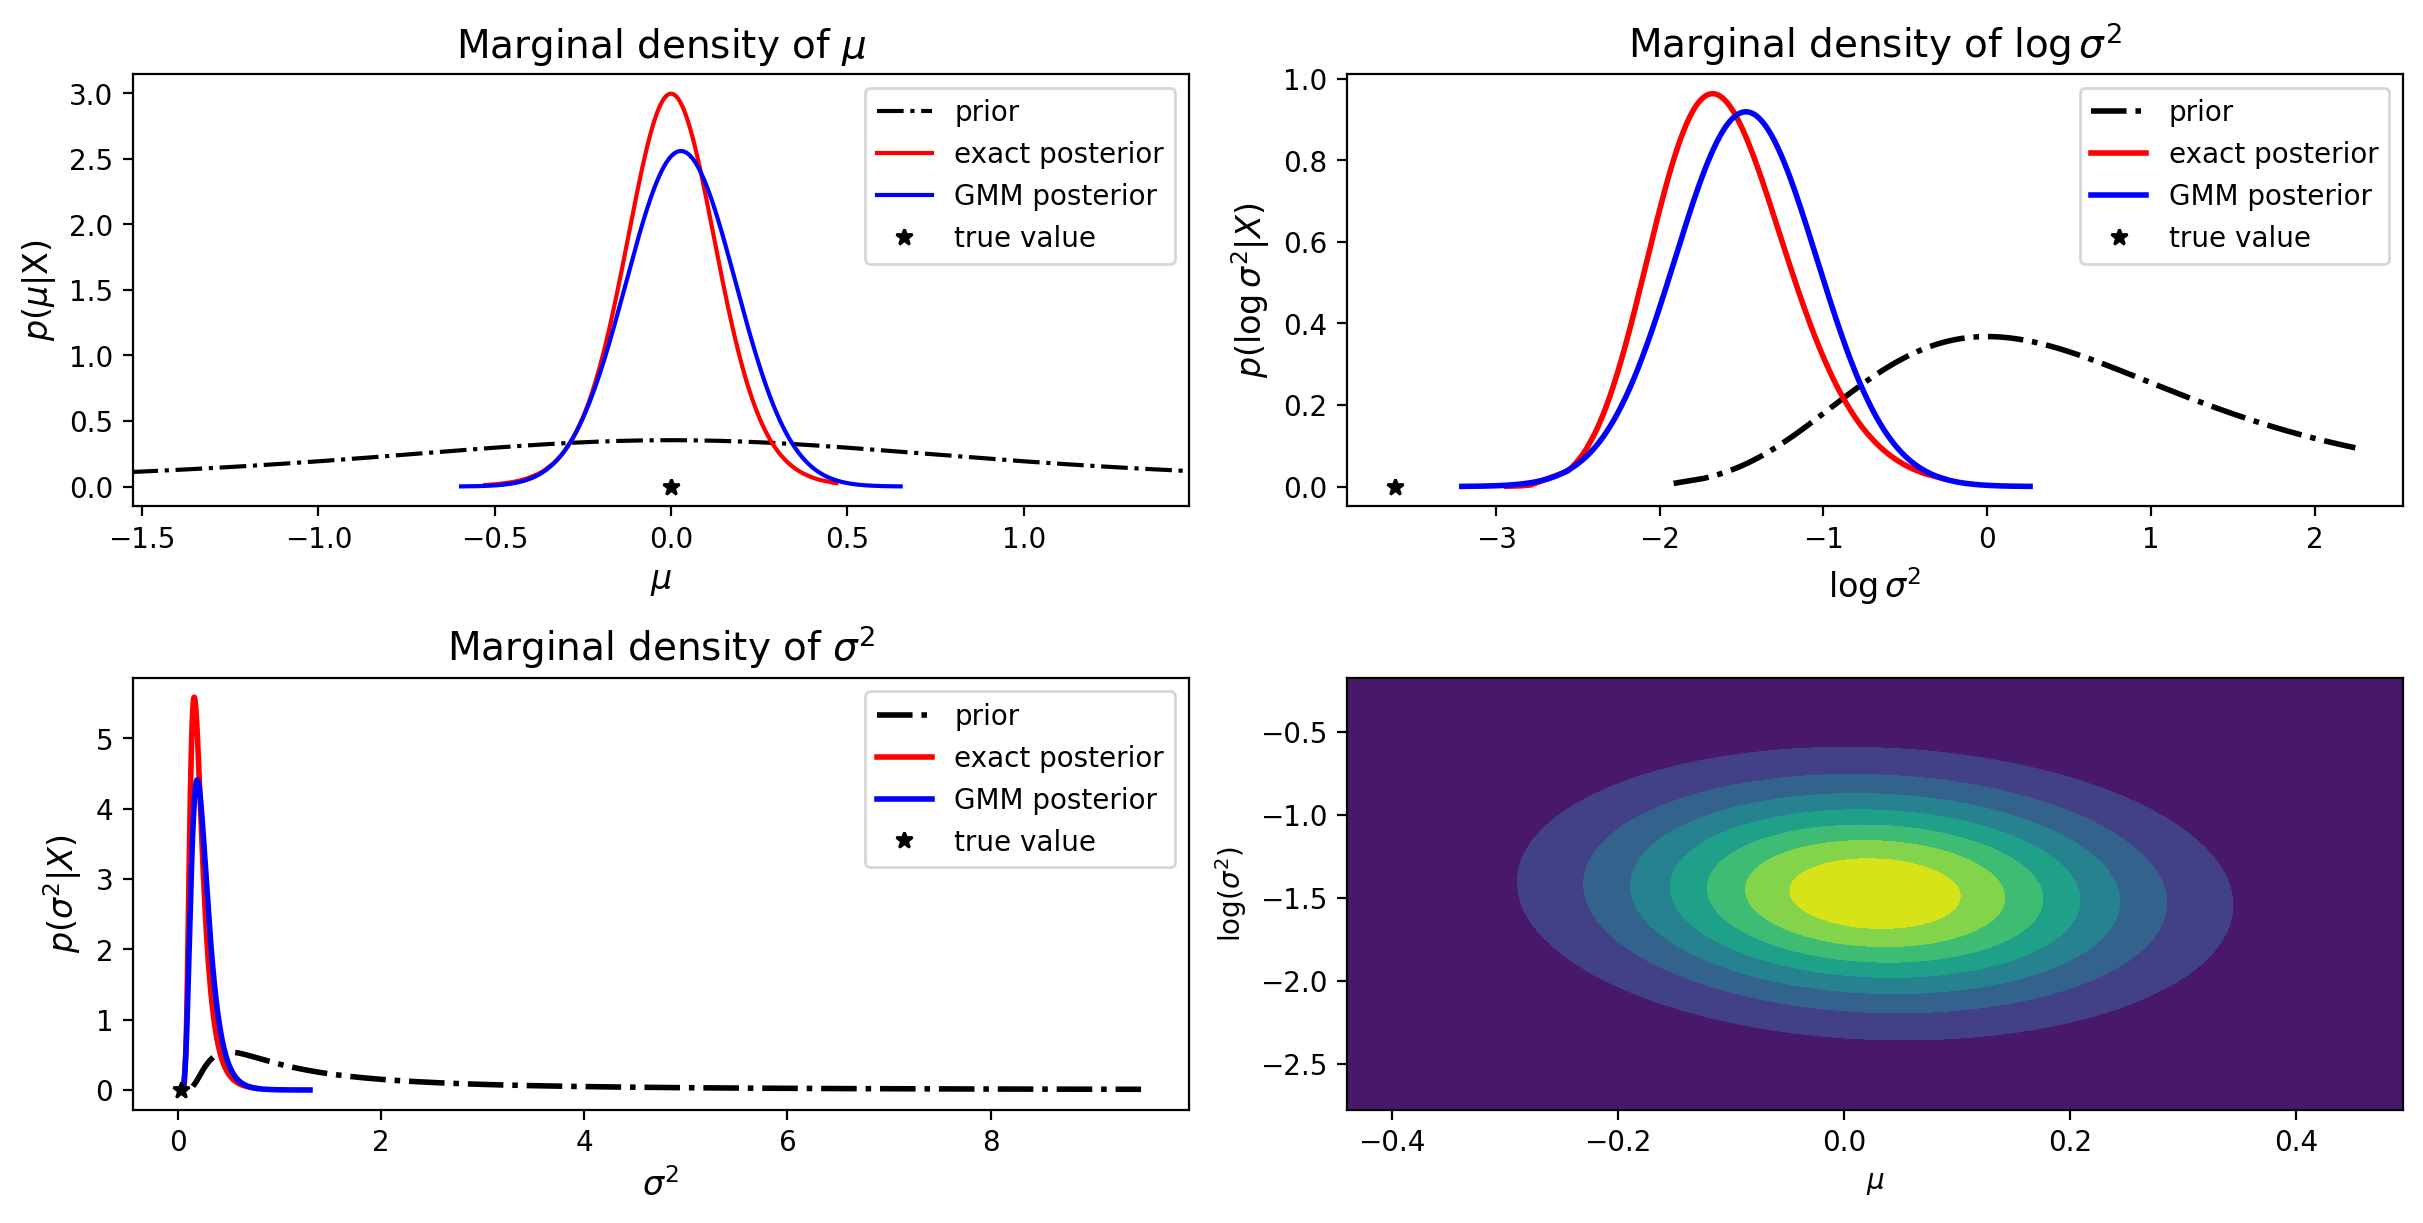

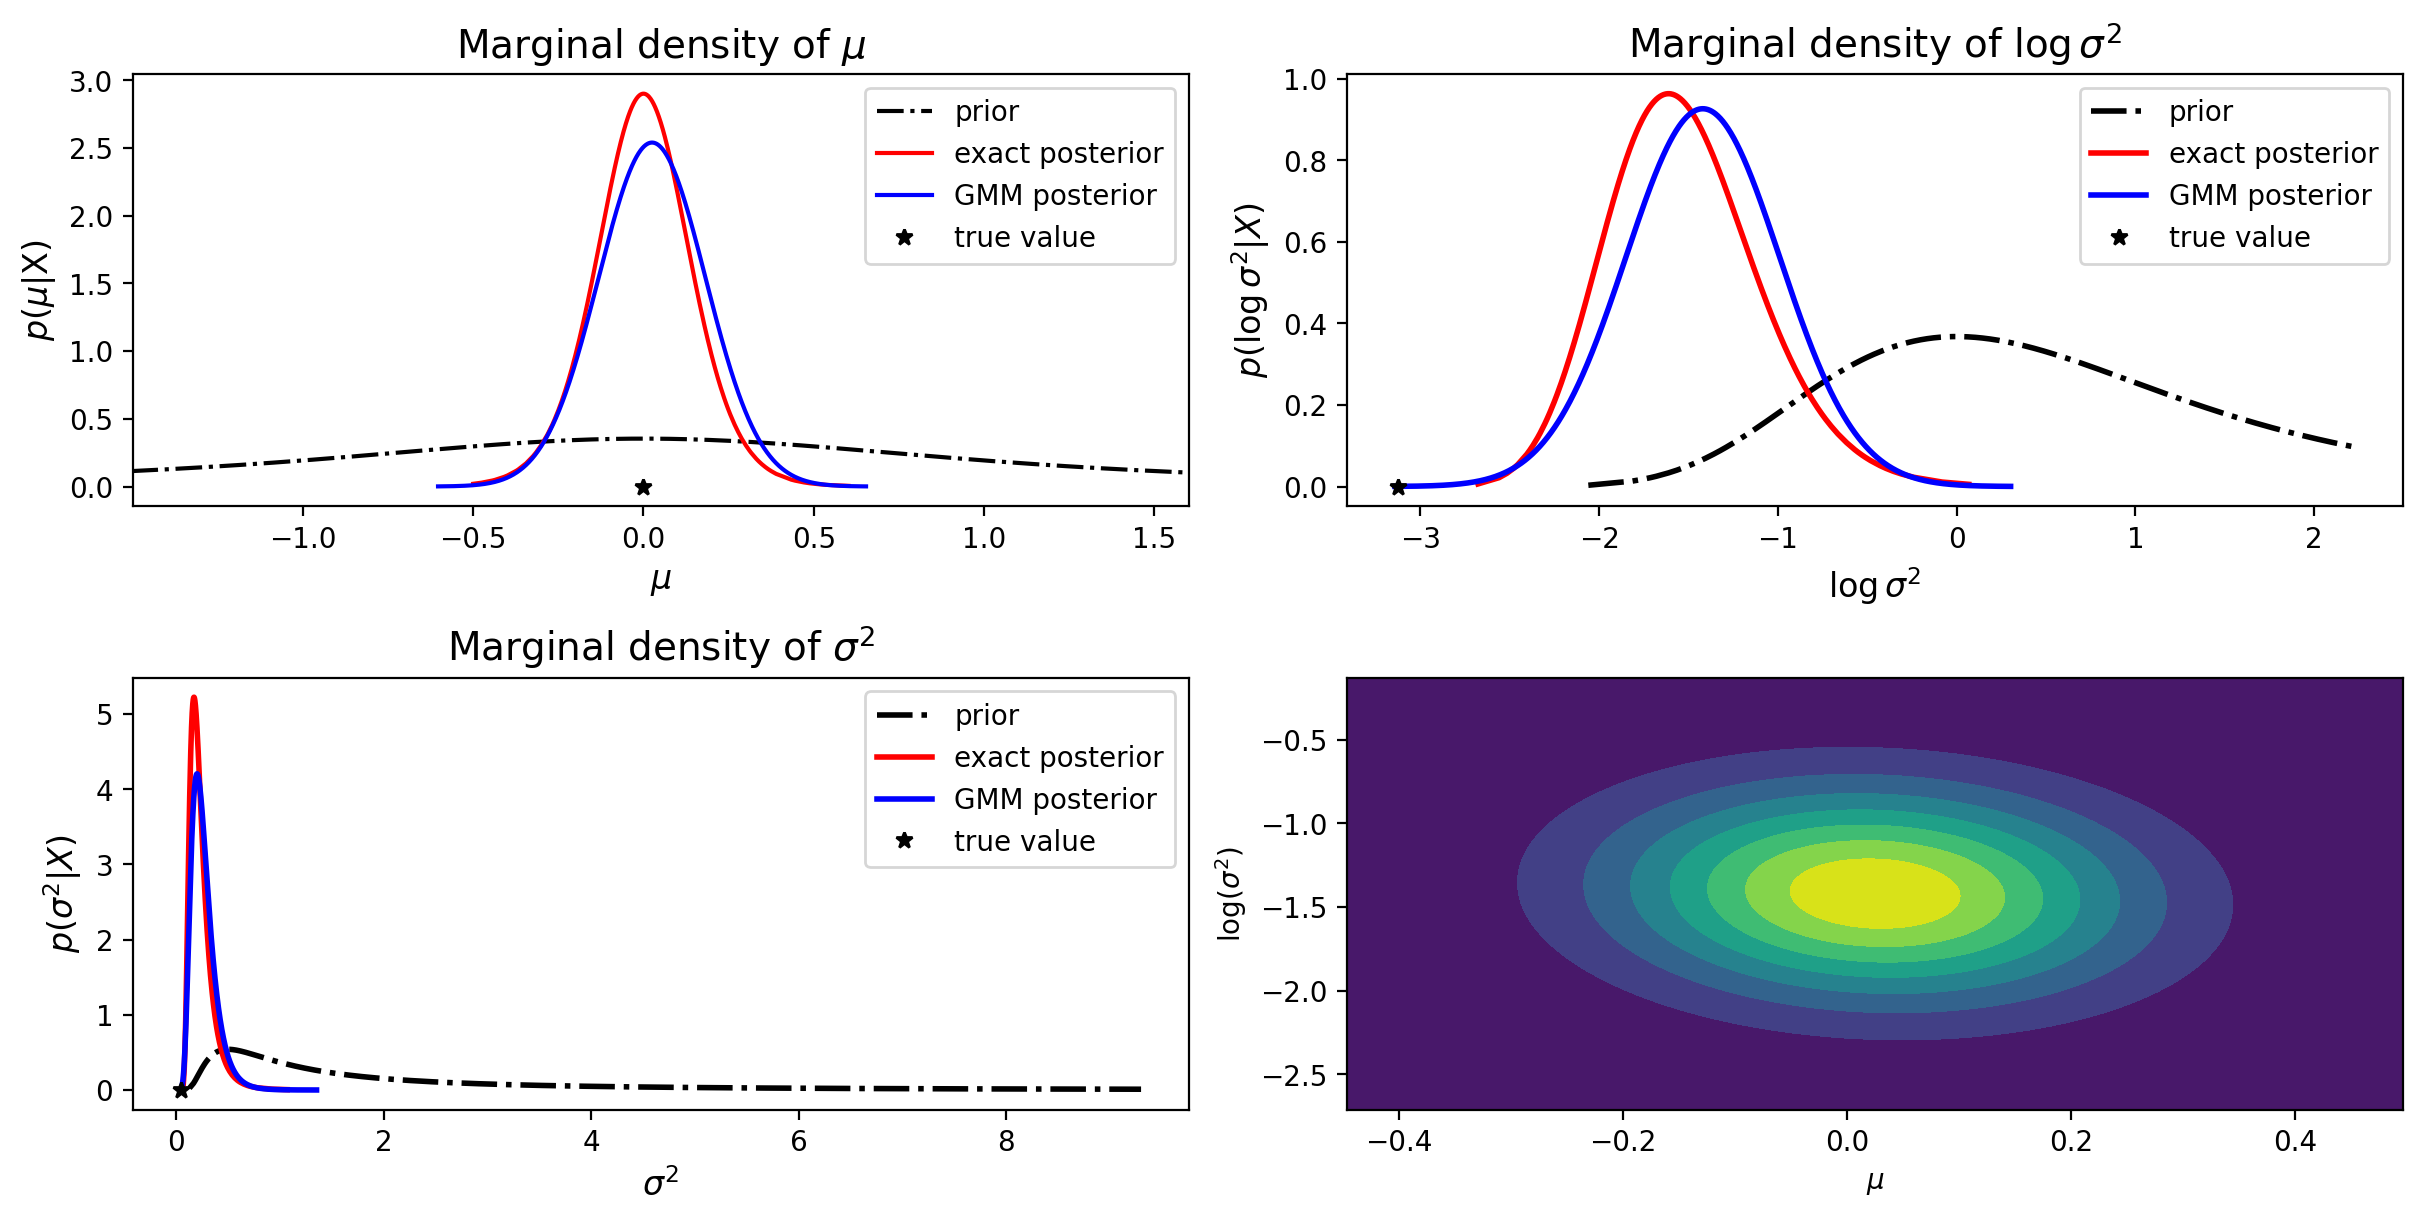

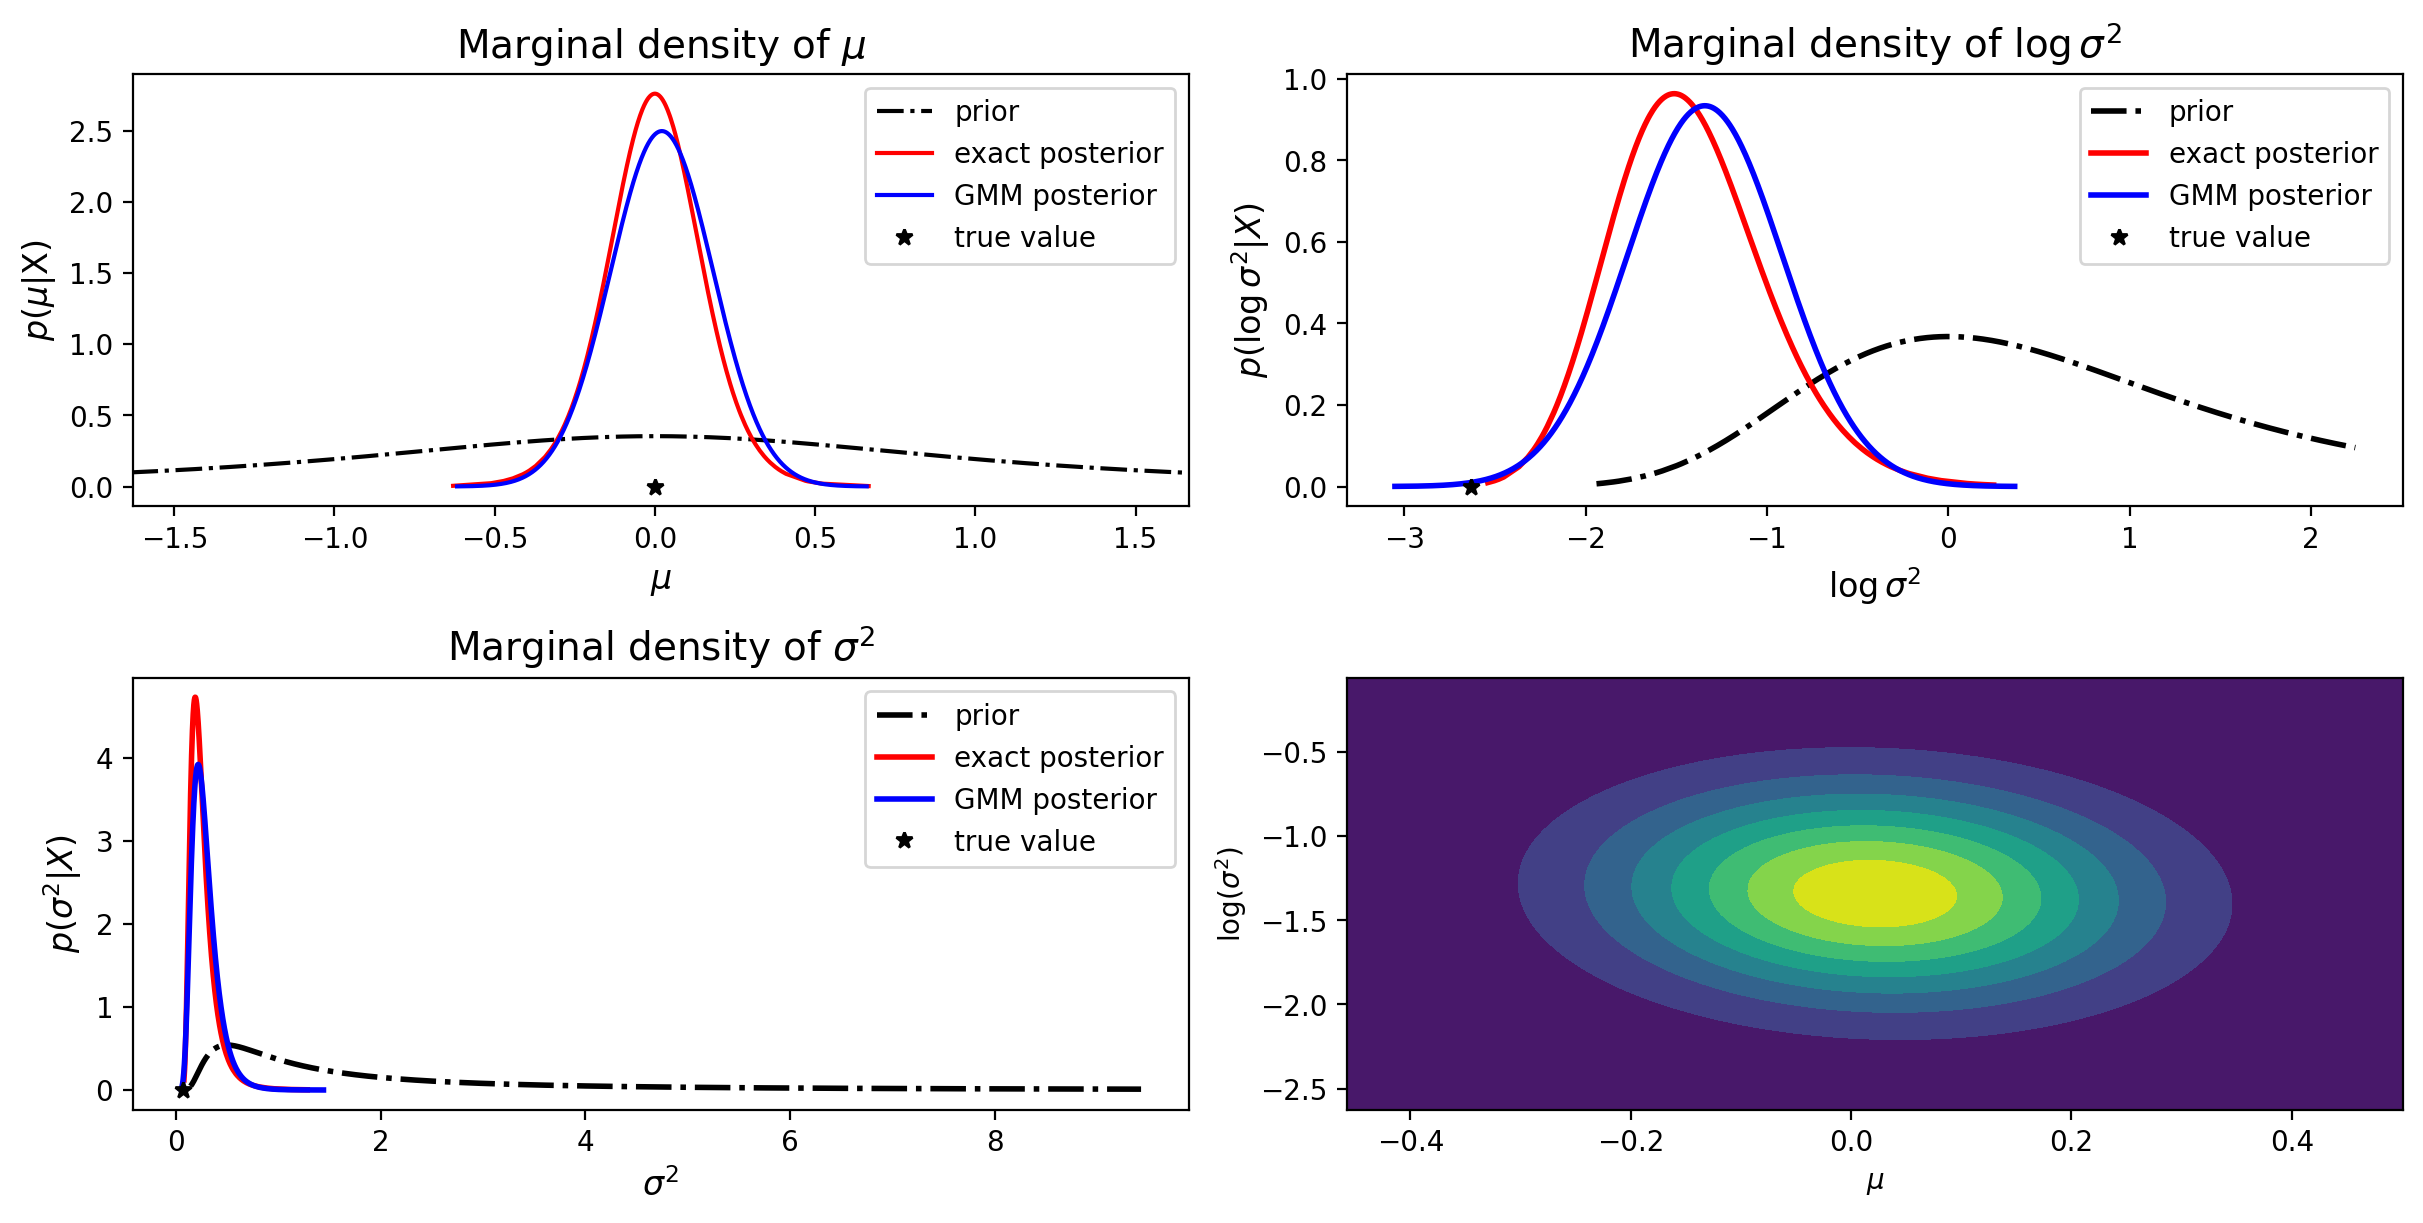

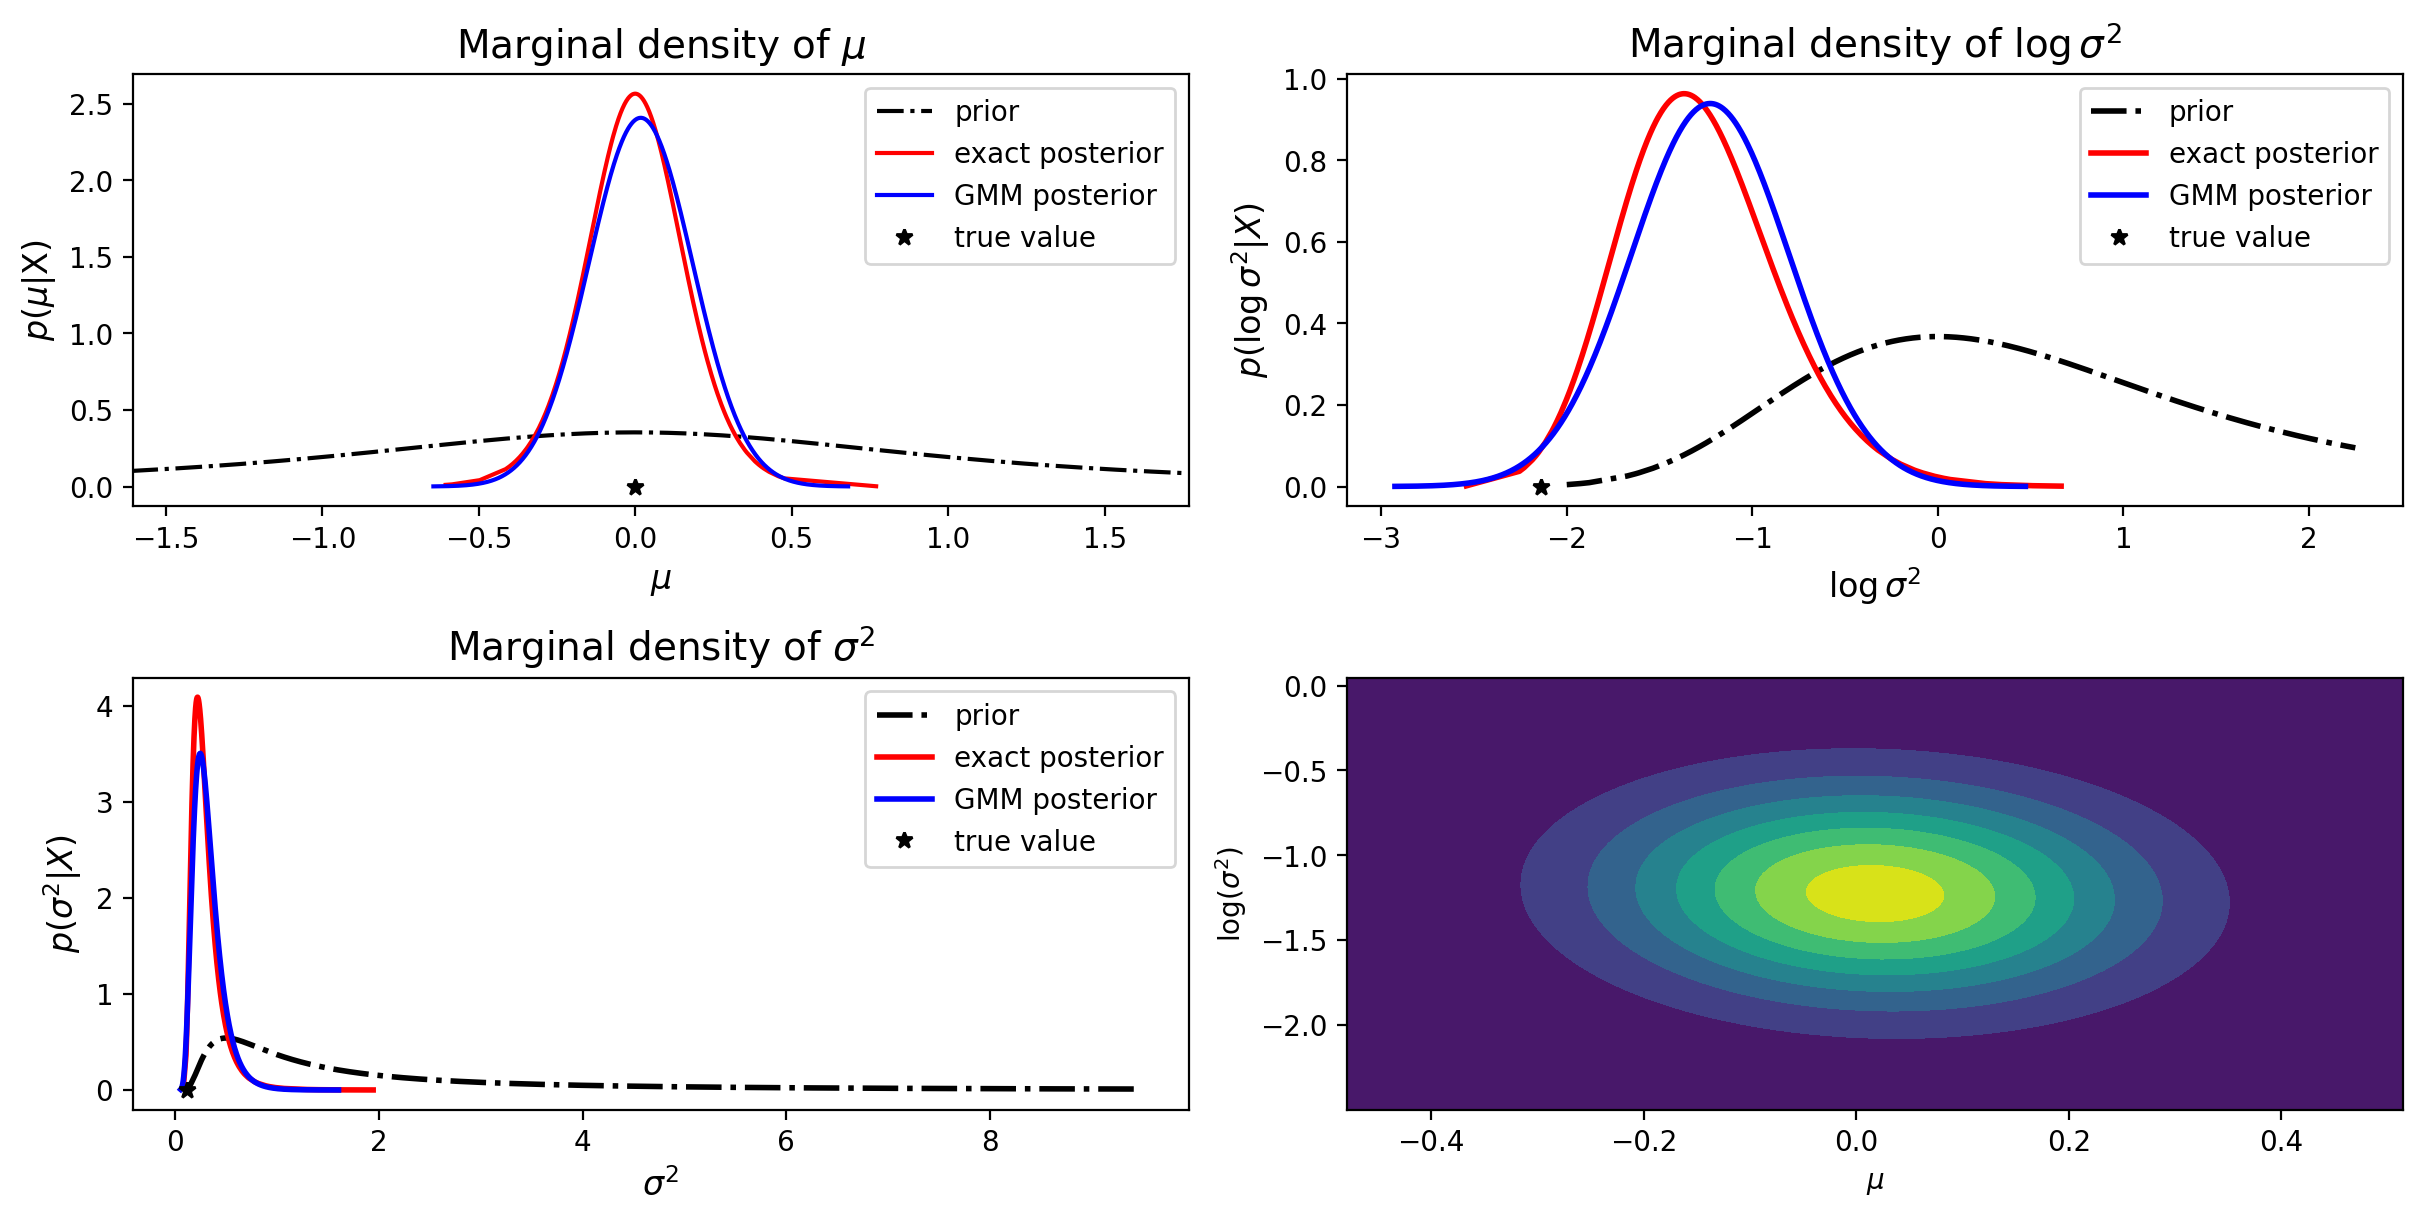

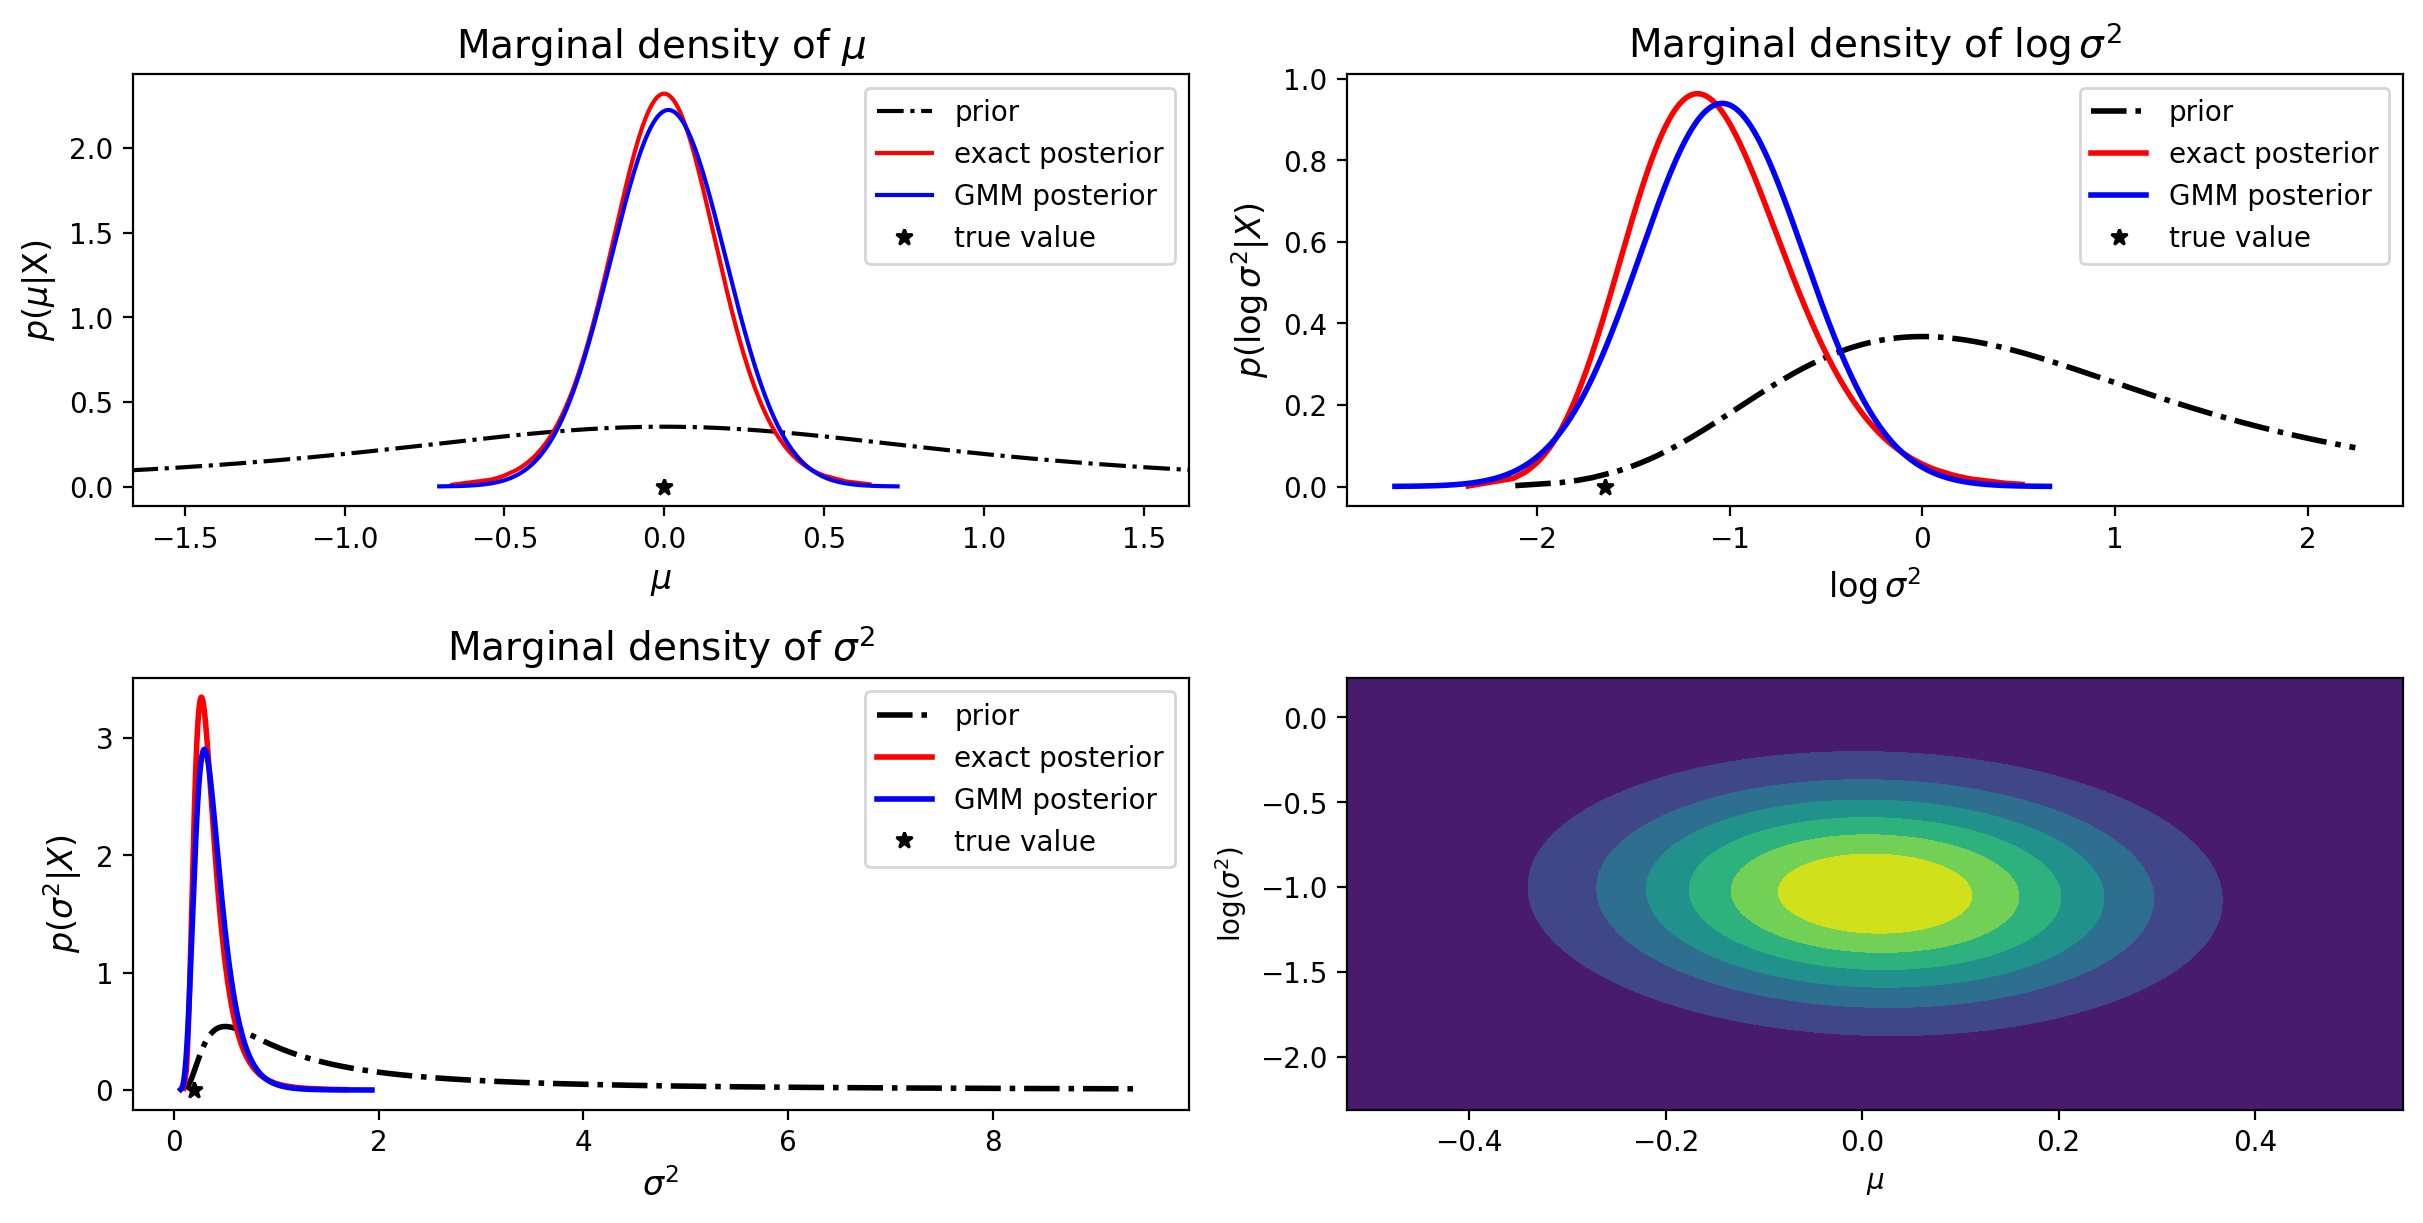

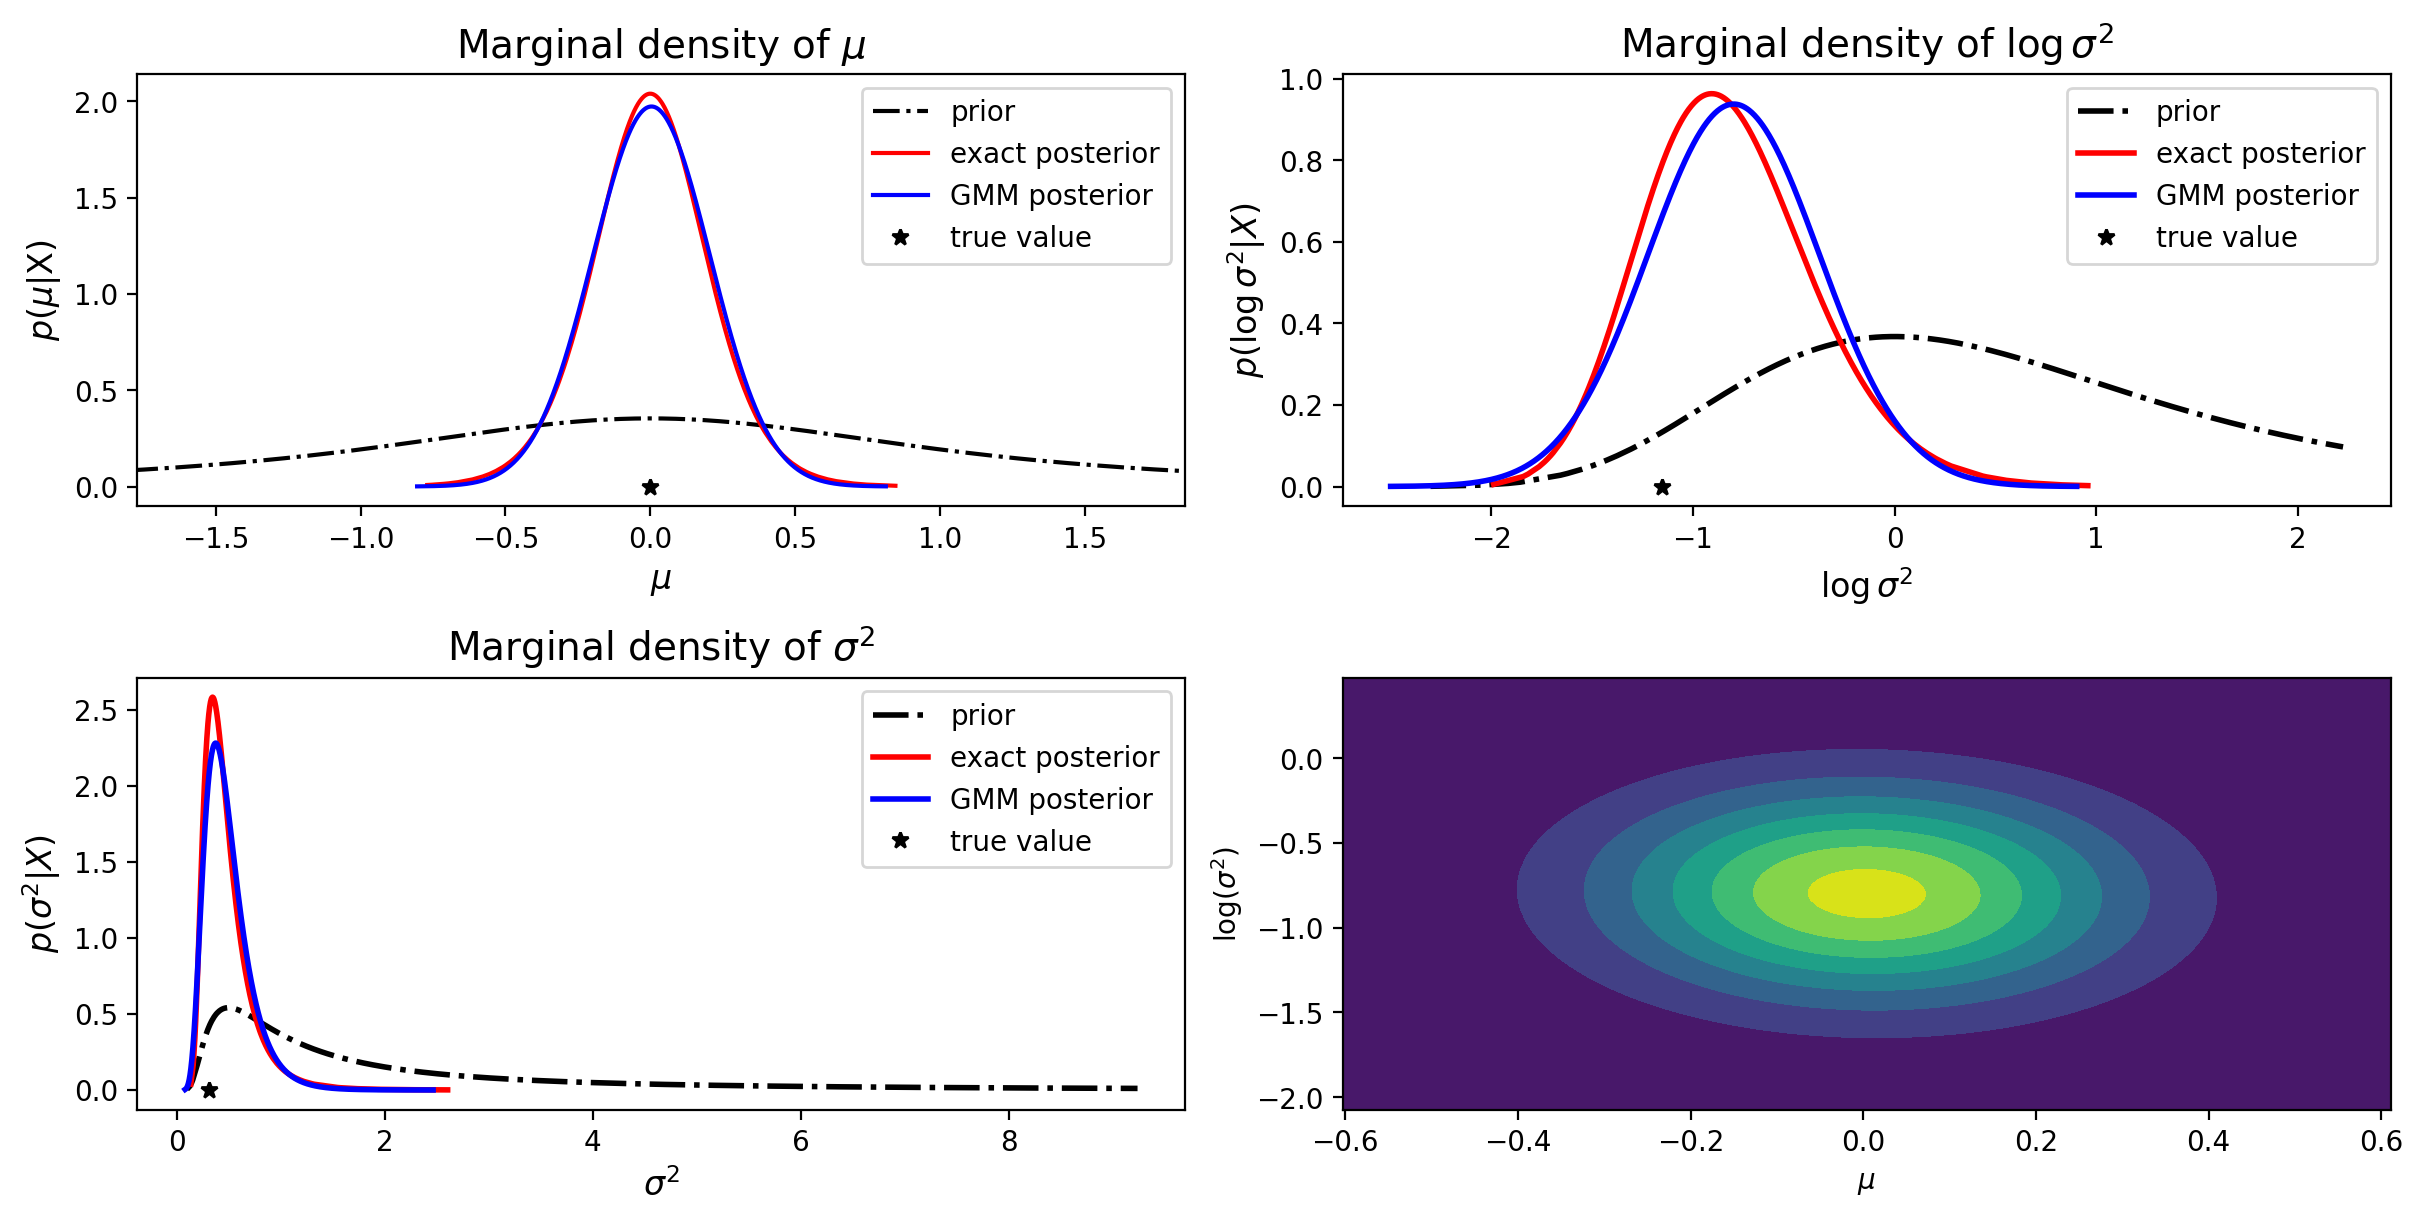

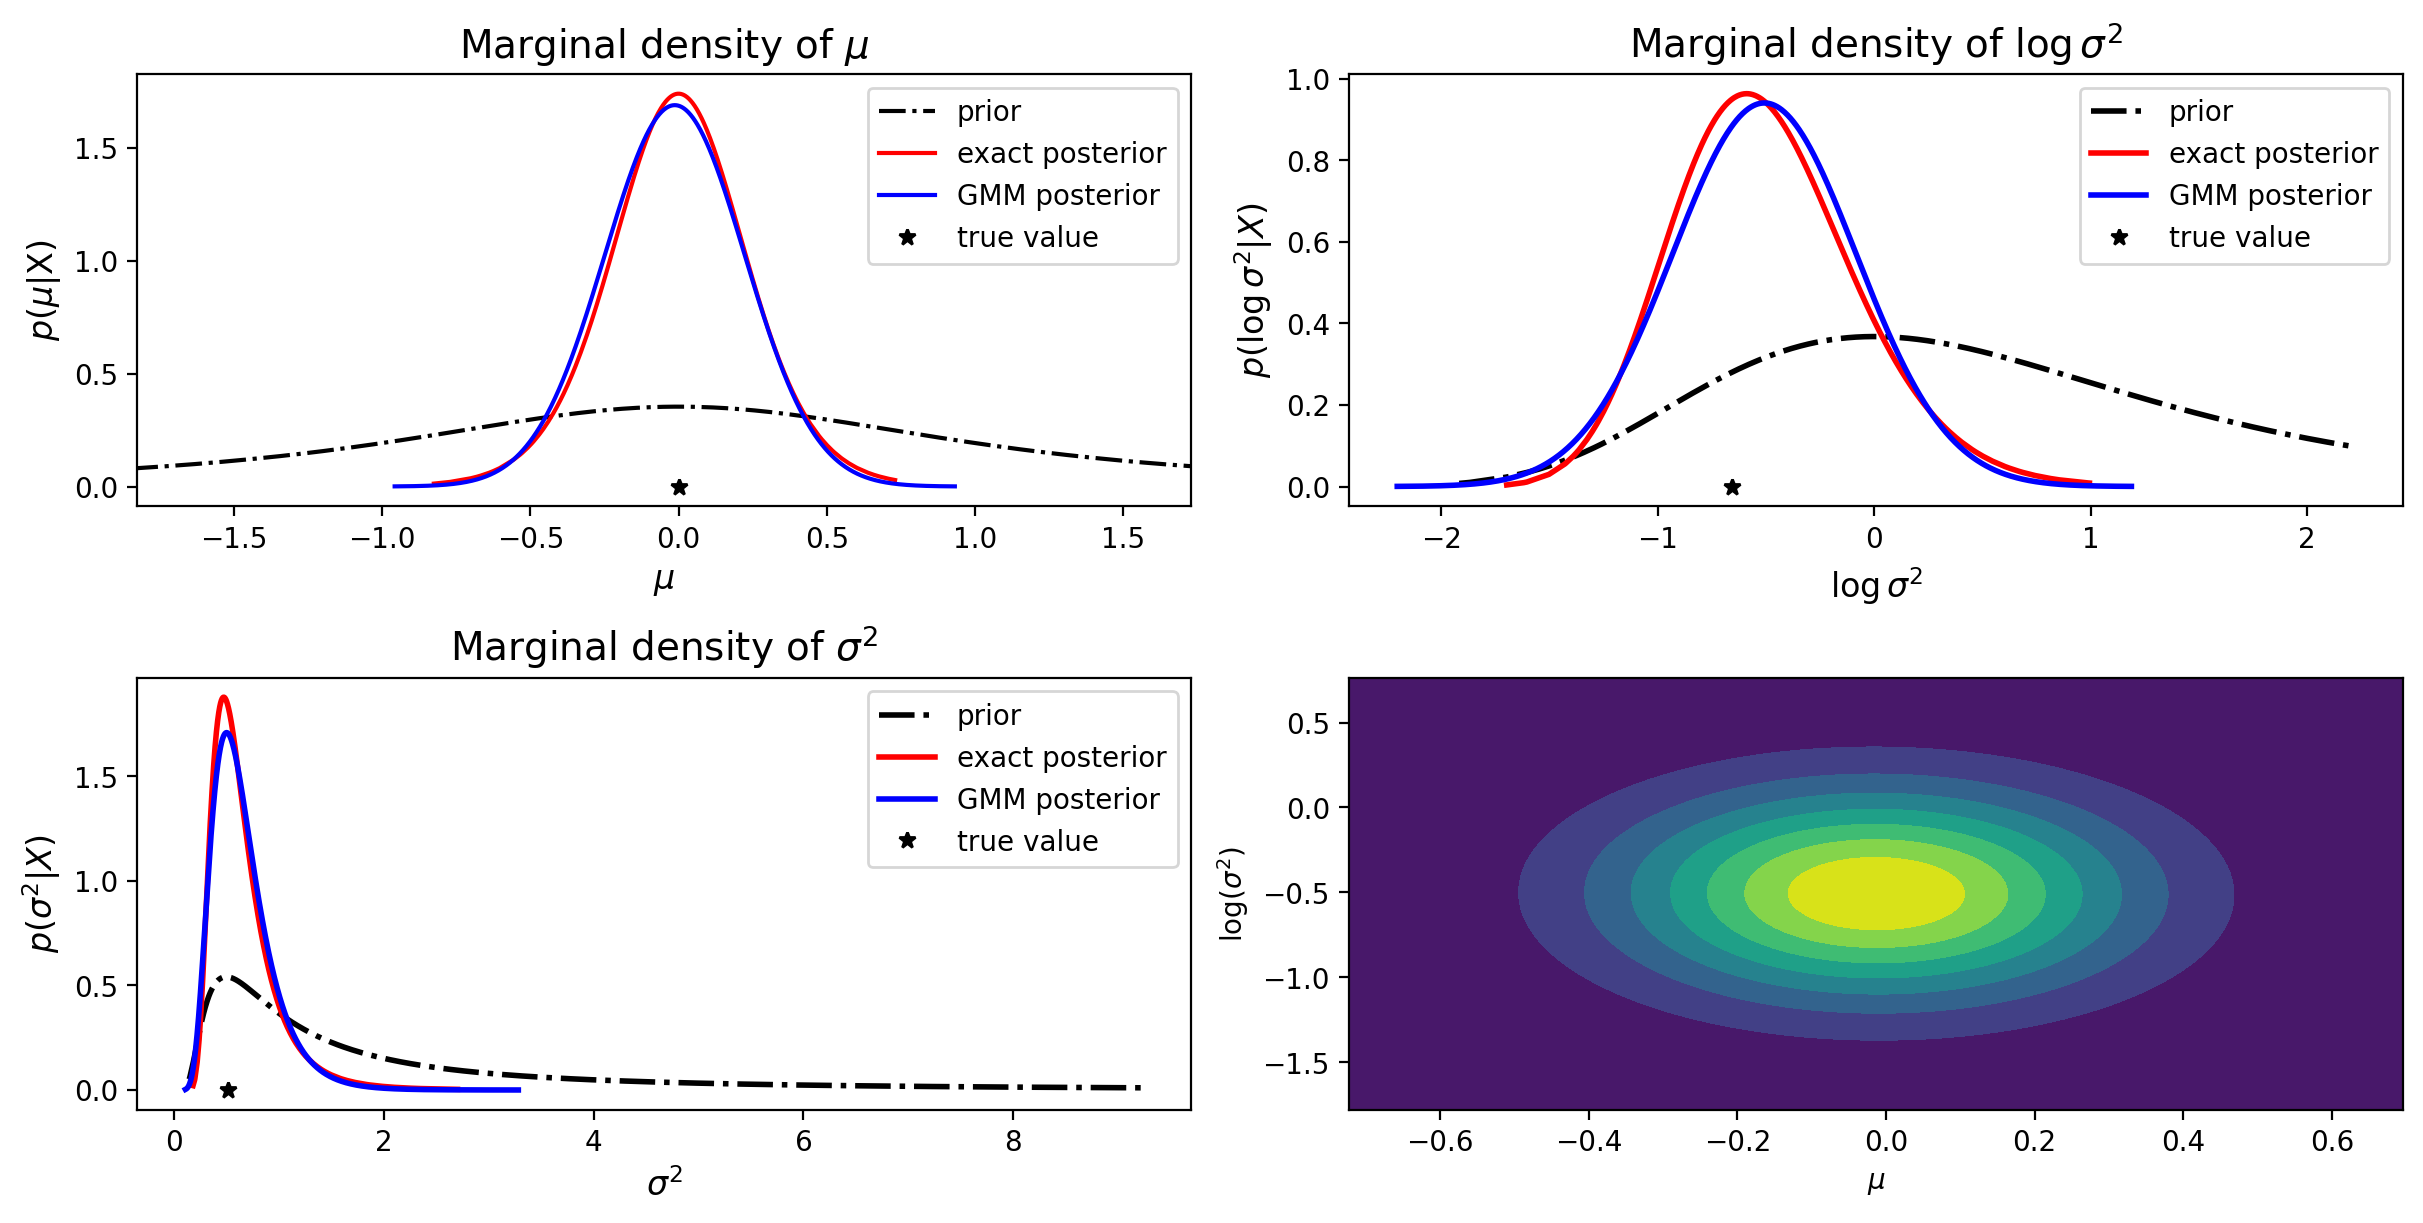

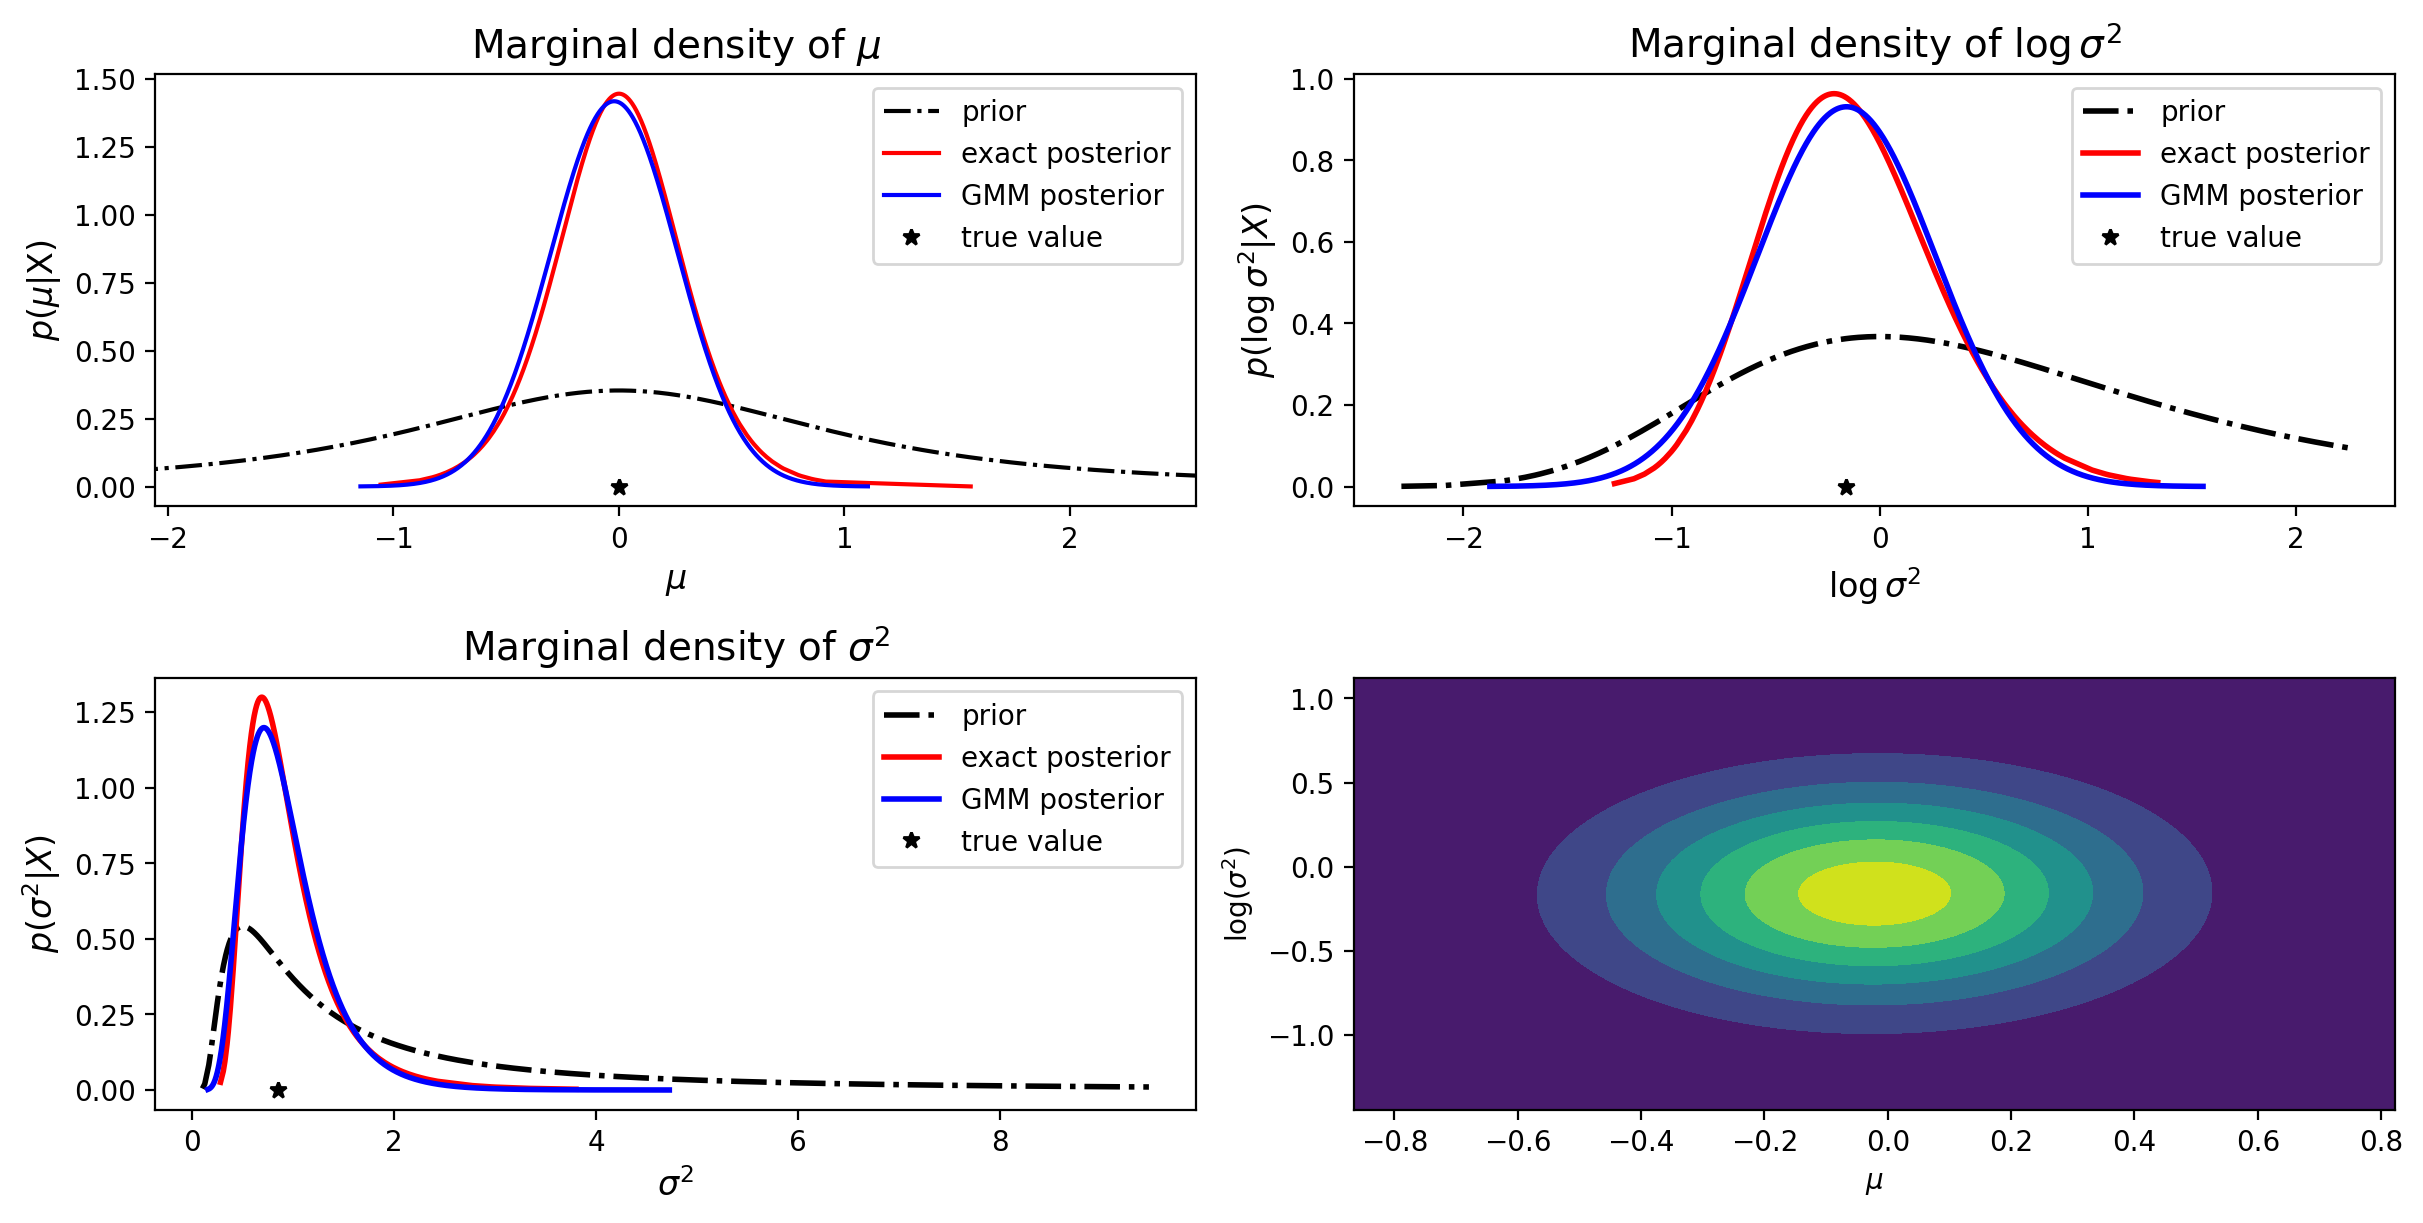

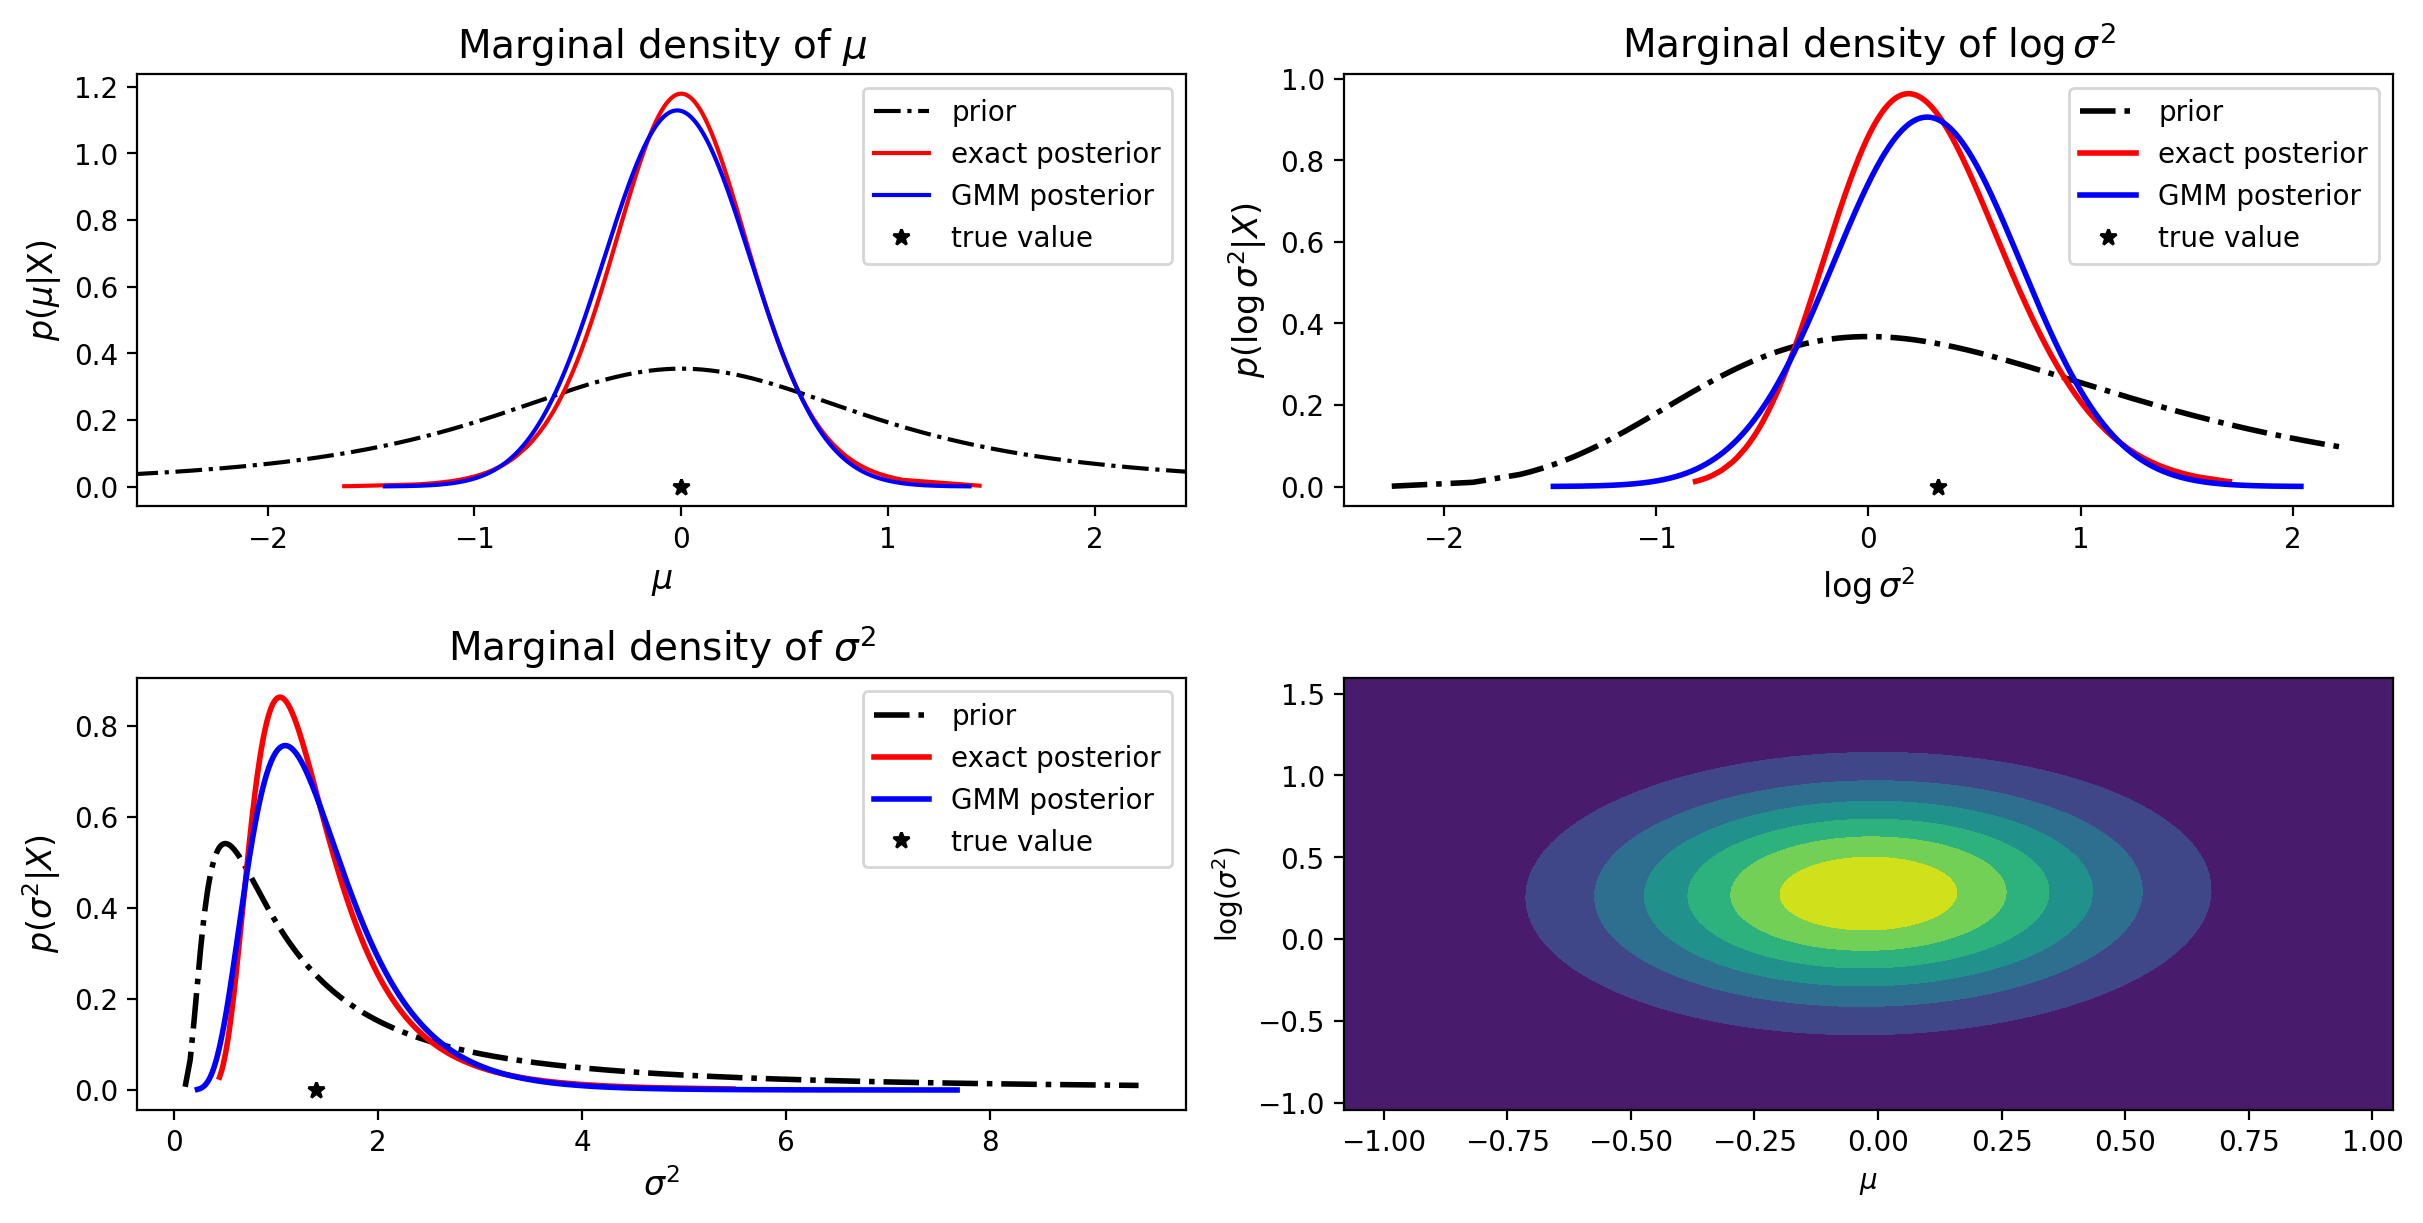

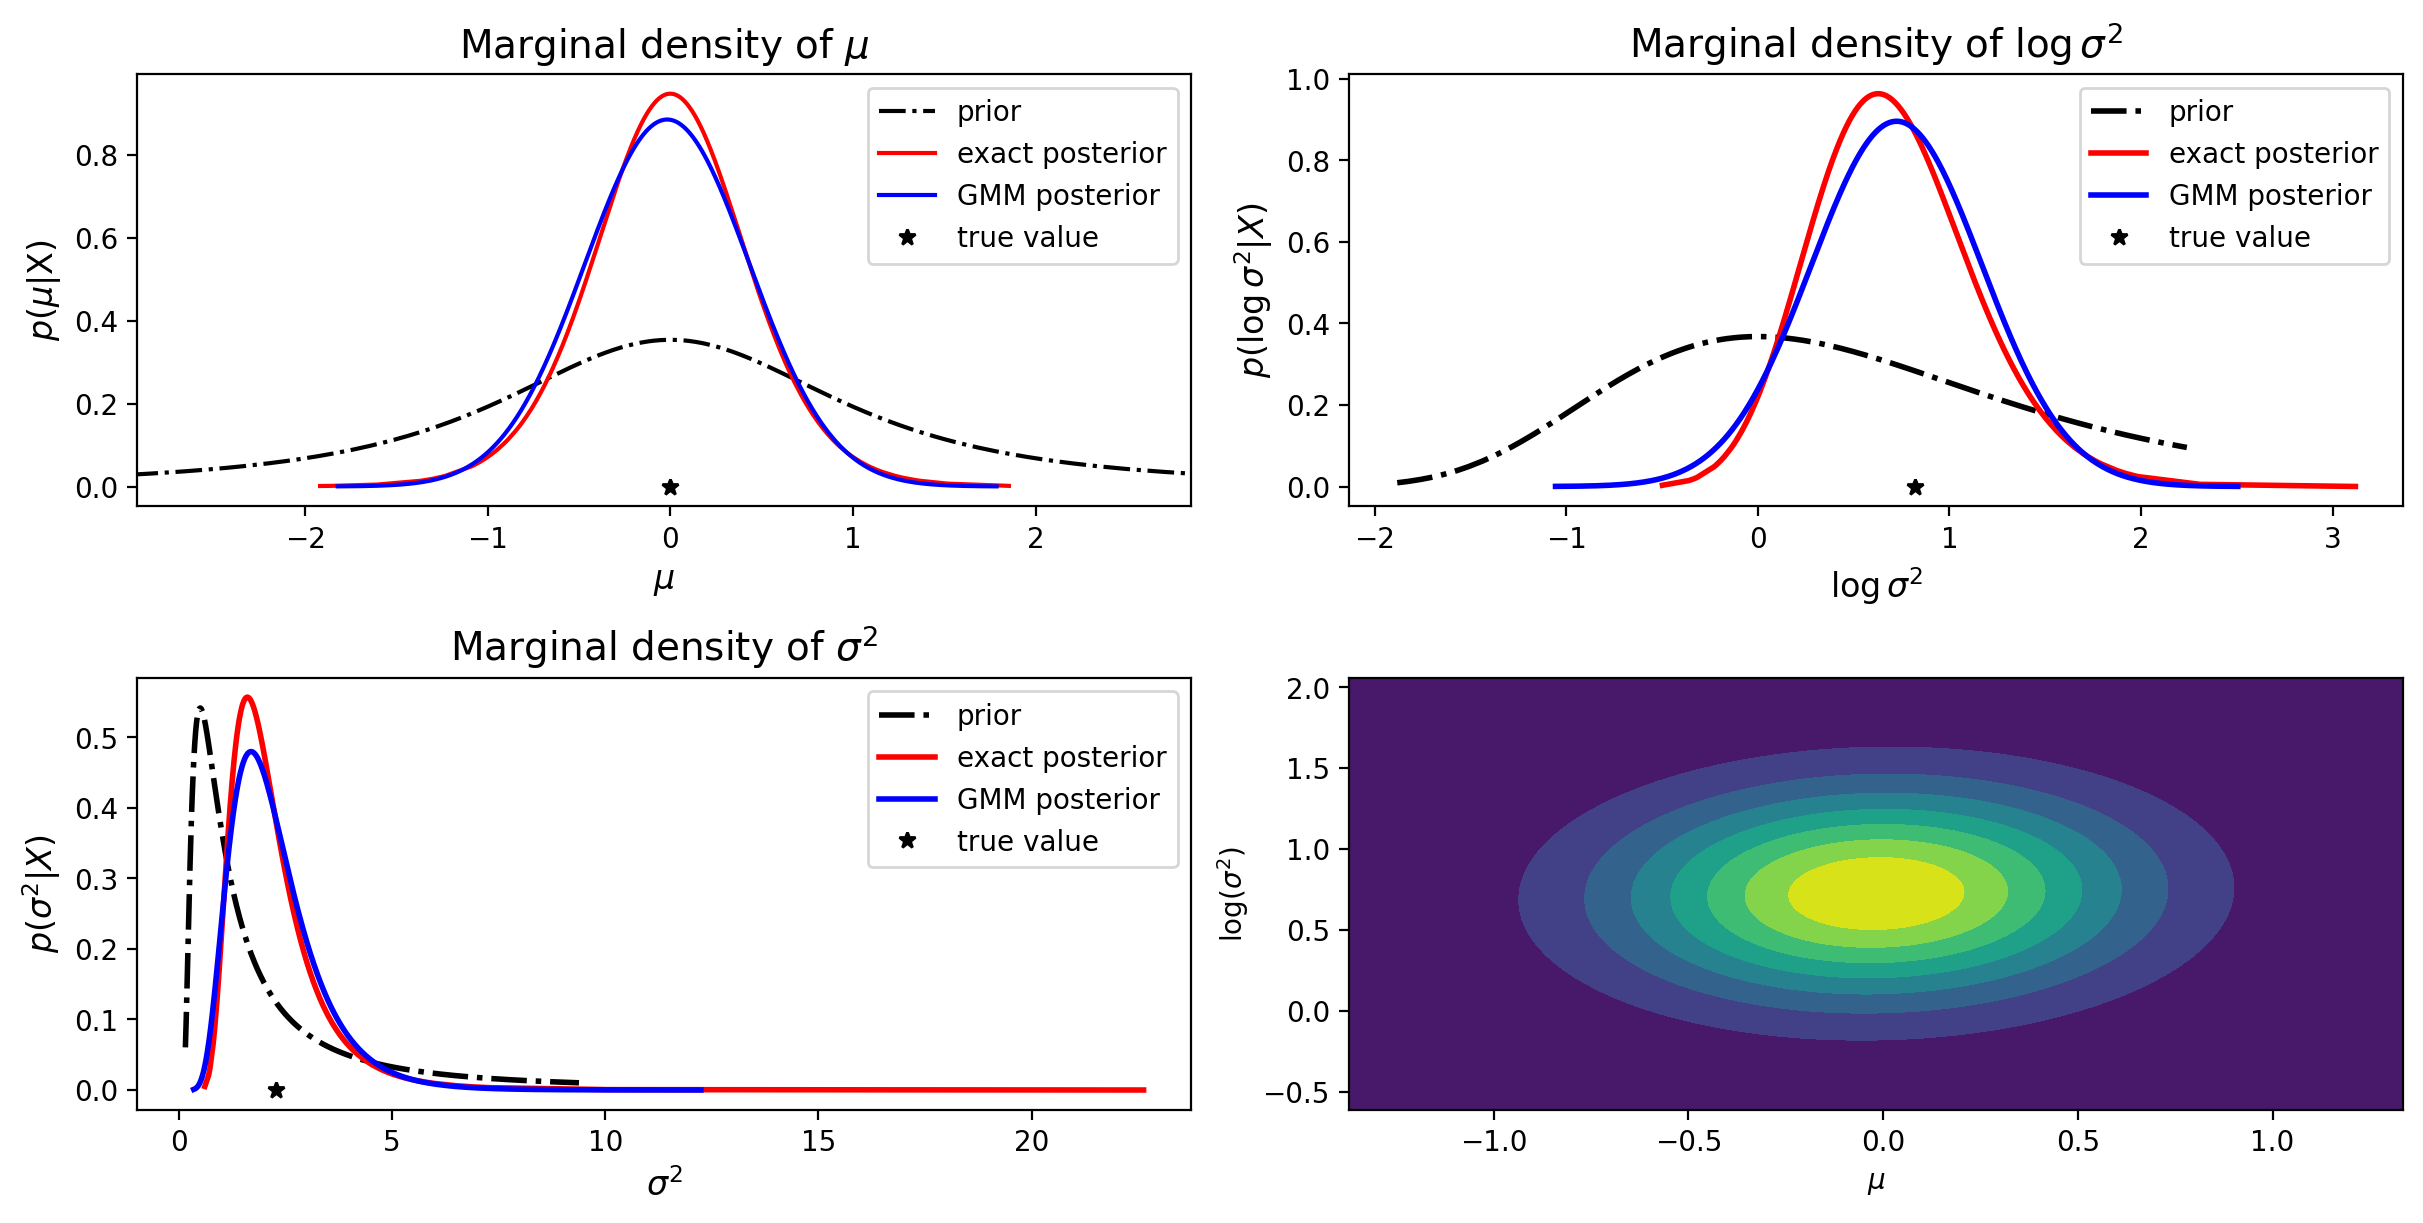

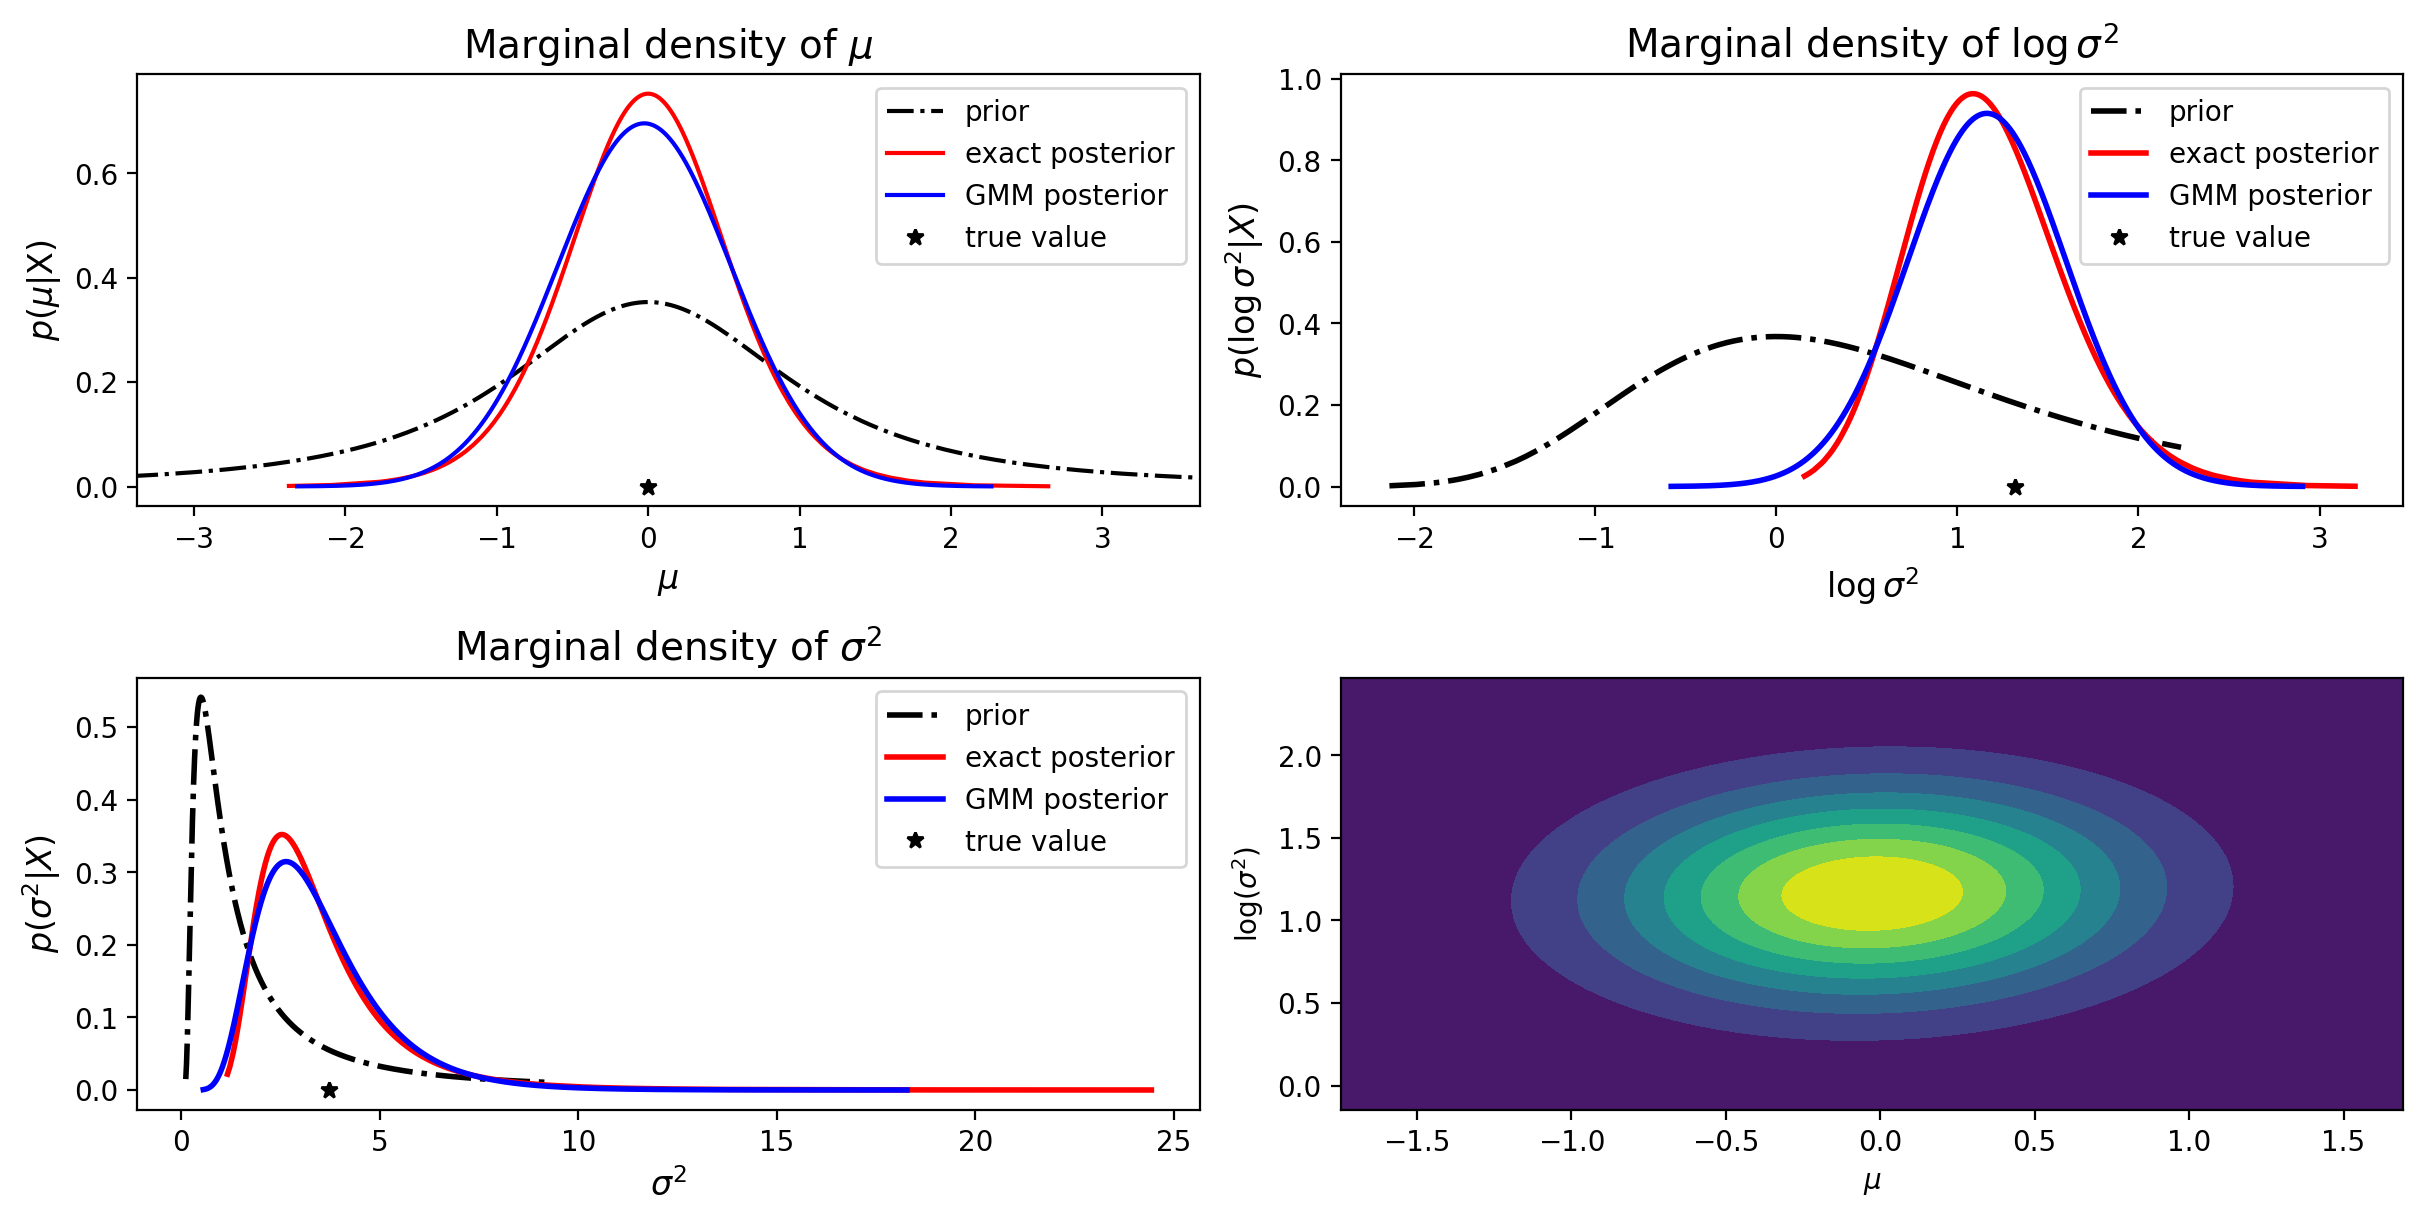

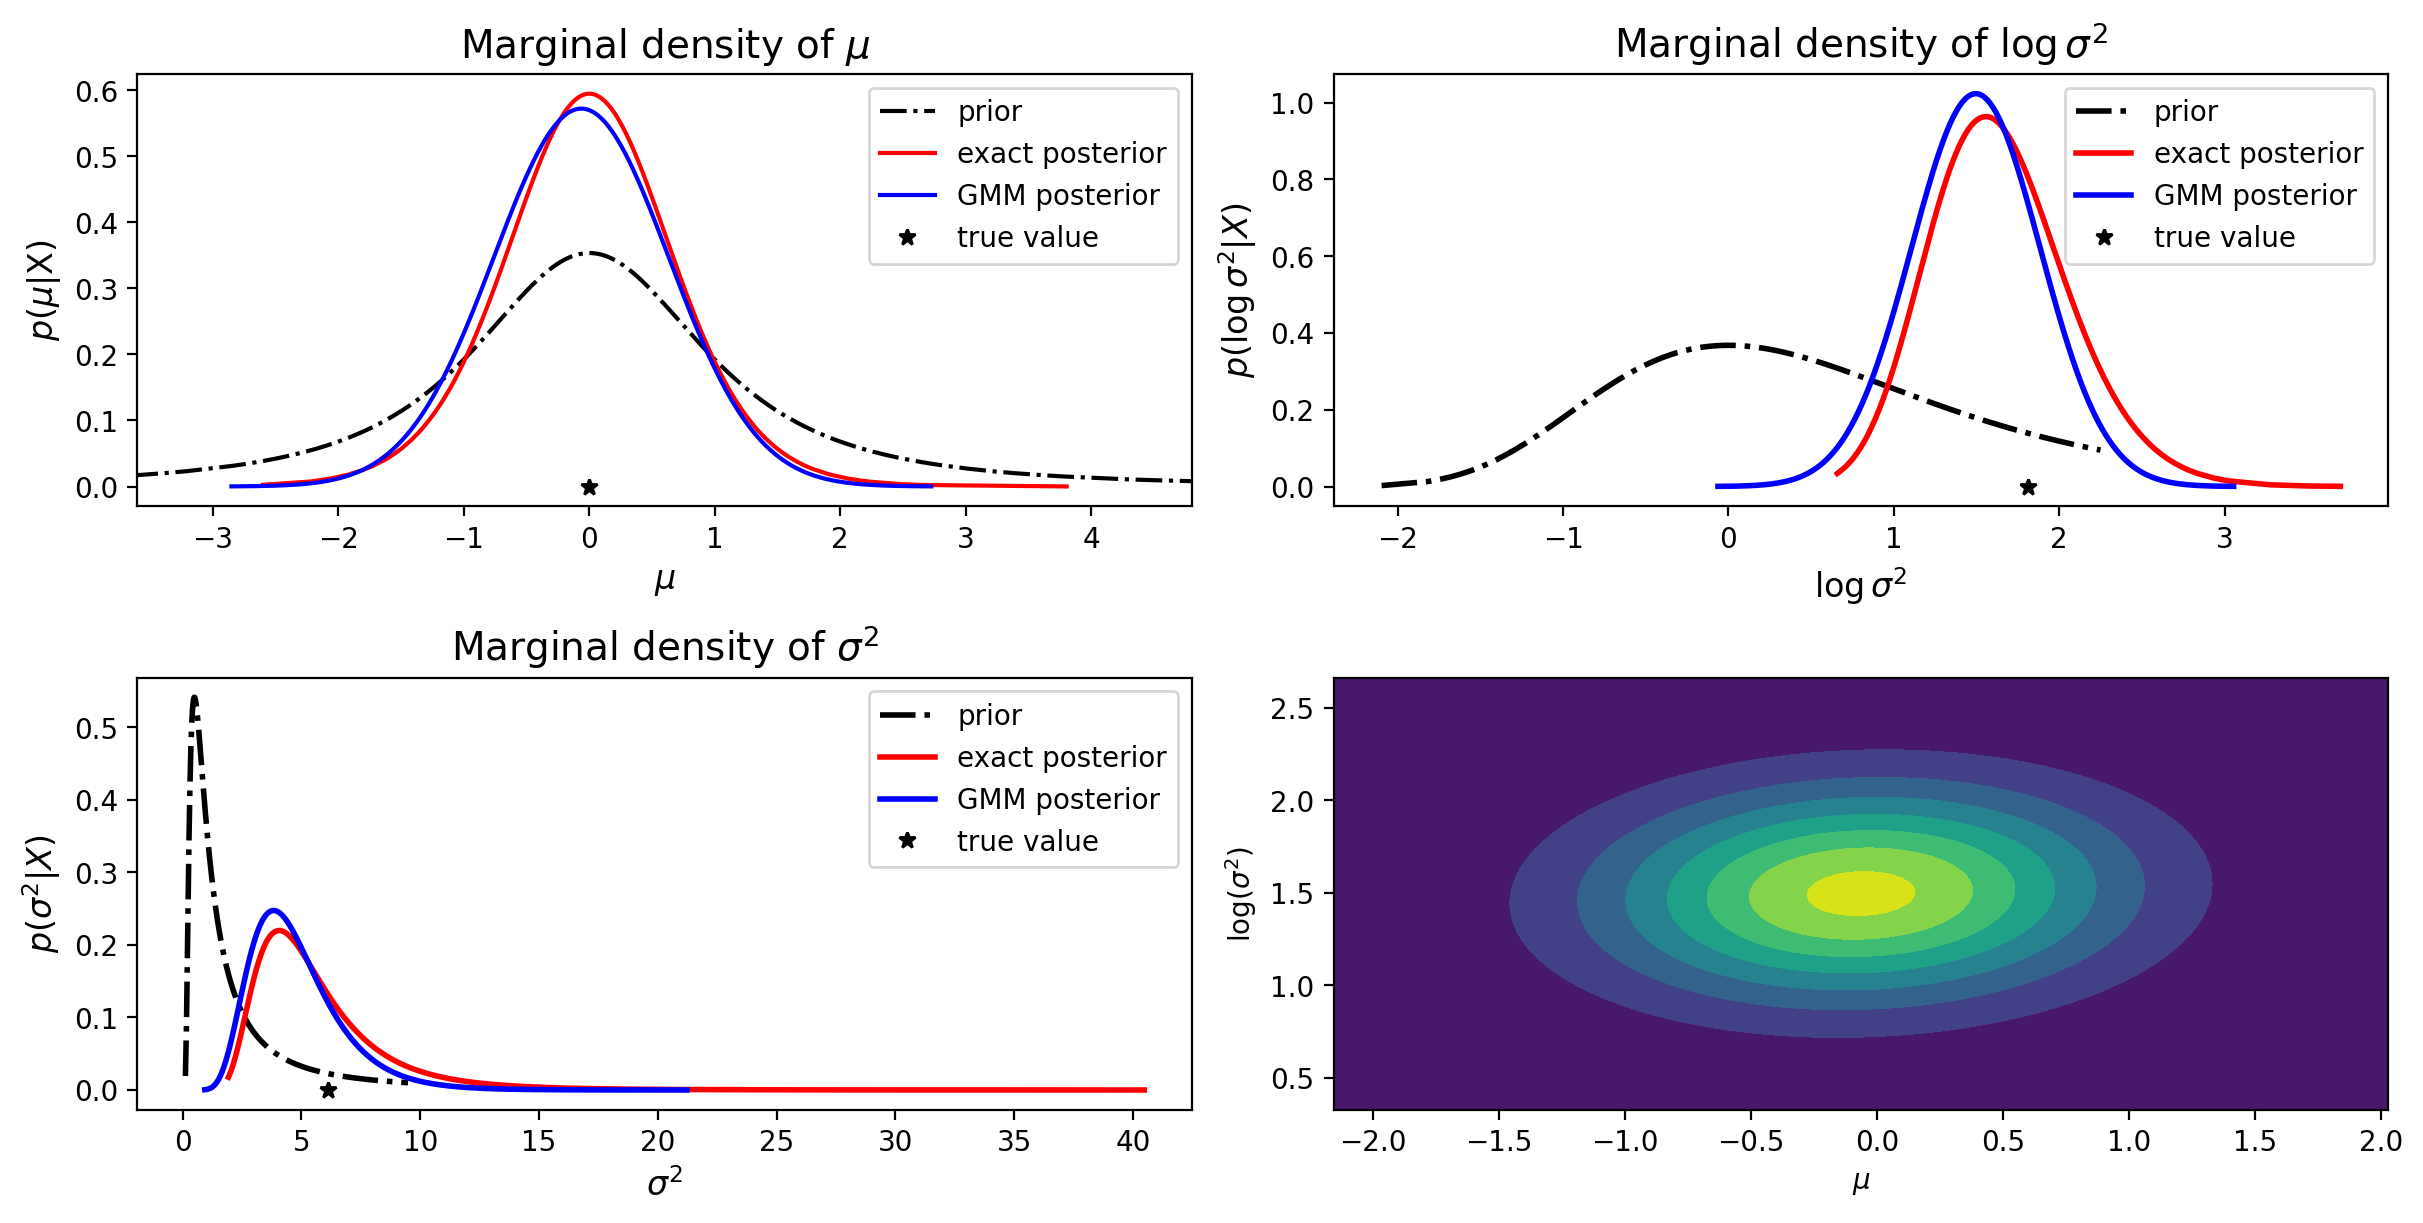

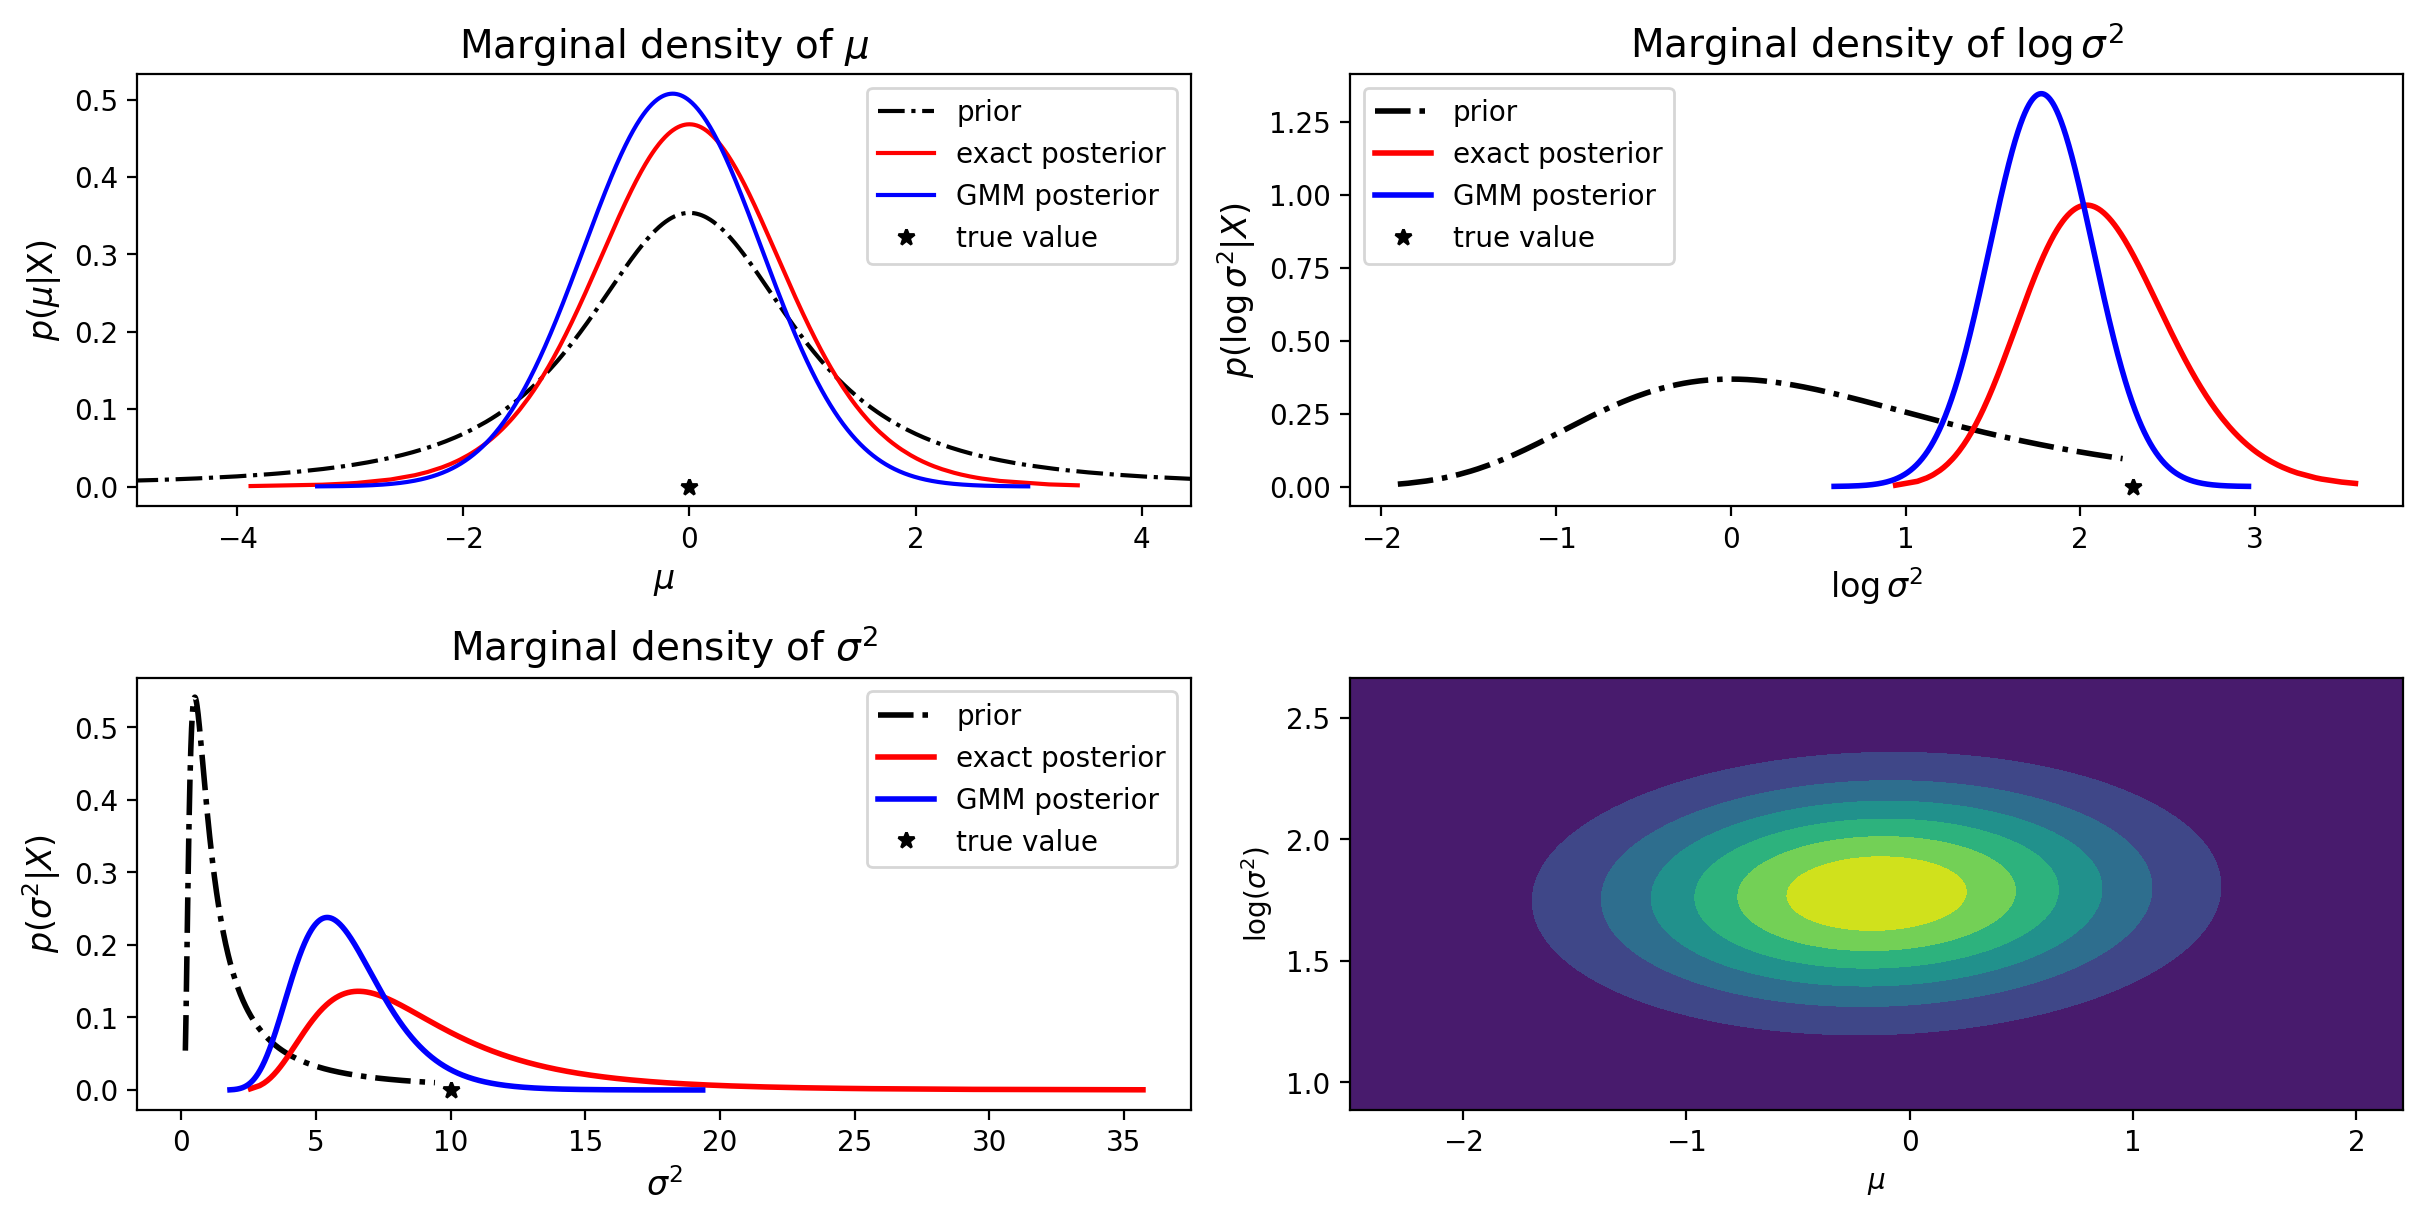

In [53]:
i = W_var.argmin()
x0 = X[i, :]
θ0 = theta[i, :]

gaussian_model = torch_dist.normal.Normal(loc=0.0, scale=1.0)
epsilon = gaussian_model.sample((n,))
epsilon = (epsilon - epsilon.mean(dim=0)) / epsilon.std(dim=0)
 
logvar = np.linspace(np.log(0.01), np.log(10.0), 15)

for k in range(15):
    theta_0 = torch.tensor([0.0, logvar[k]])
    Y = theta_0[0] + sqrt(torch.exp(theta_0[1])) * epsilon
    compare_marginals_gaussian(model=gmm_nd, x=Y, theta=theta_0, alpha=α, beta=β, mu_0=μ_0, kappa=κ,
                            prior_only=False, posterior_only=False, upper=0.9)
 

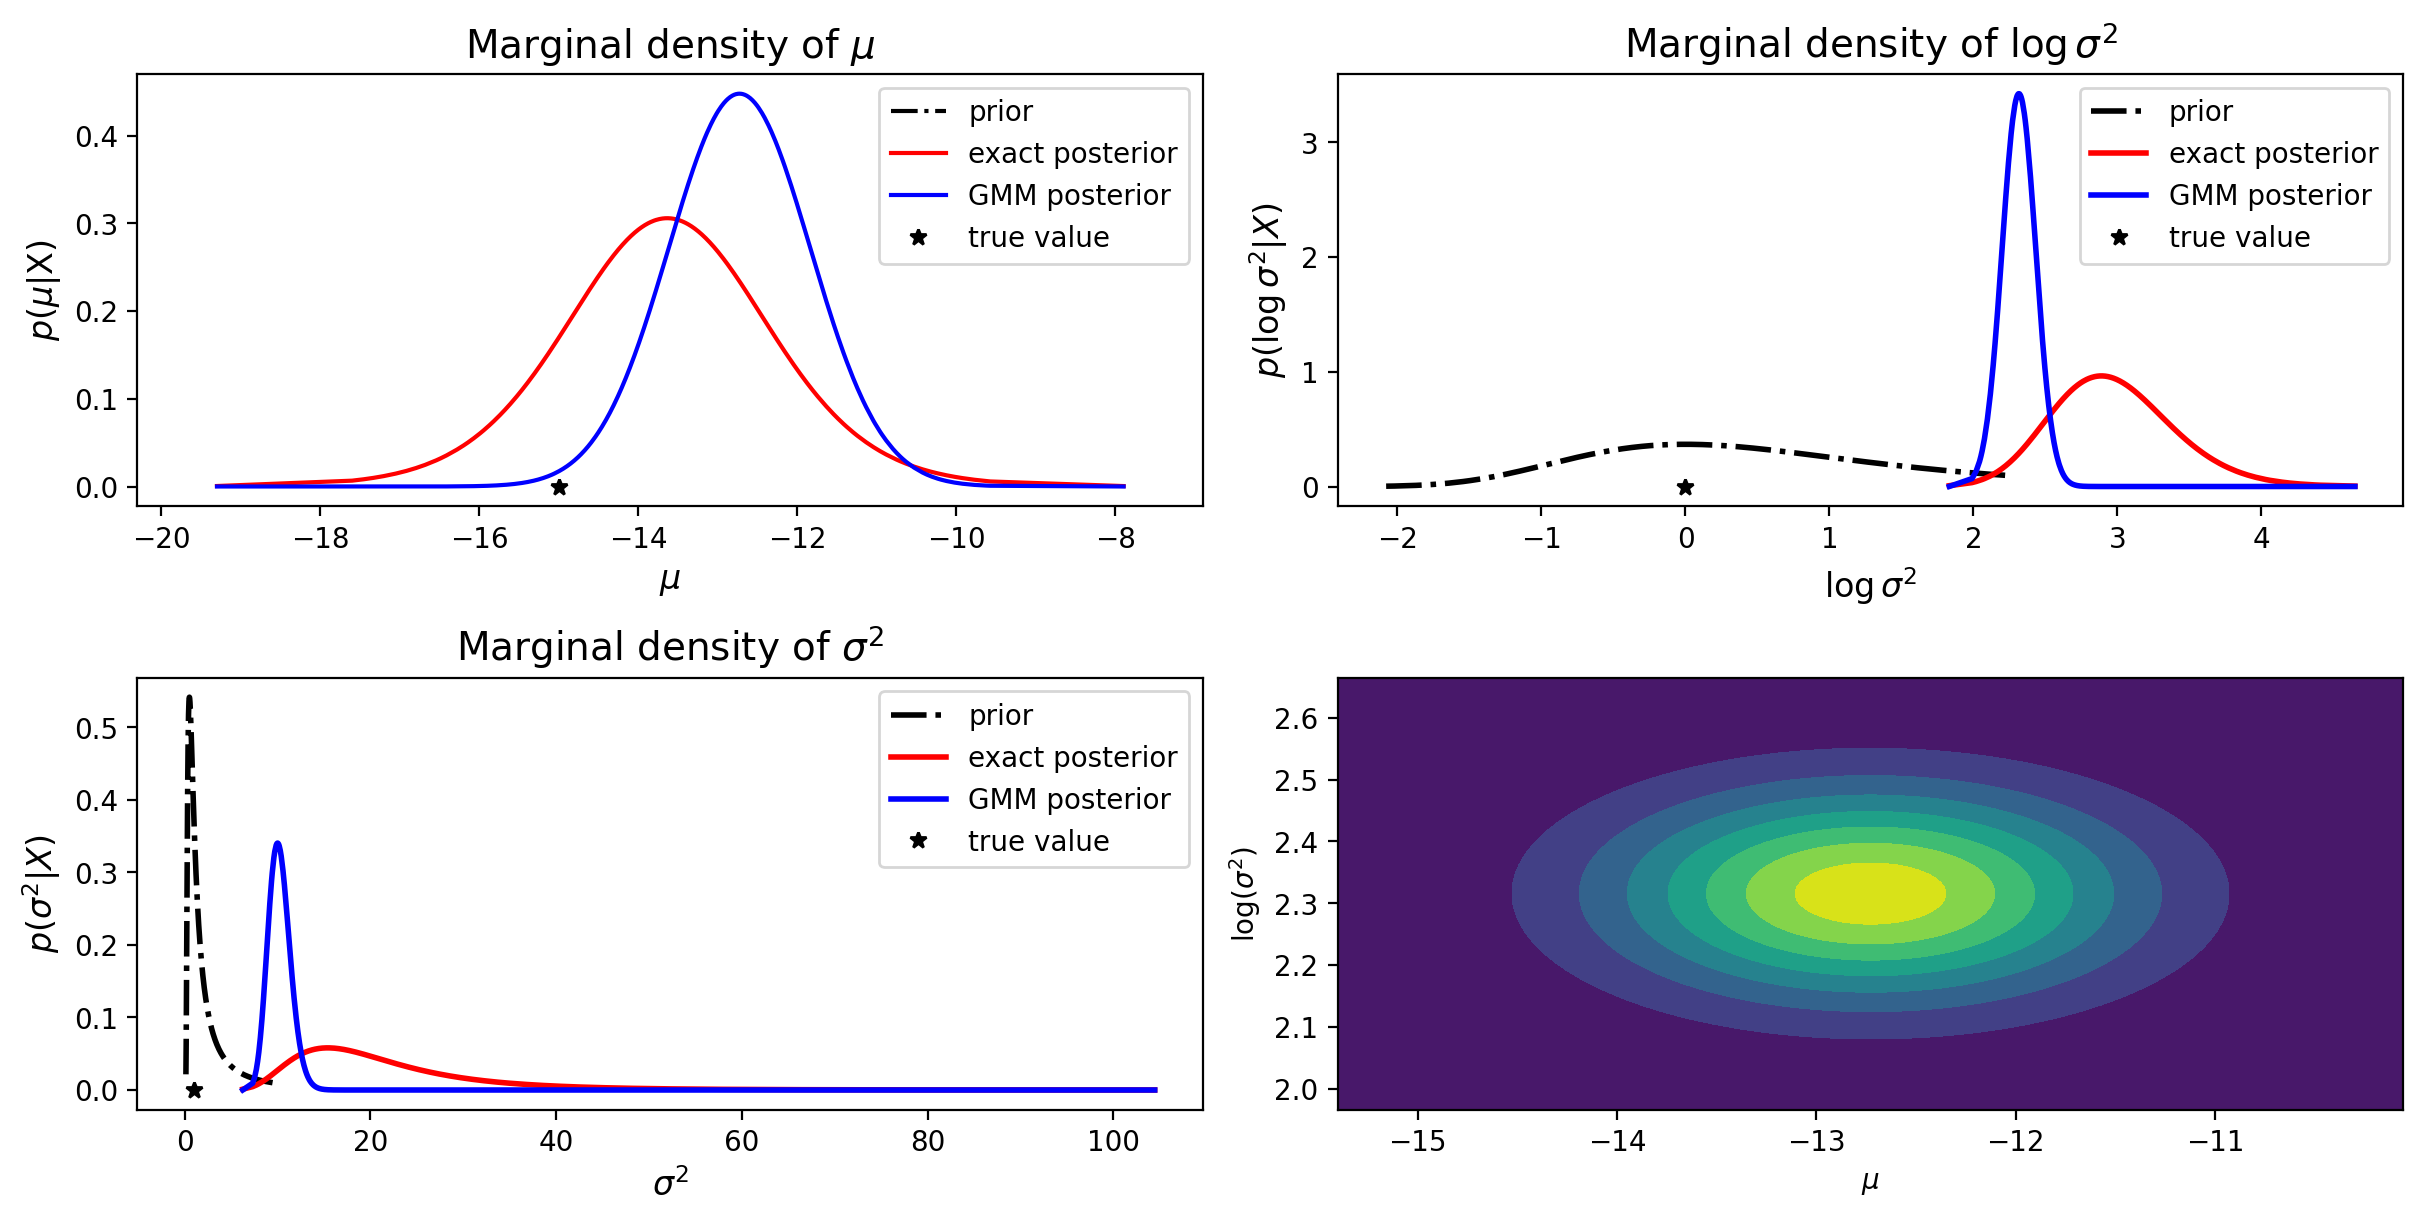

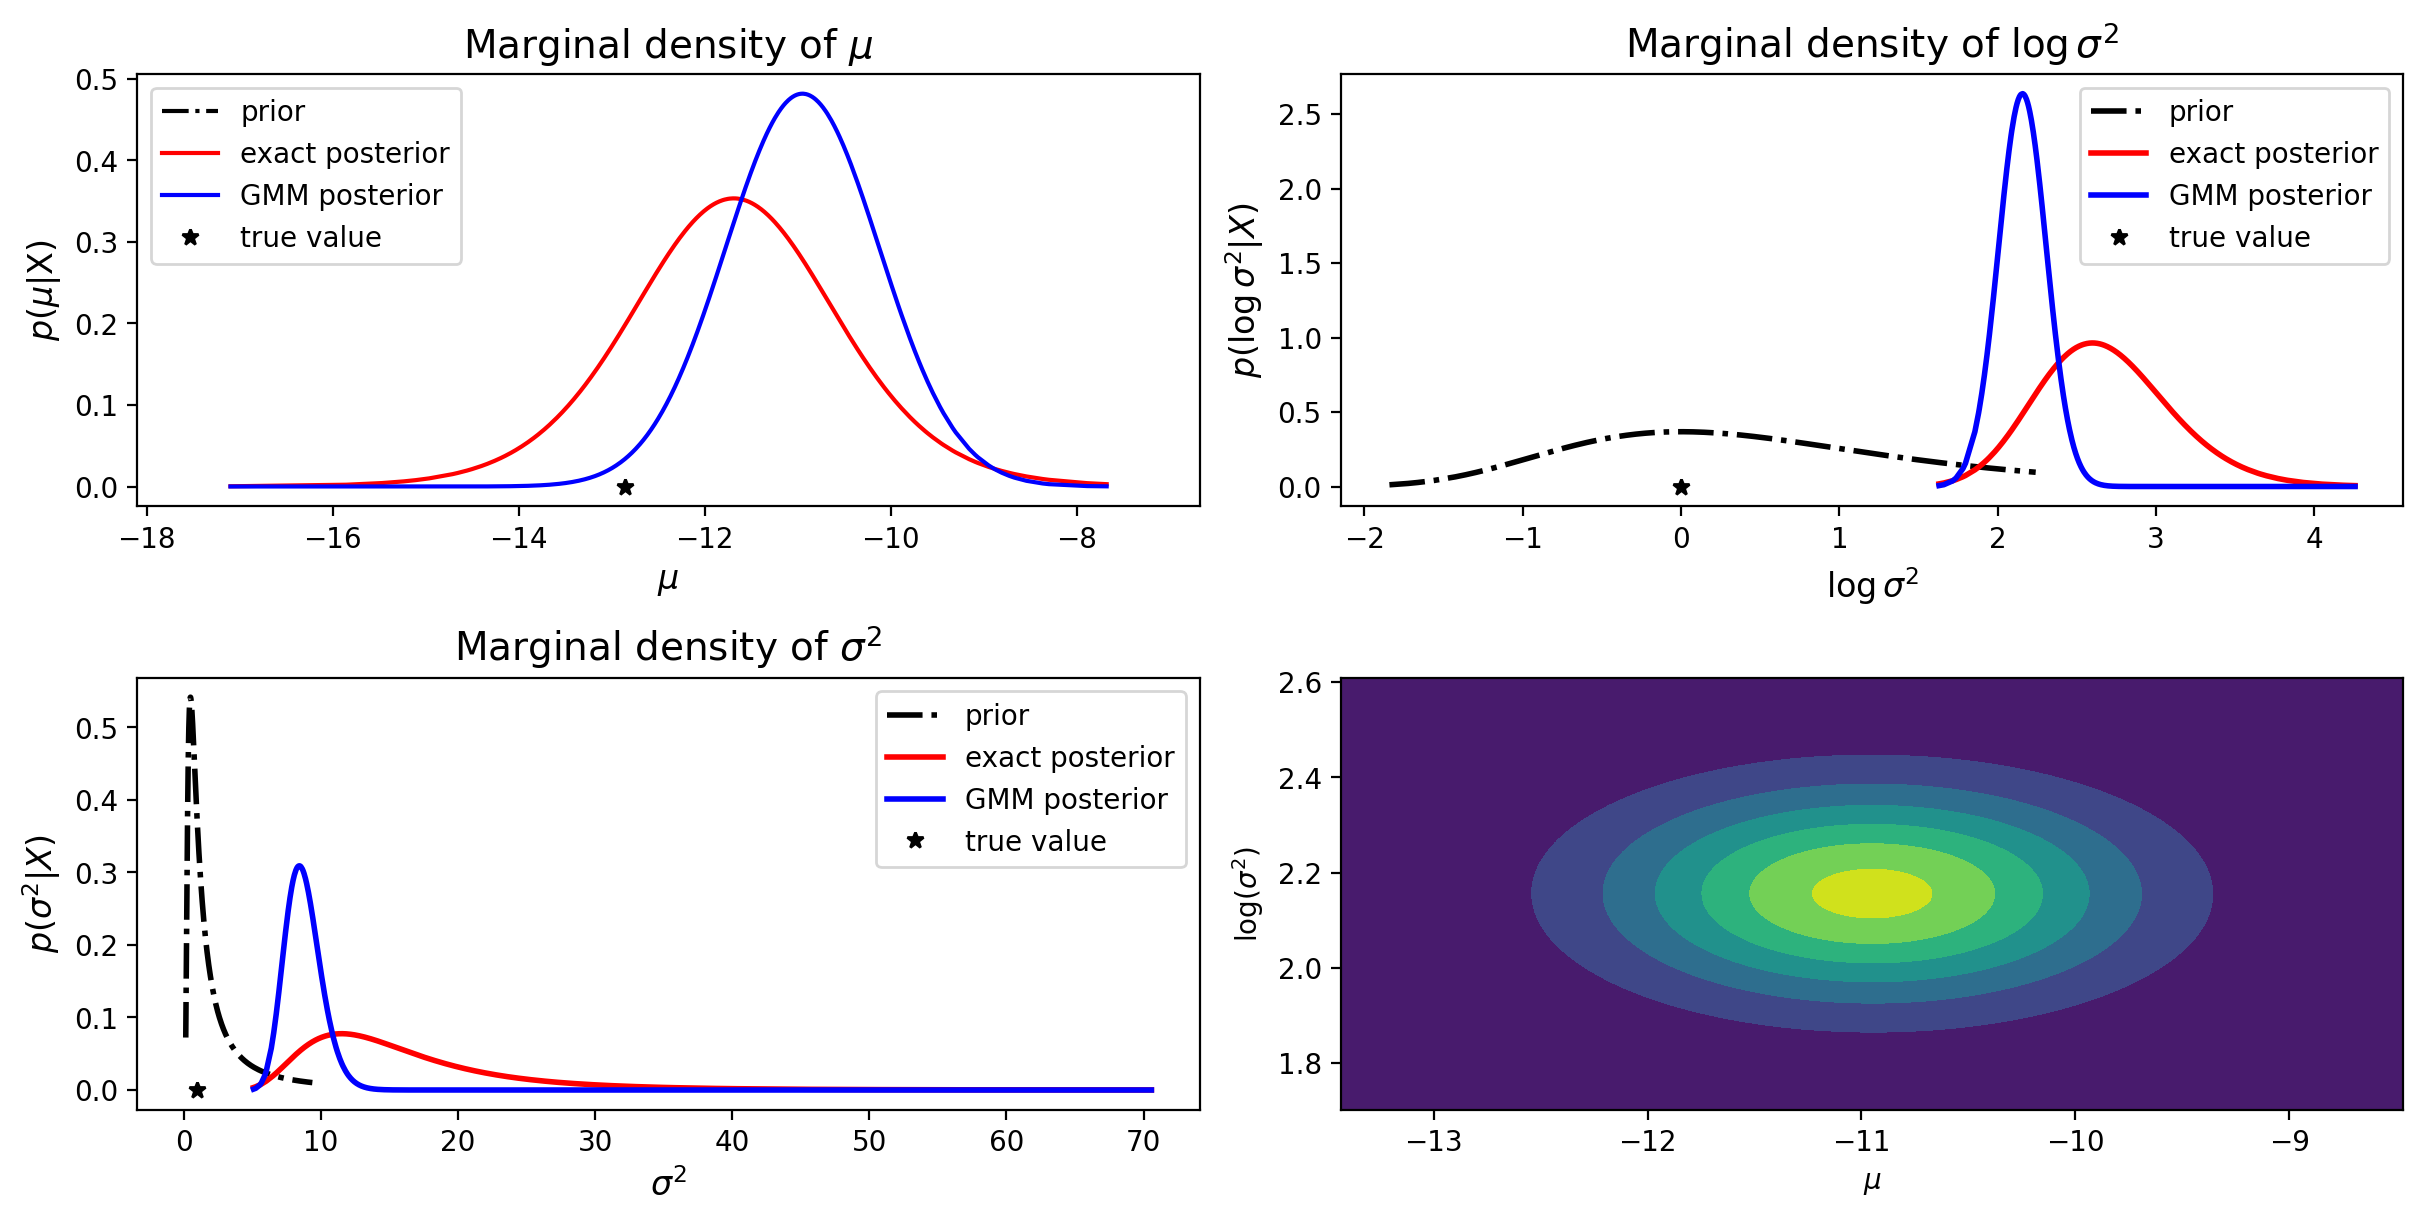

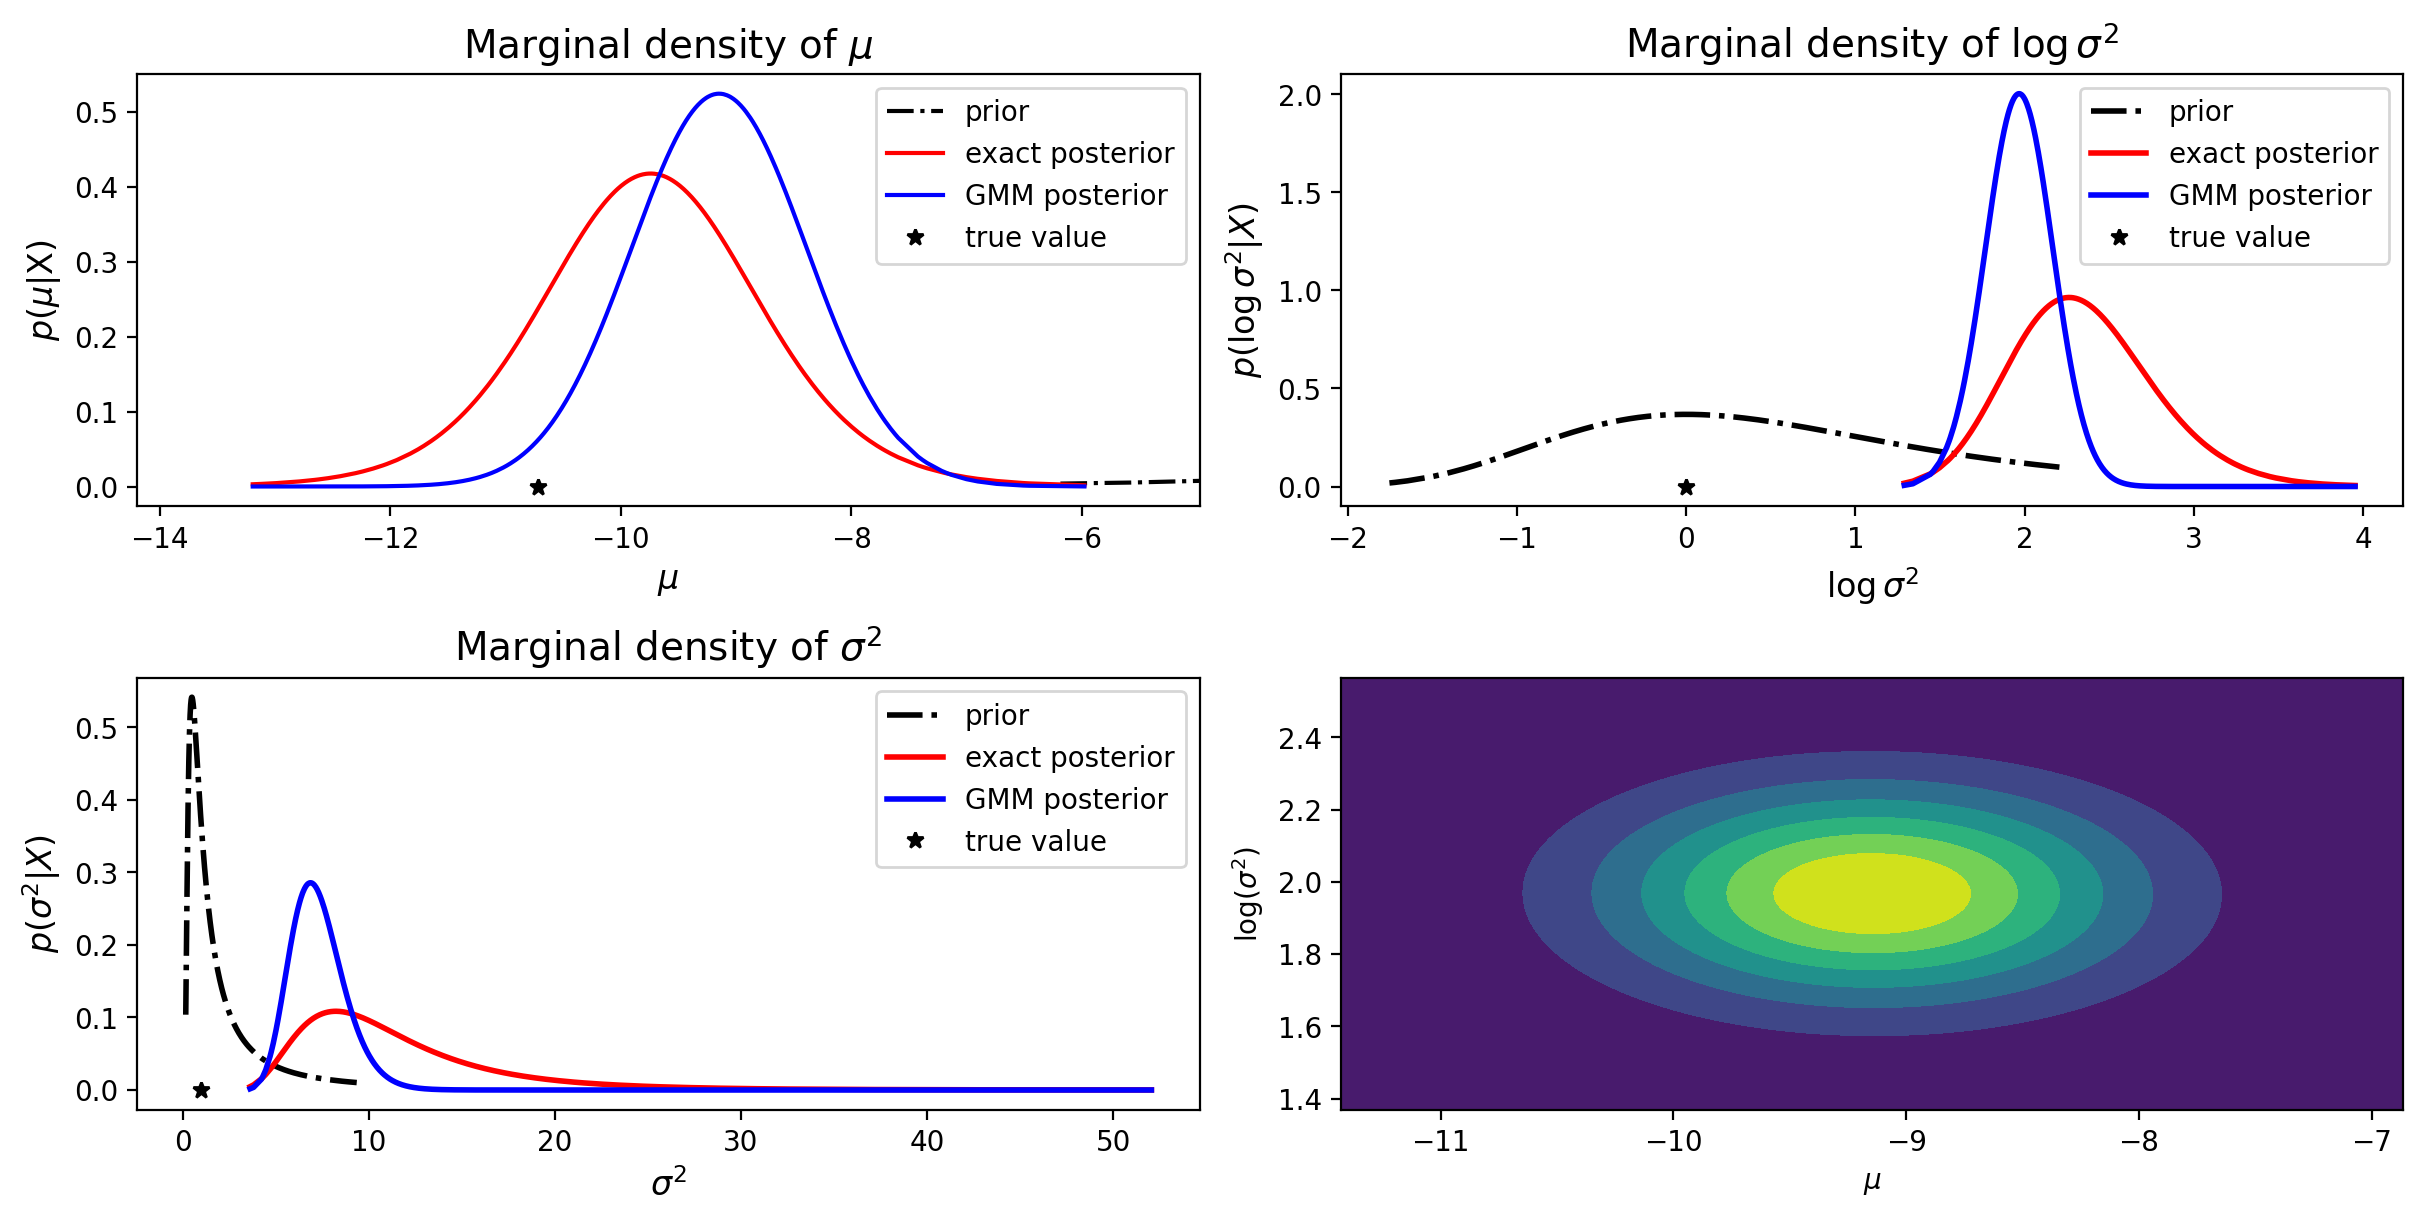

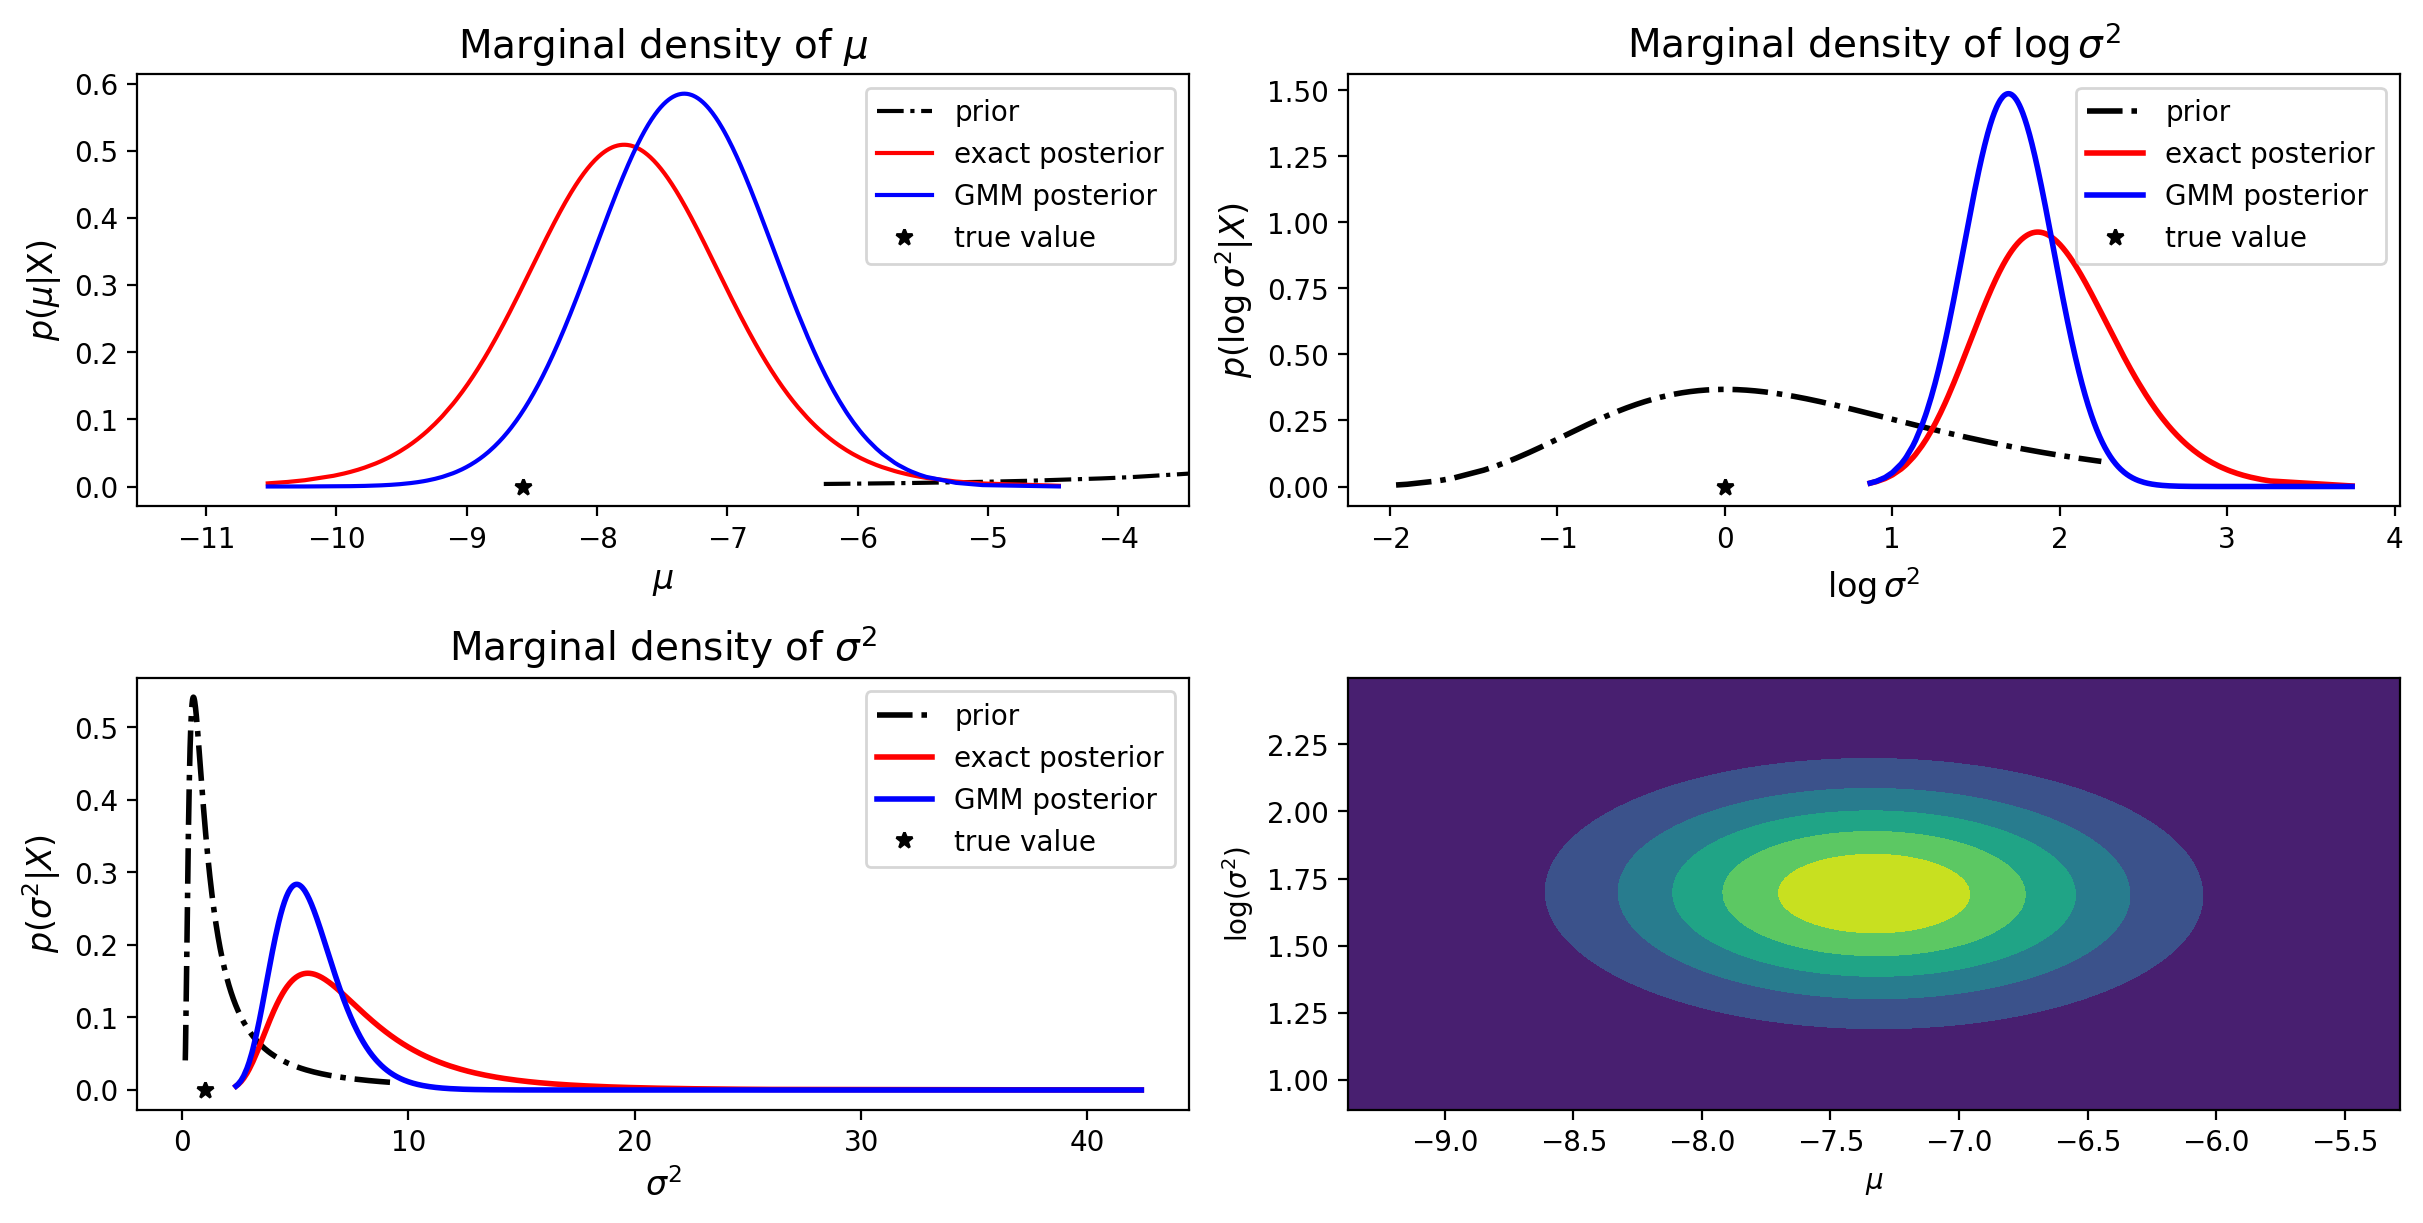

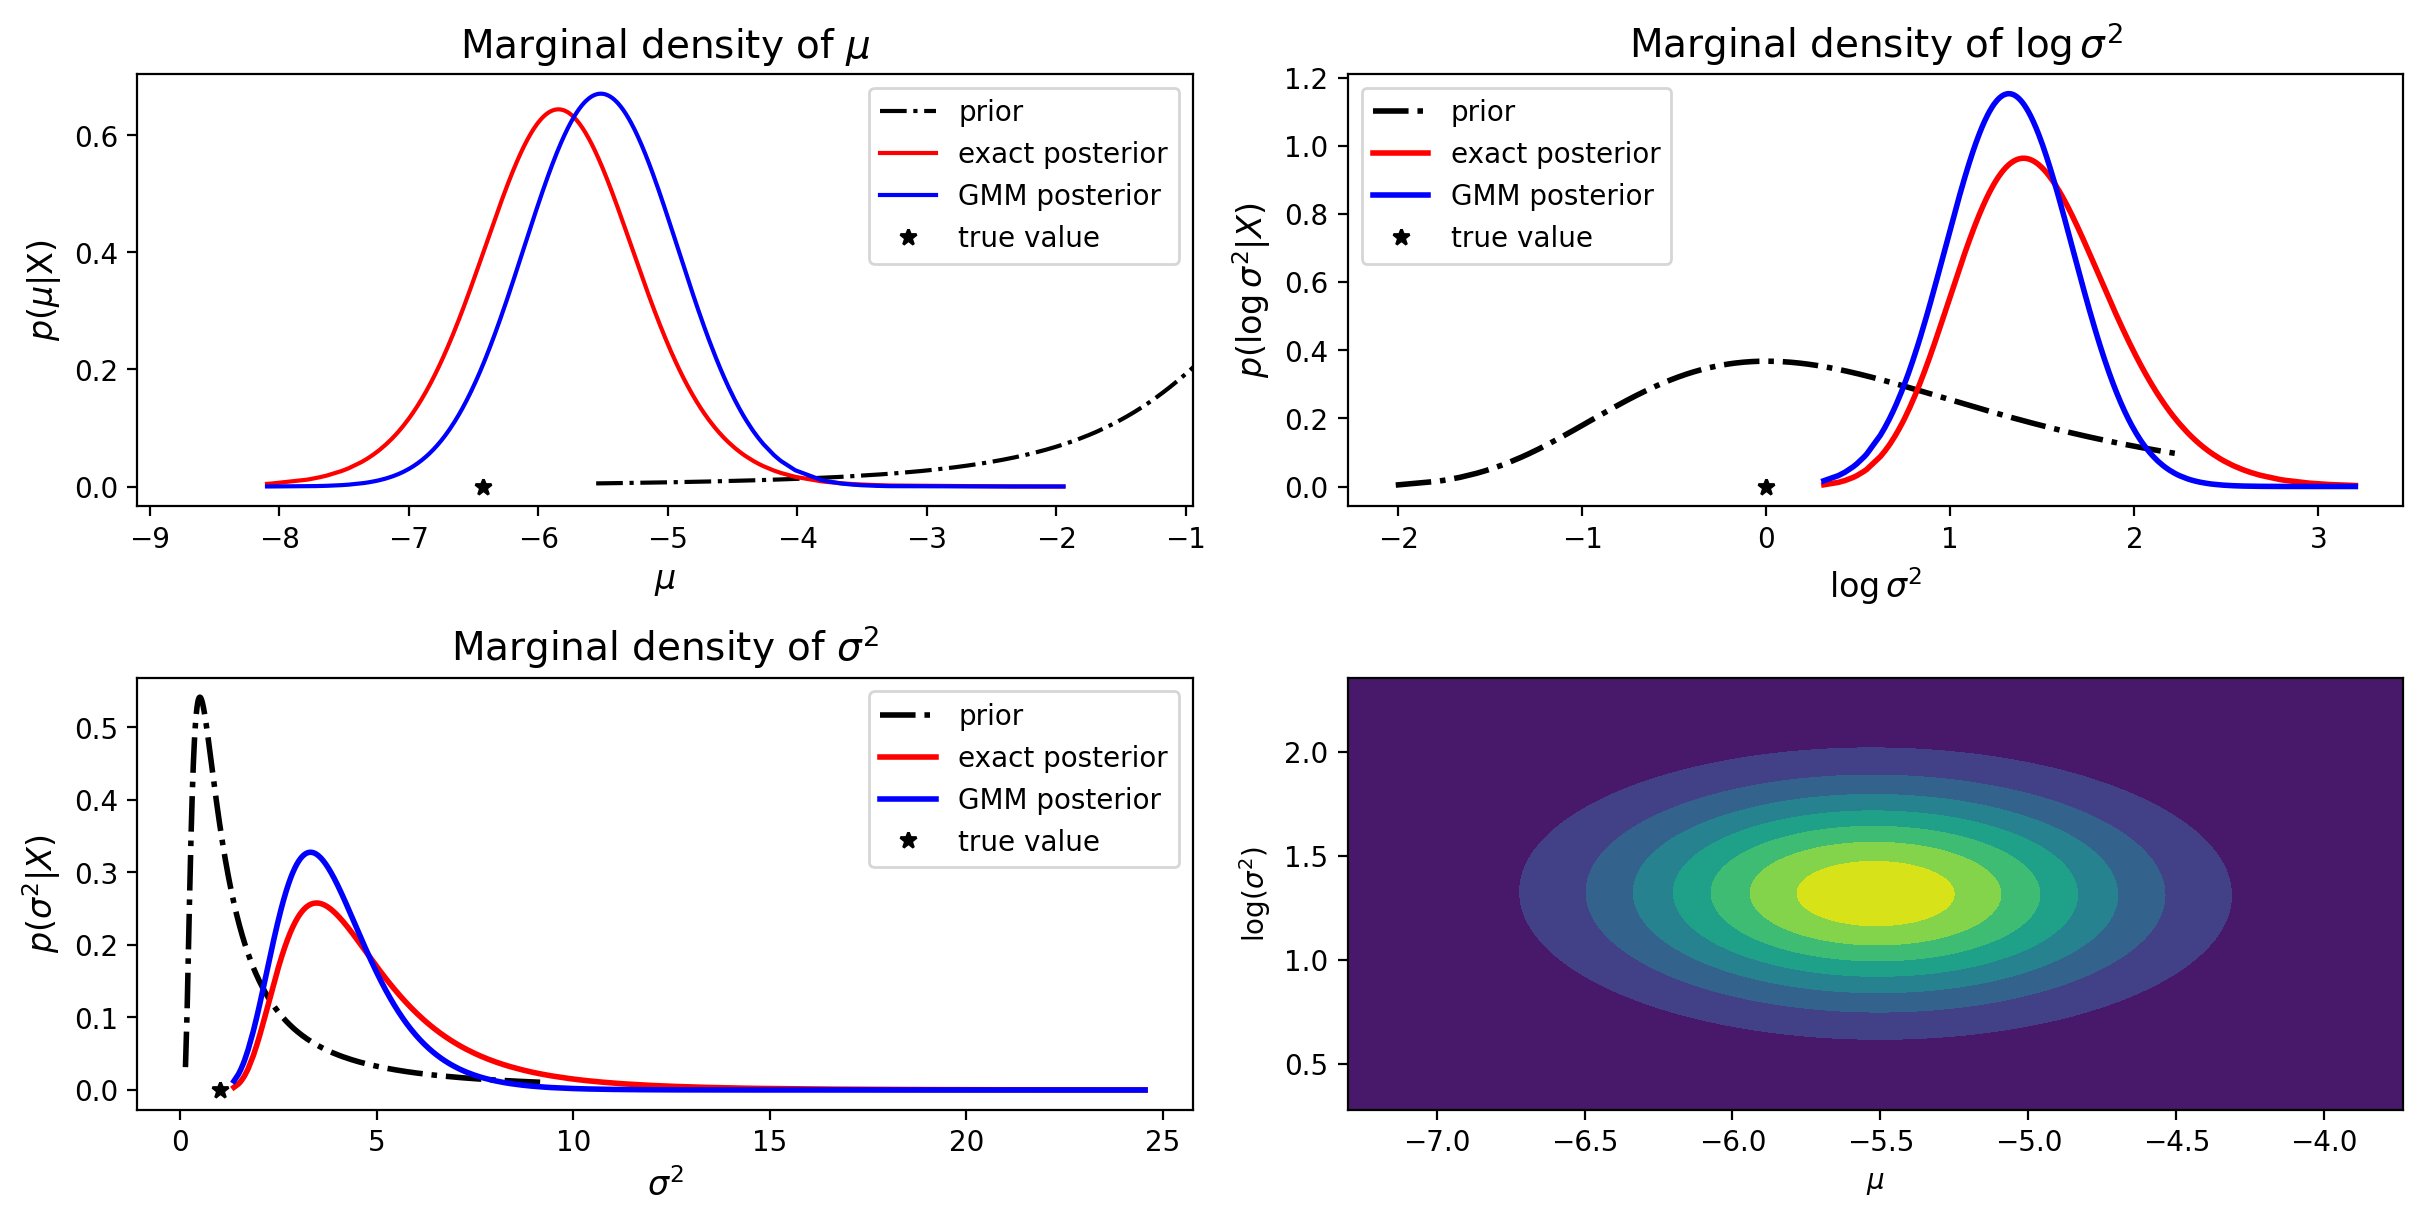

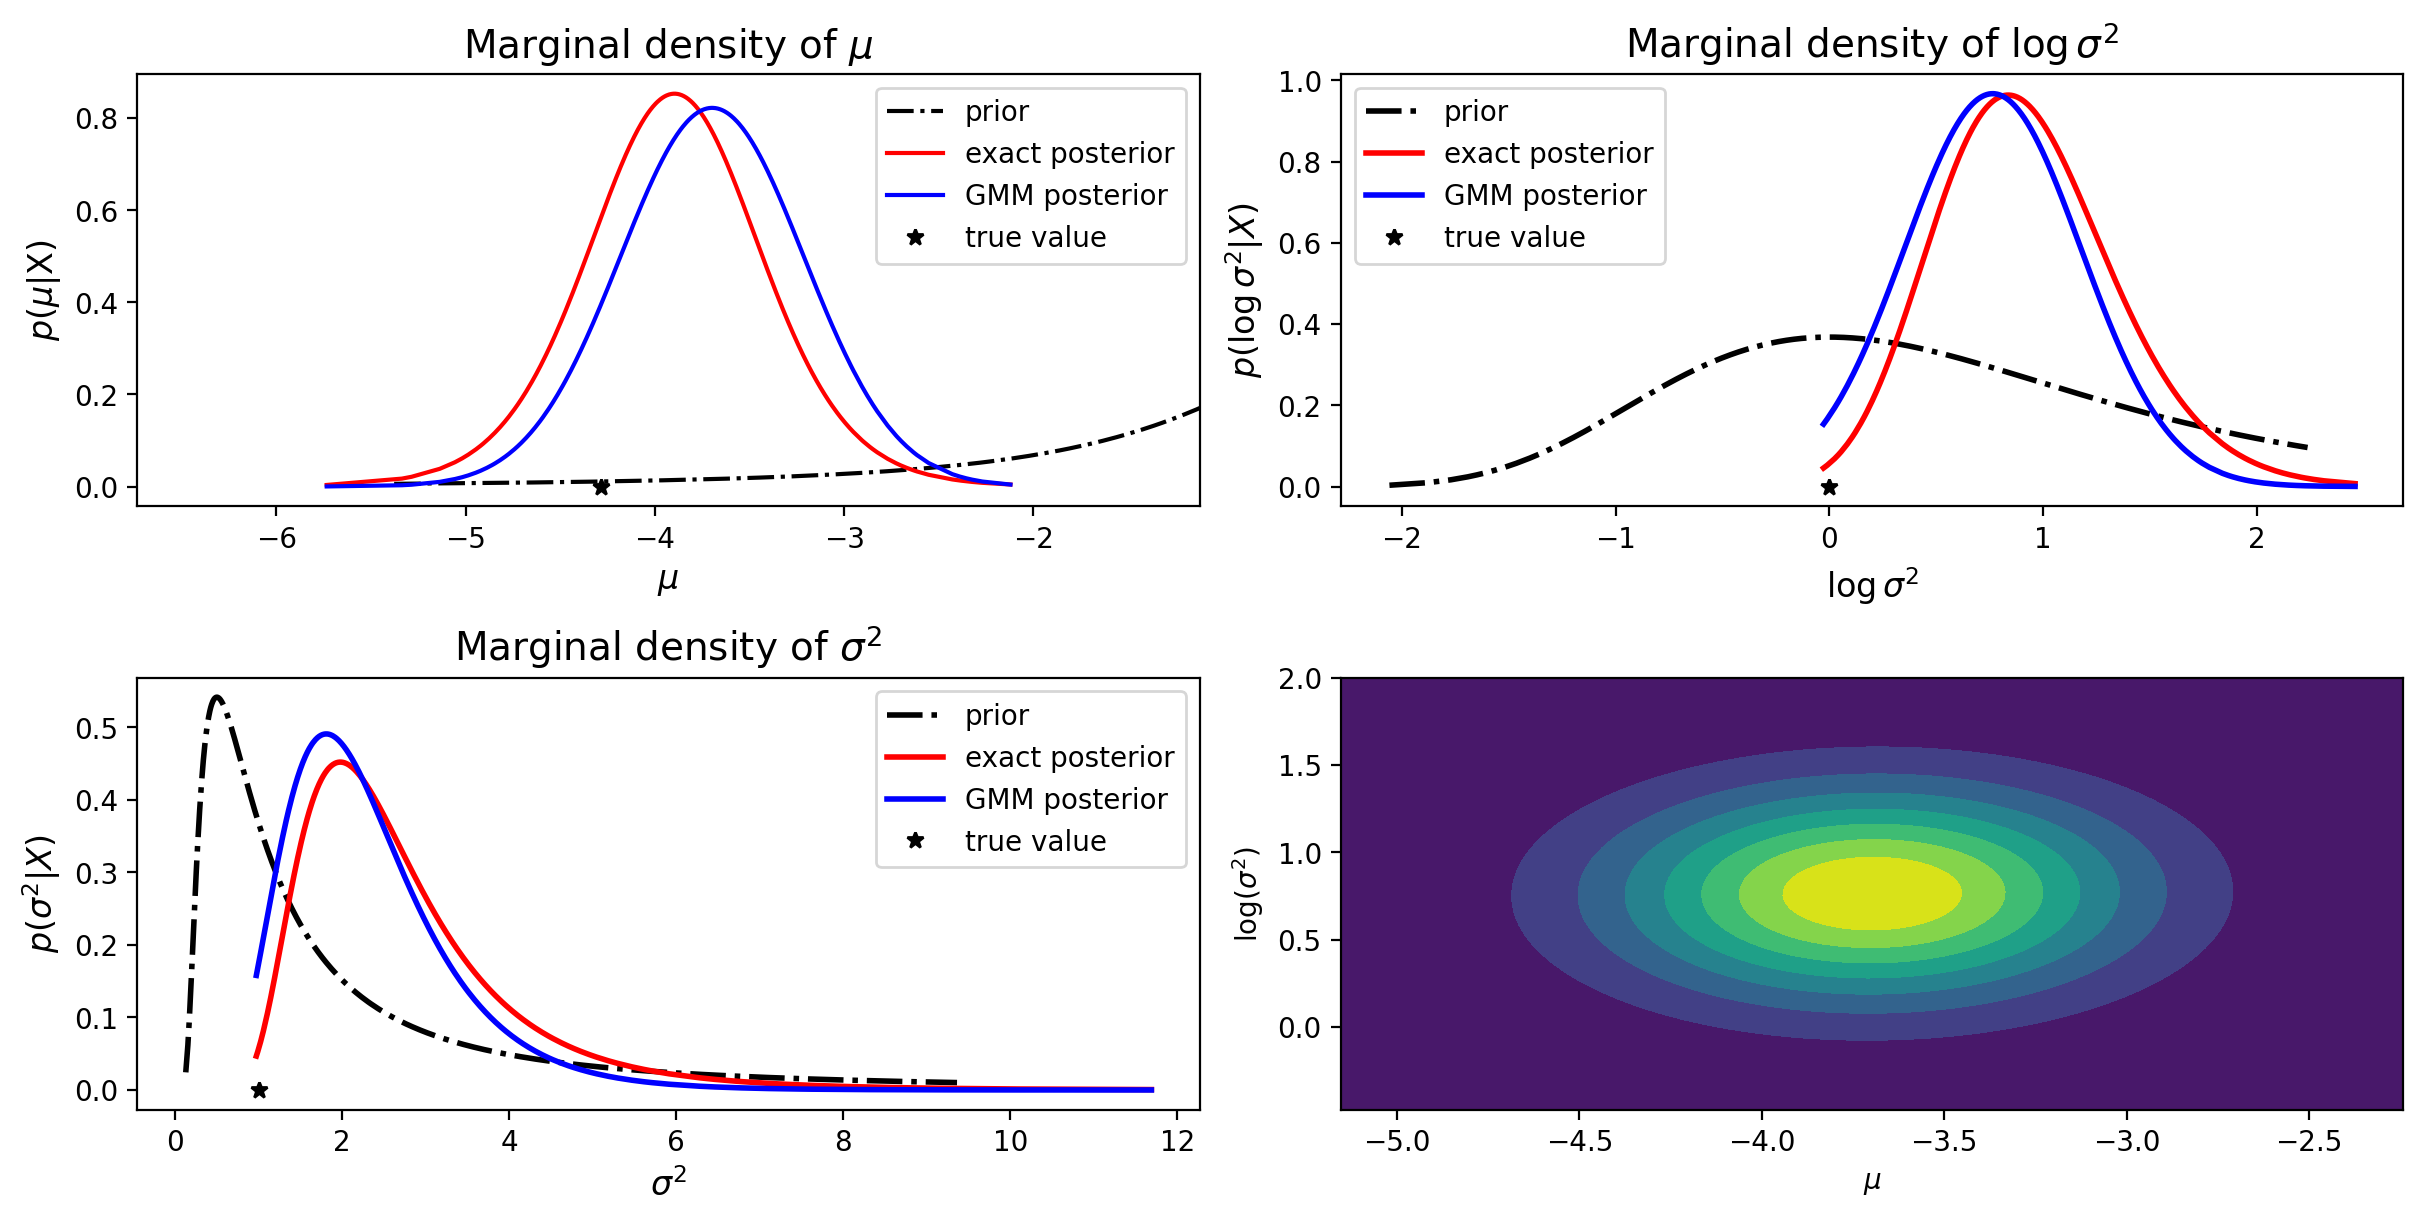

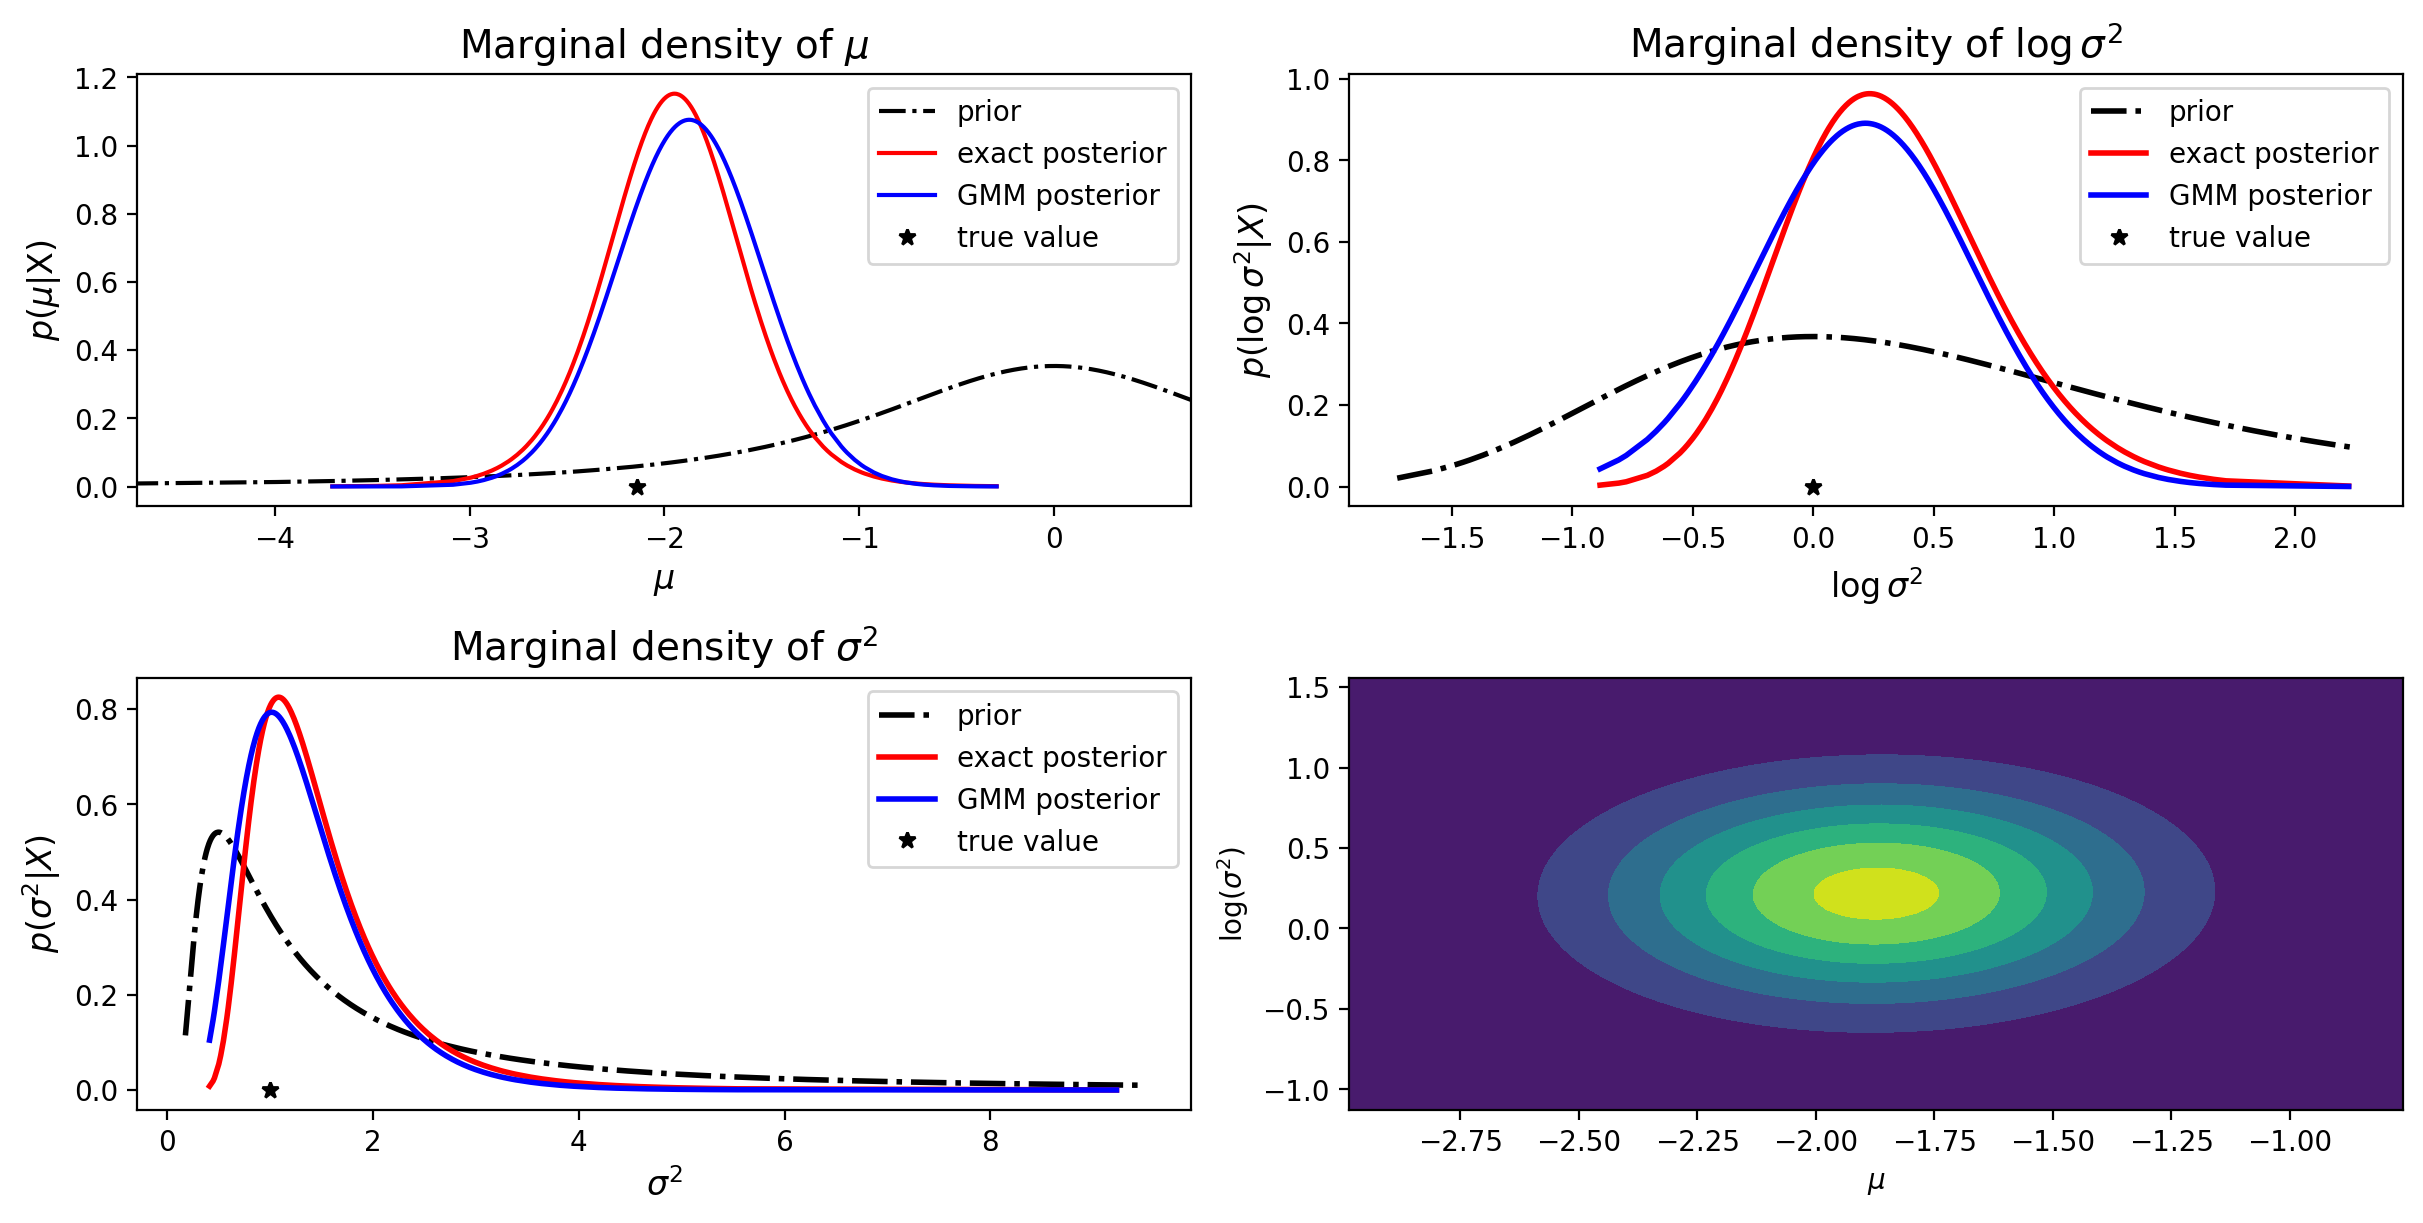

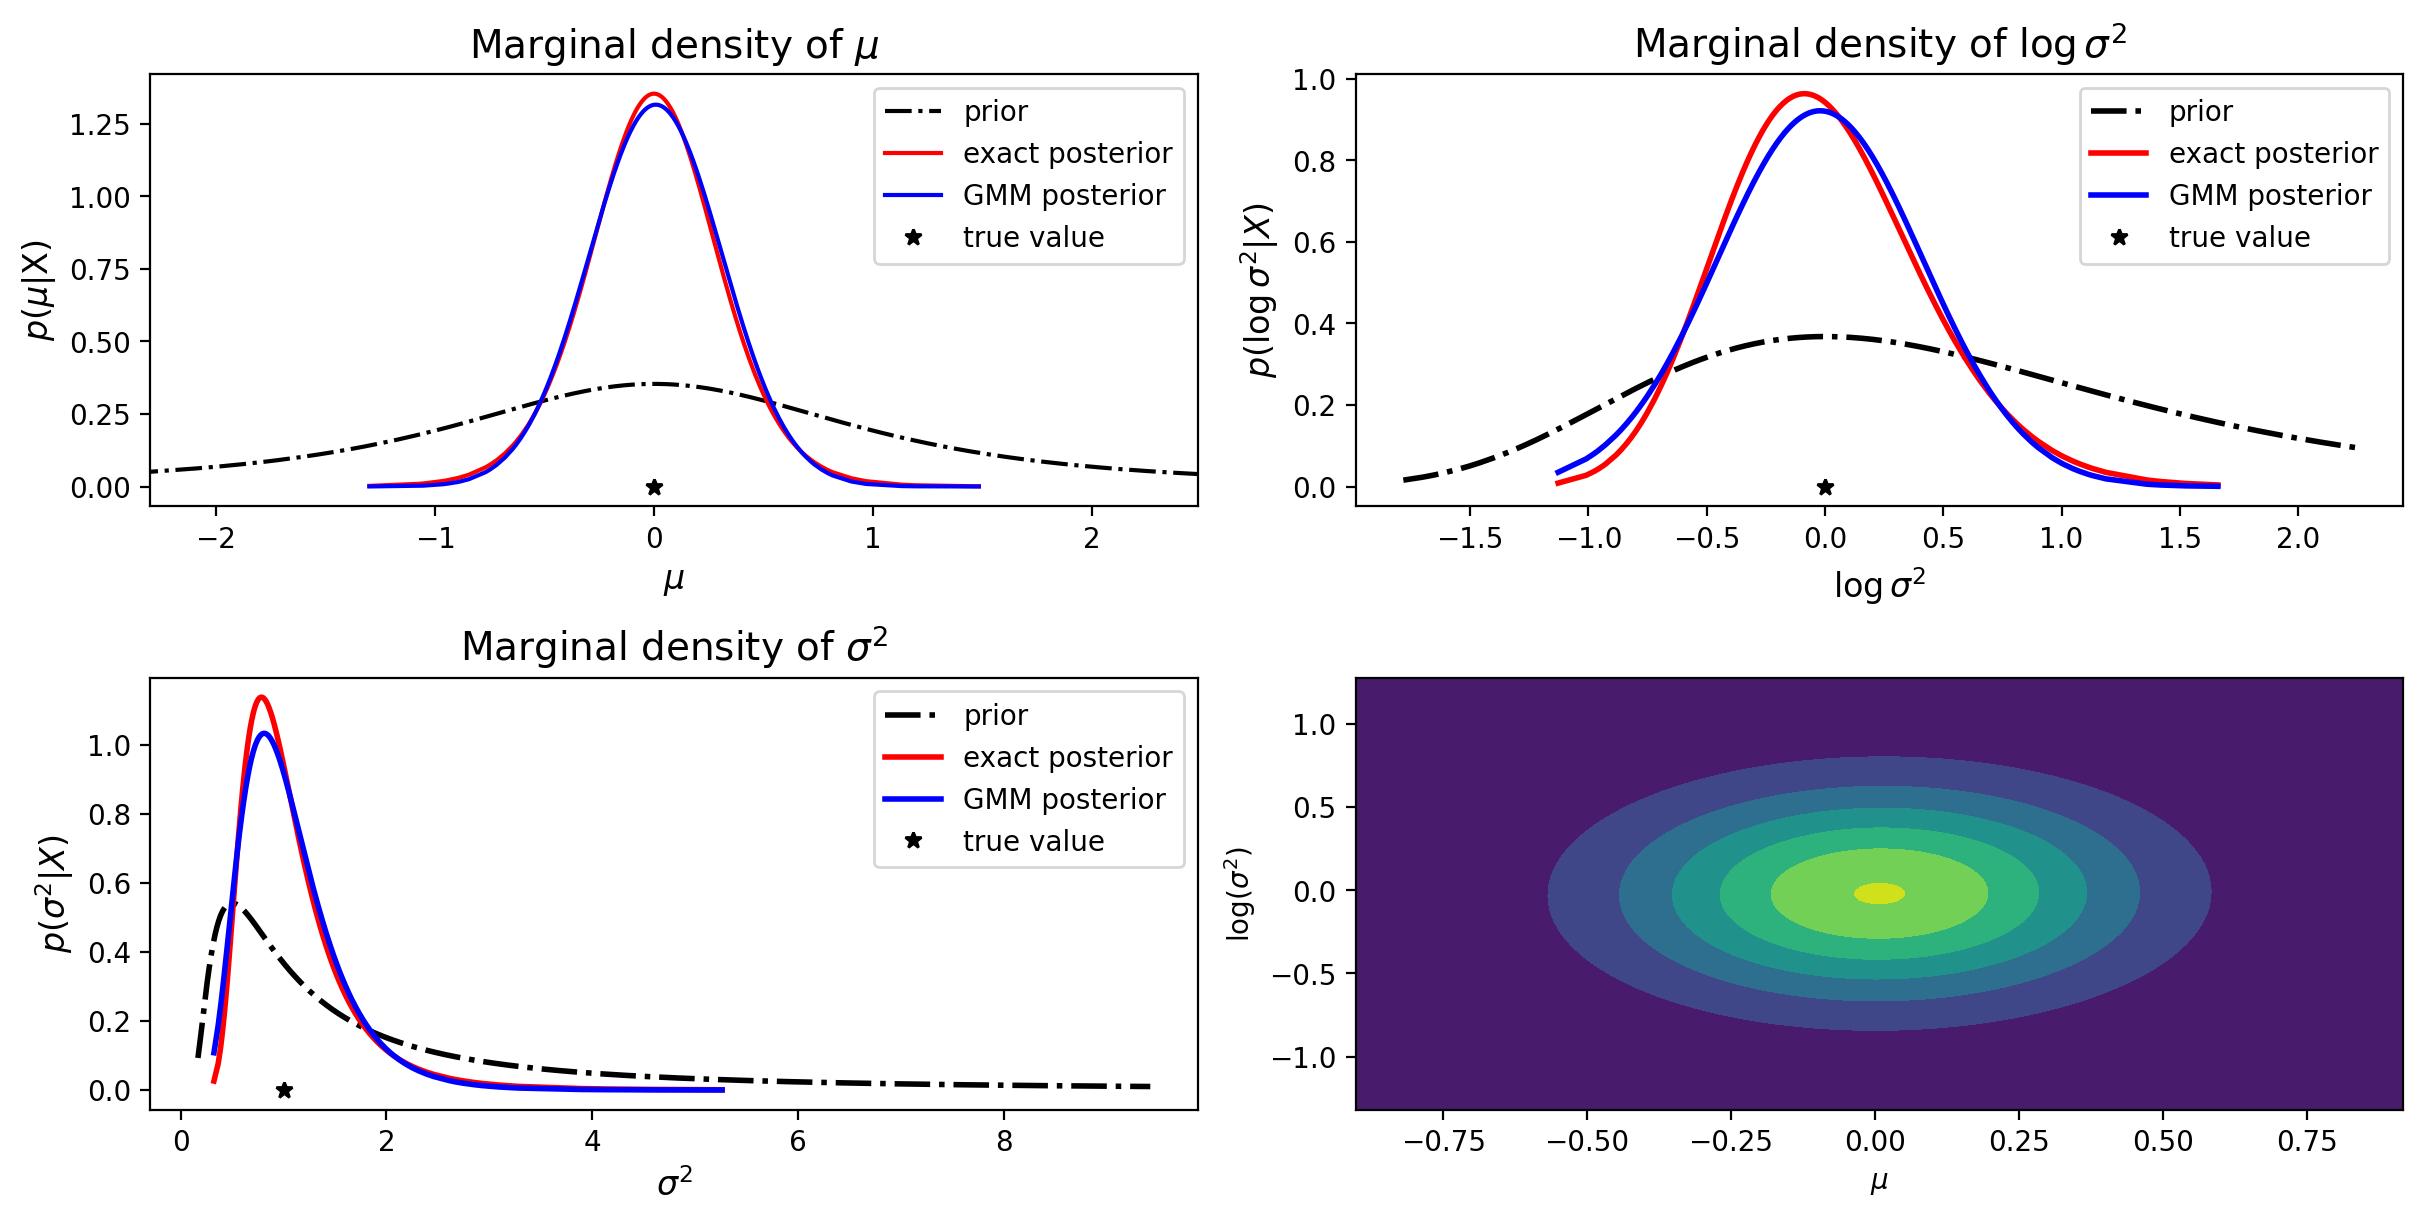

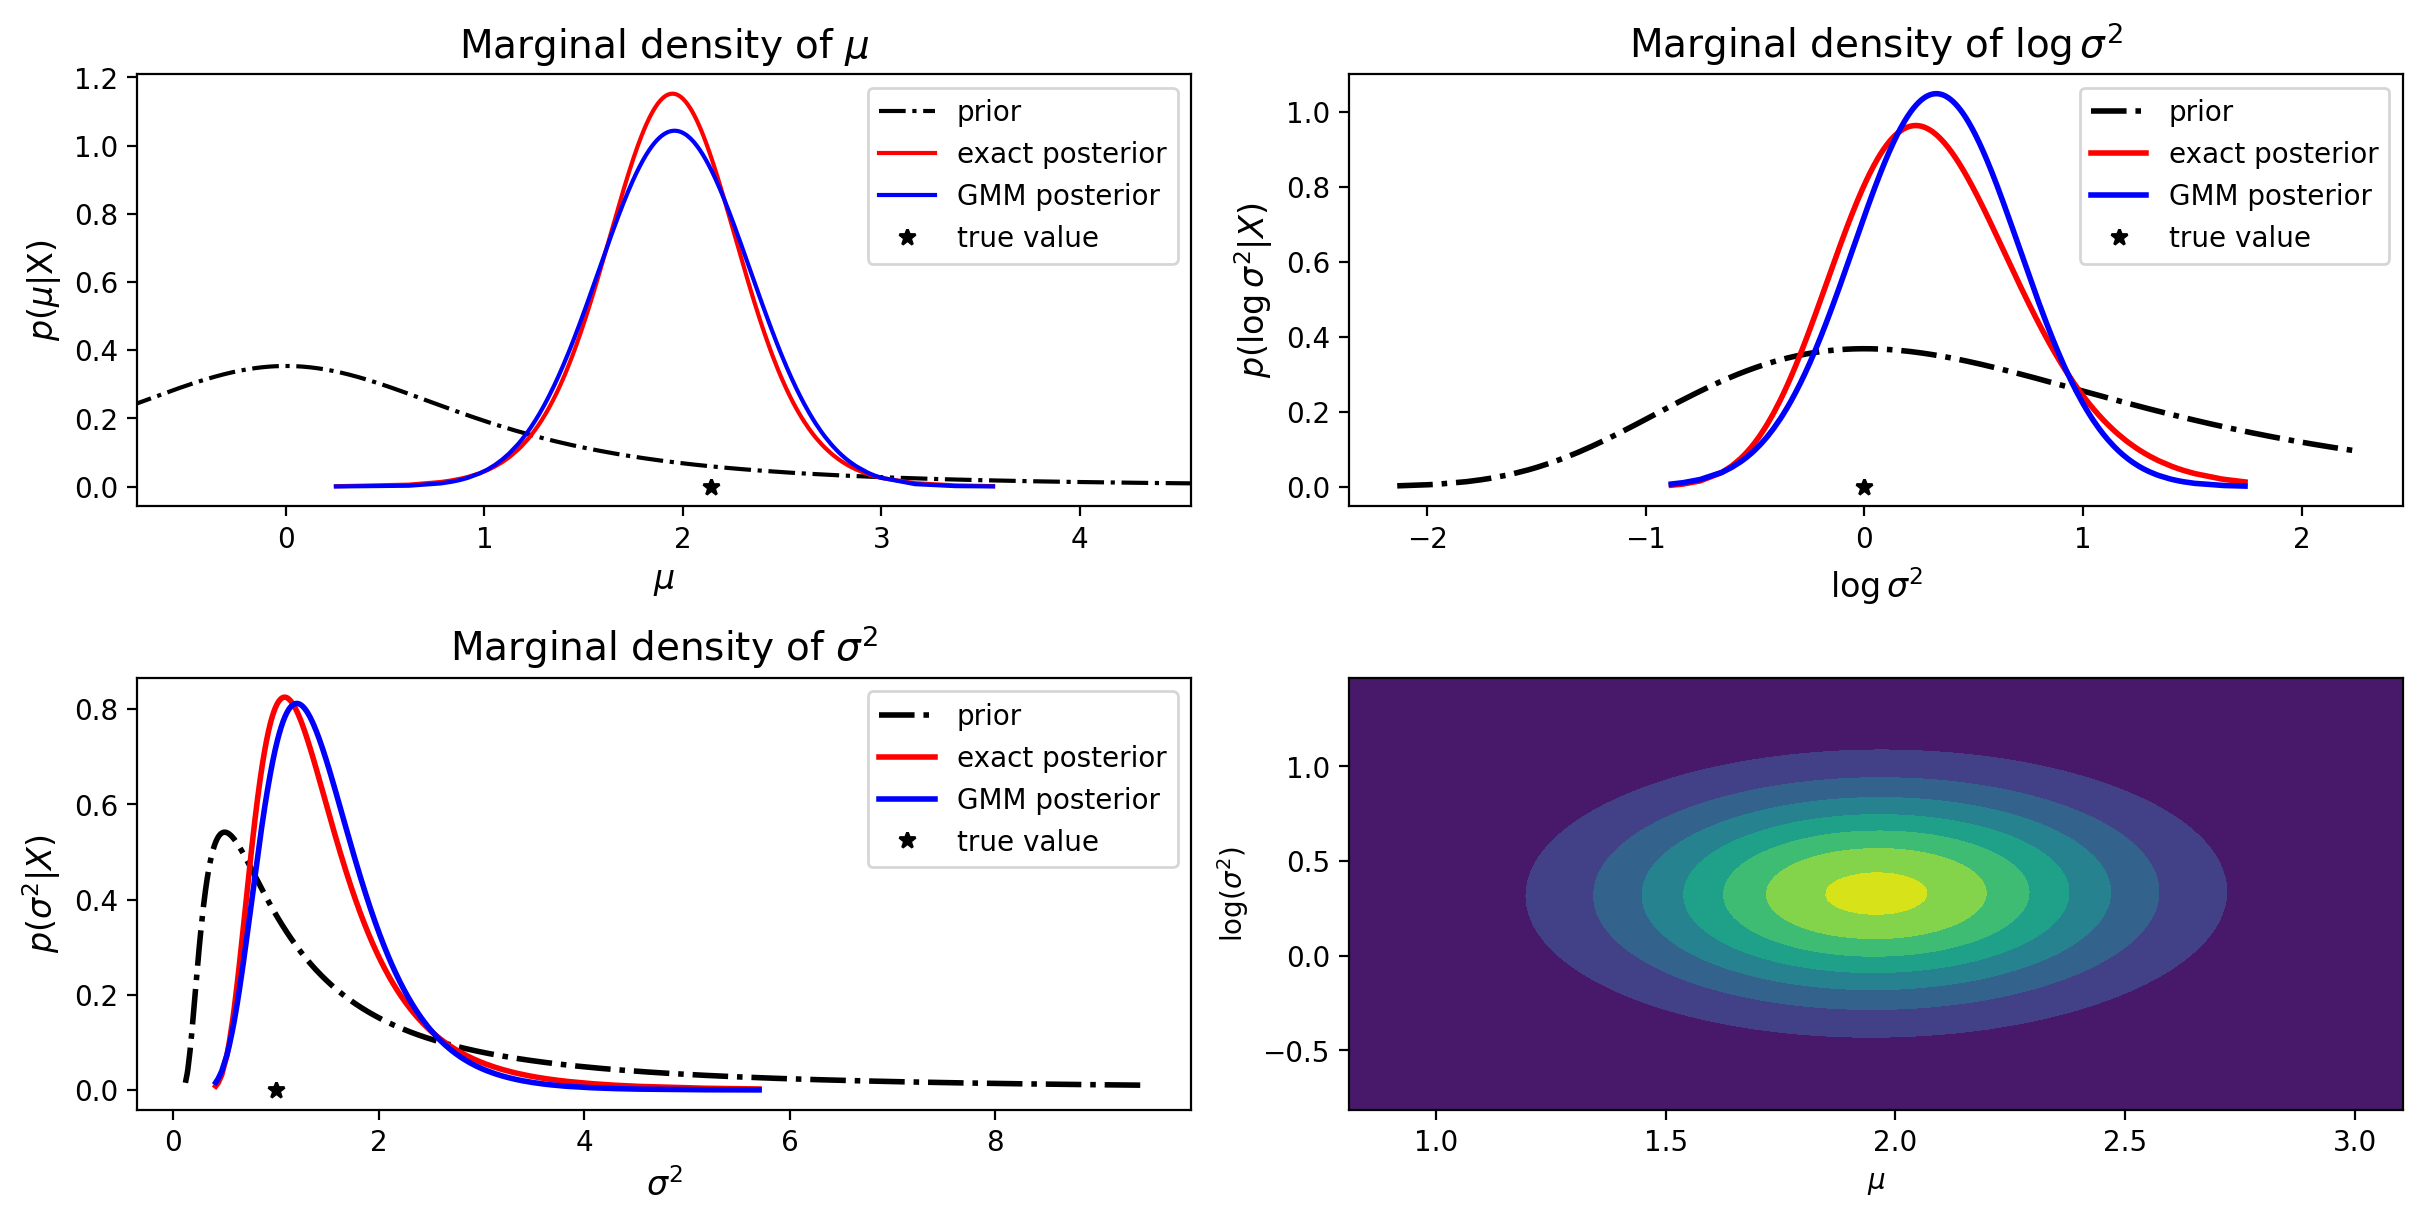

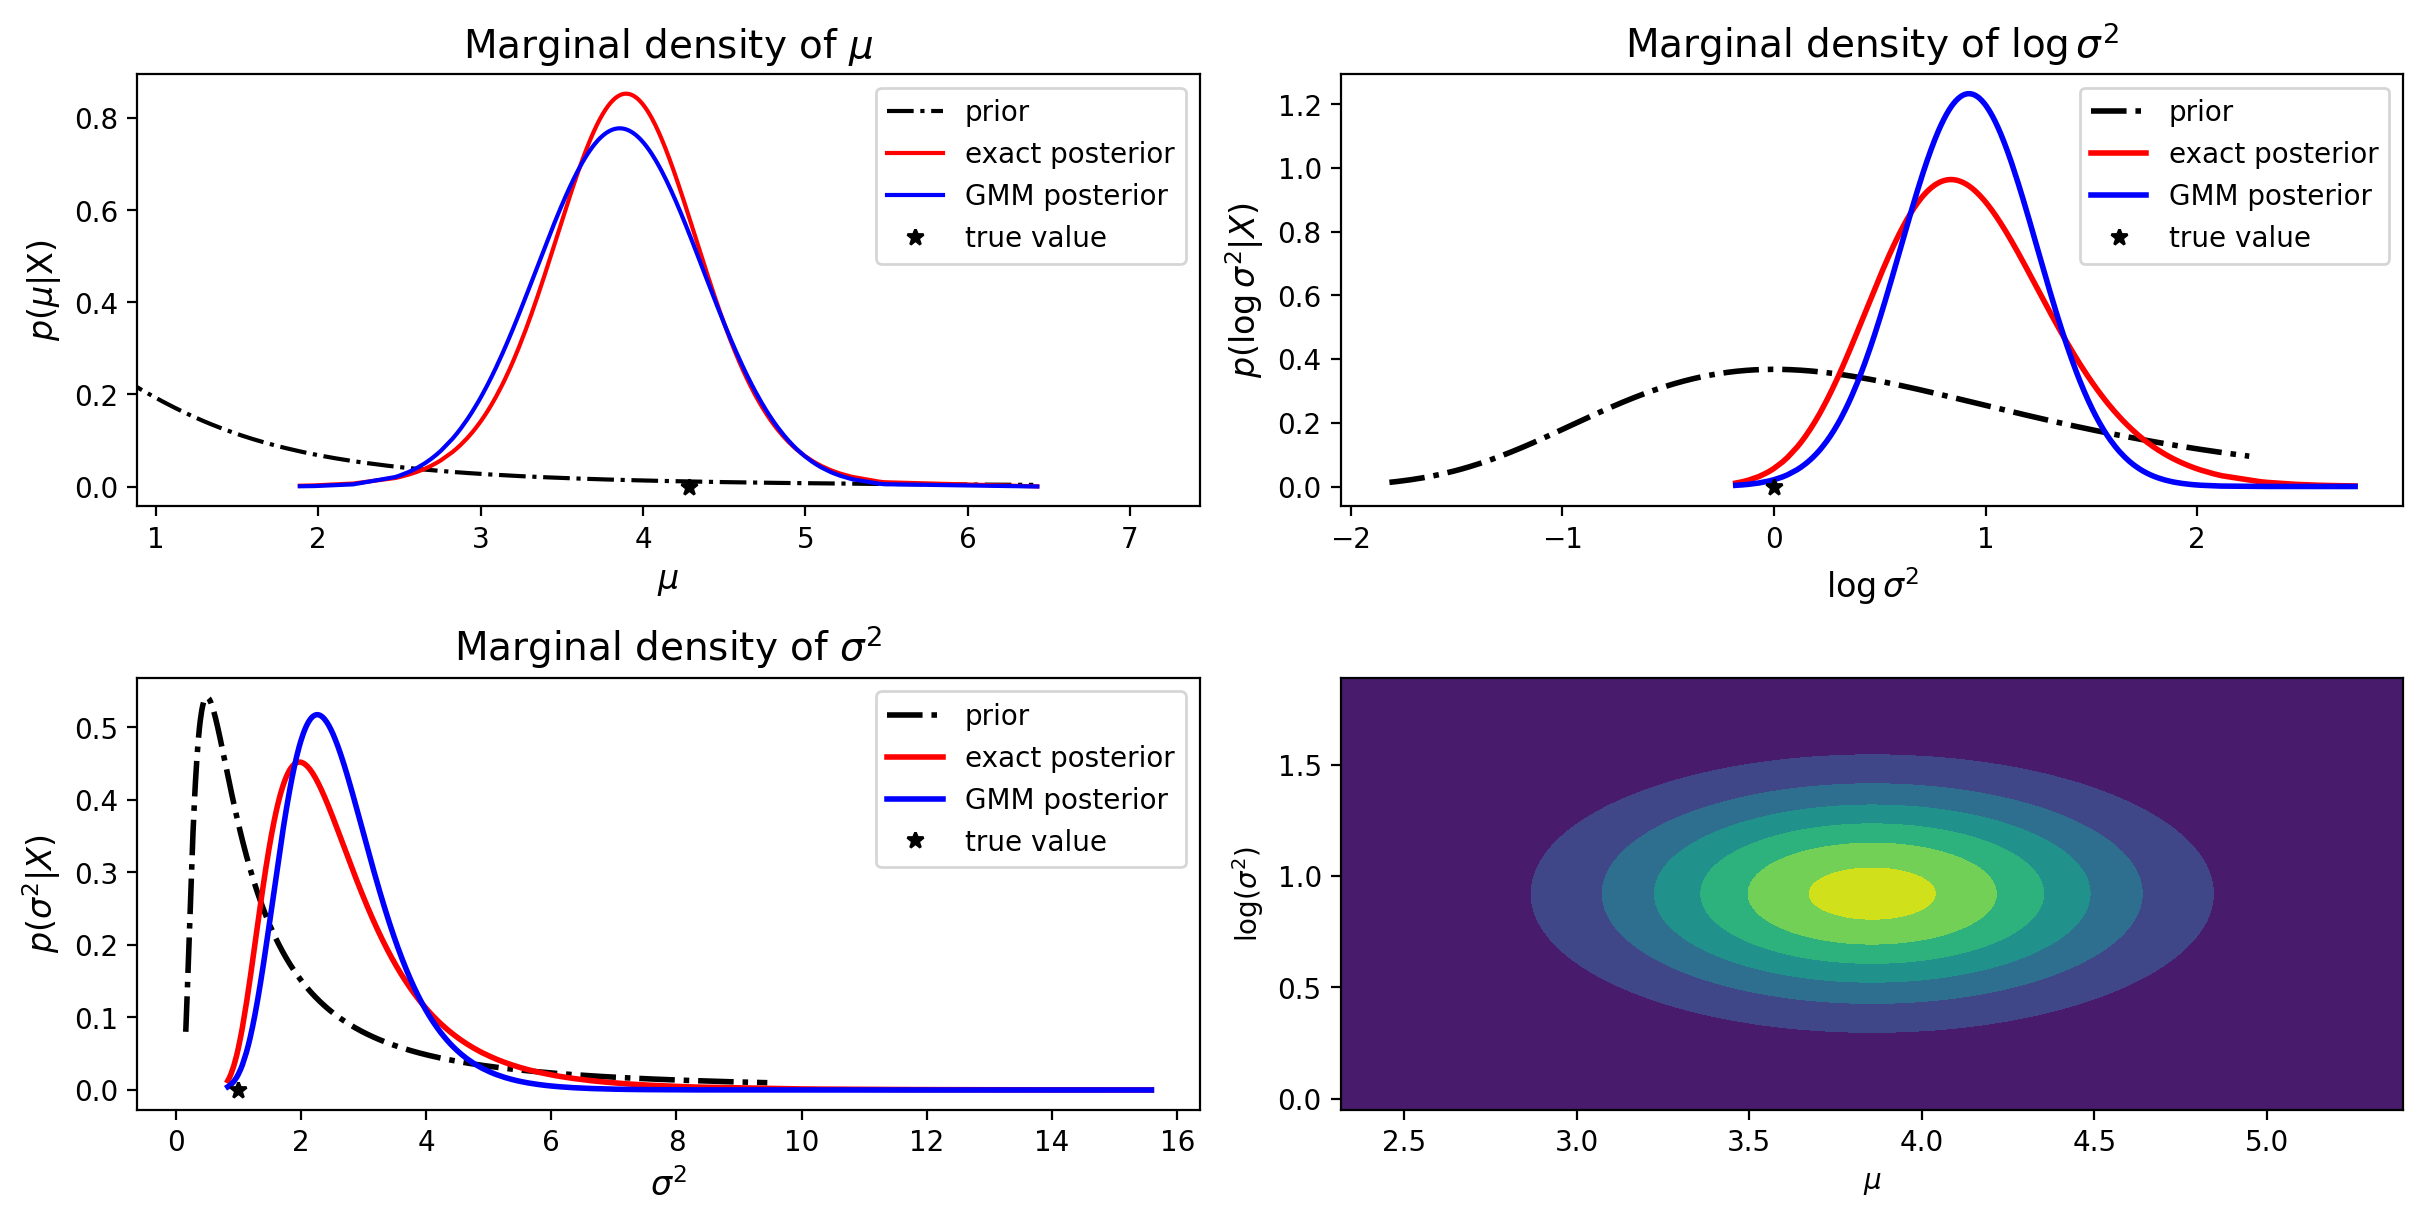

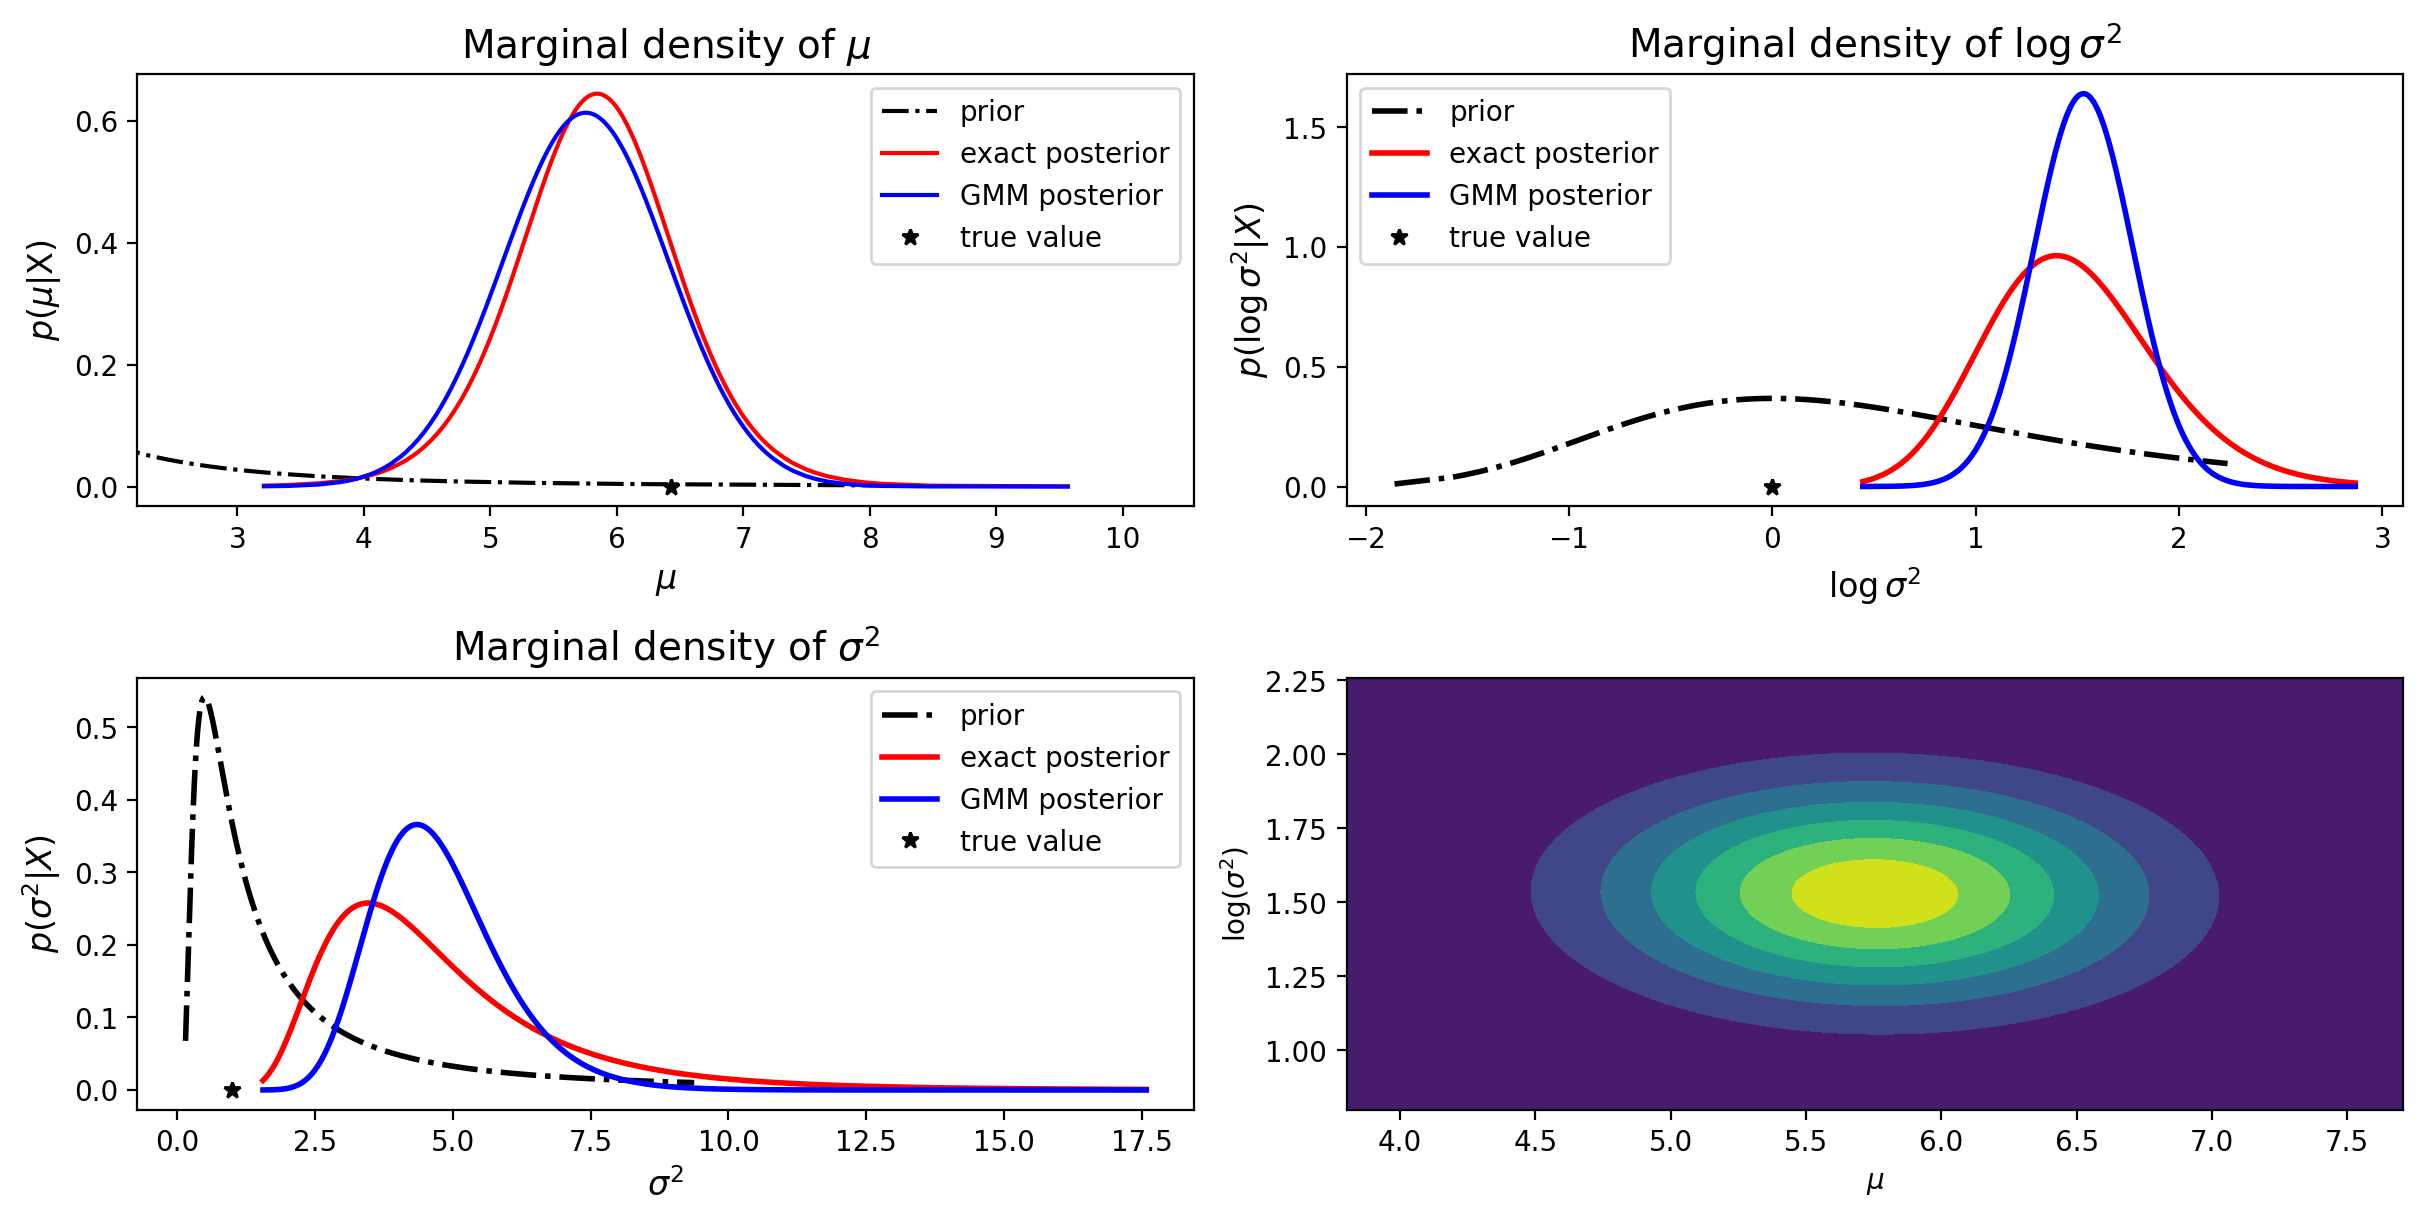

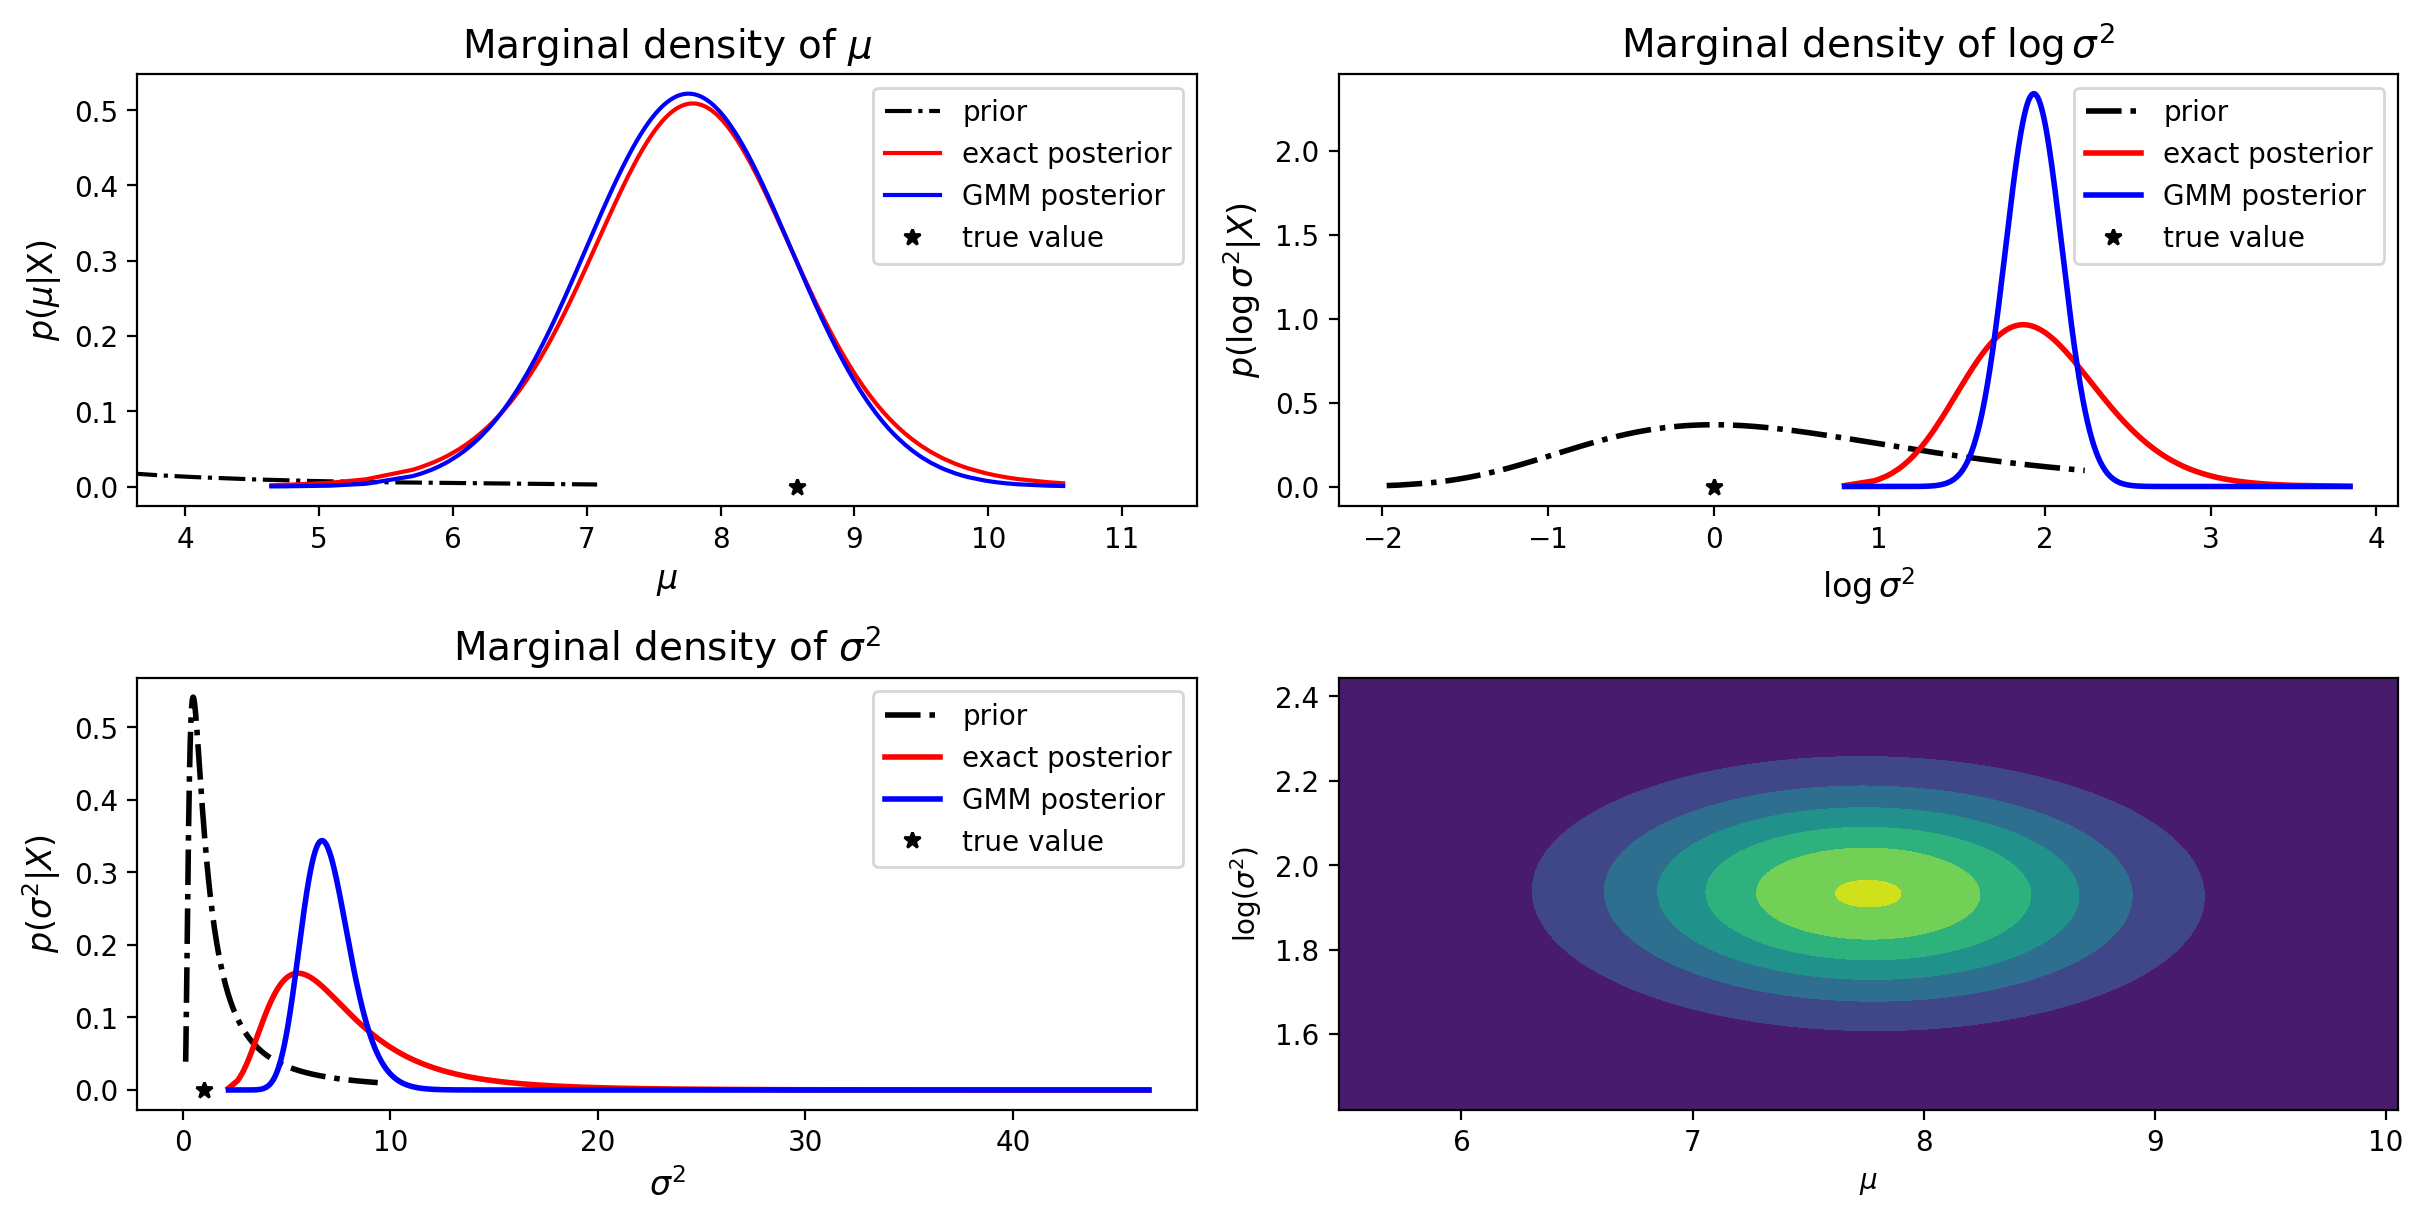

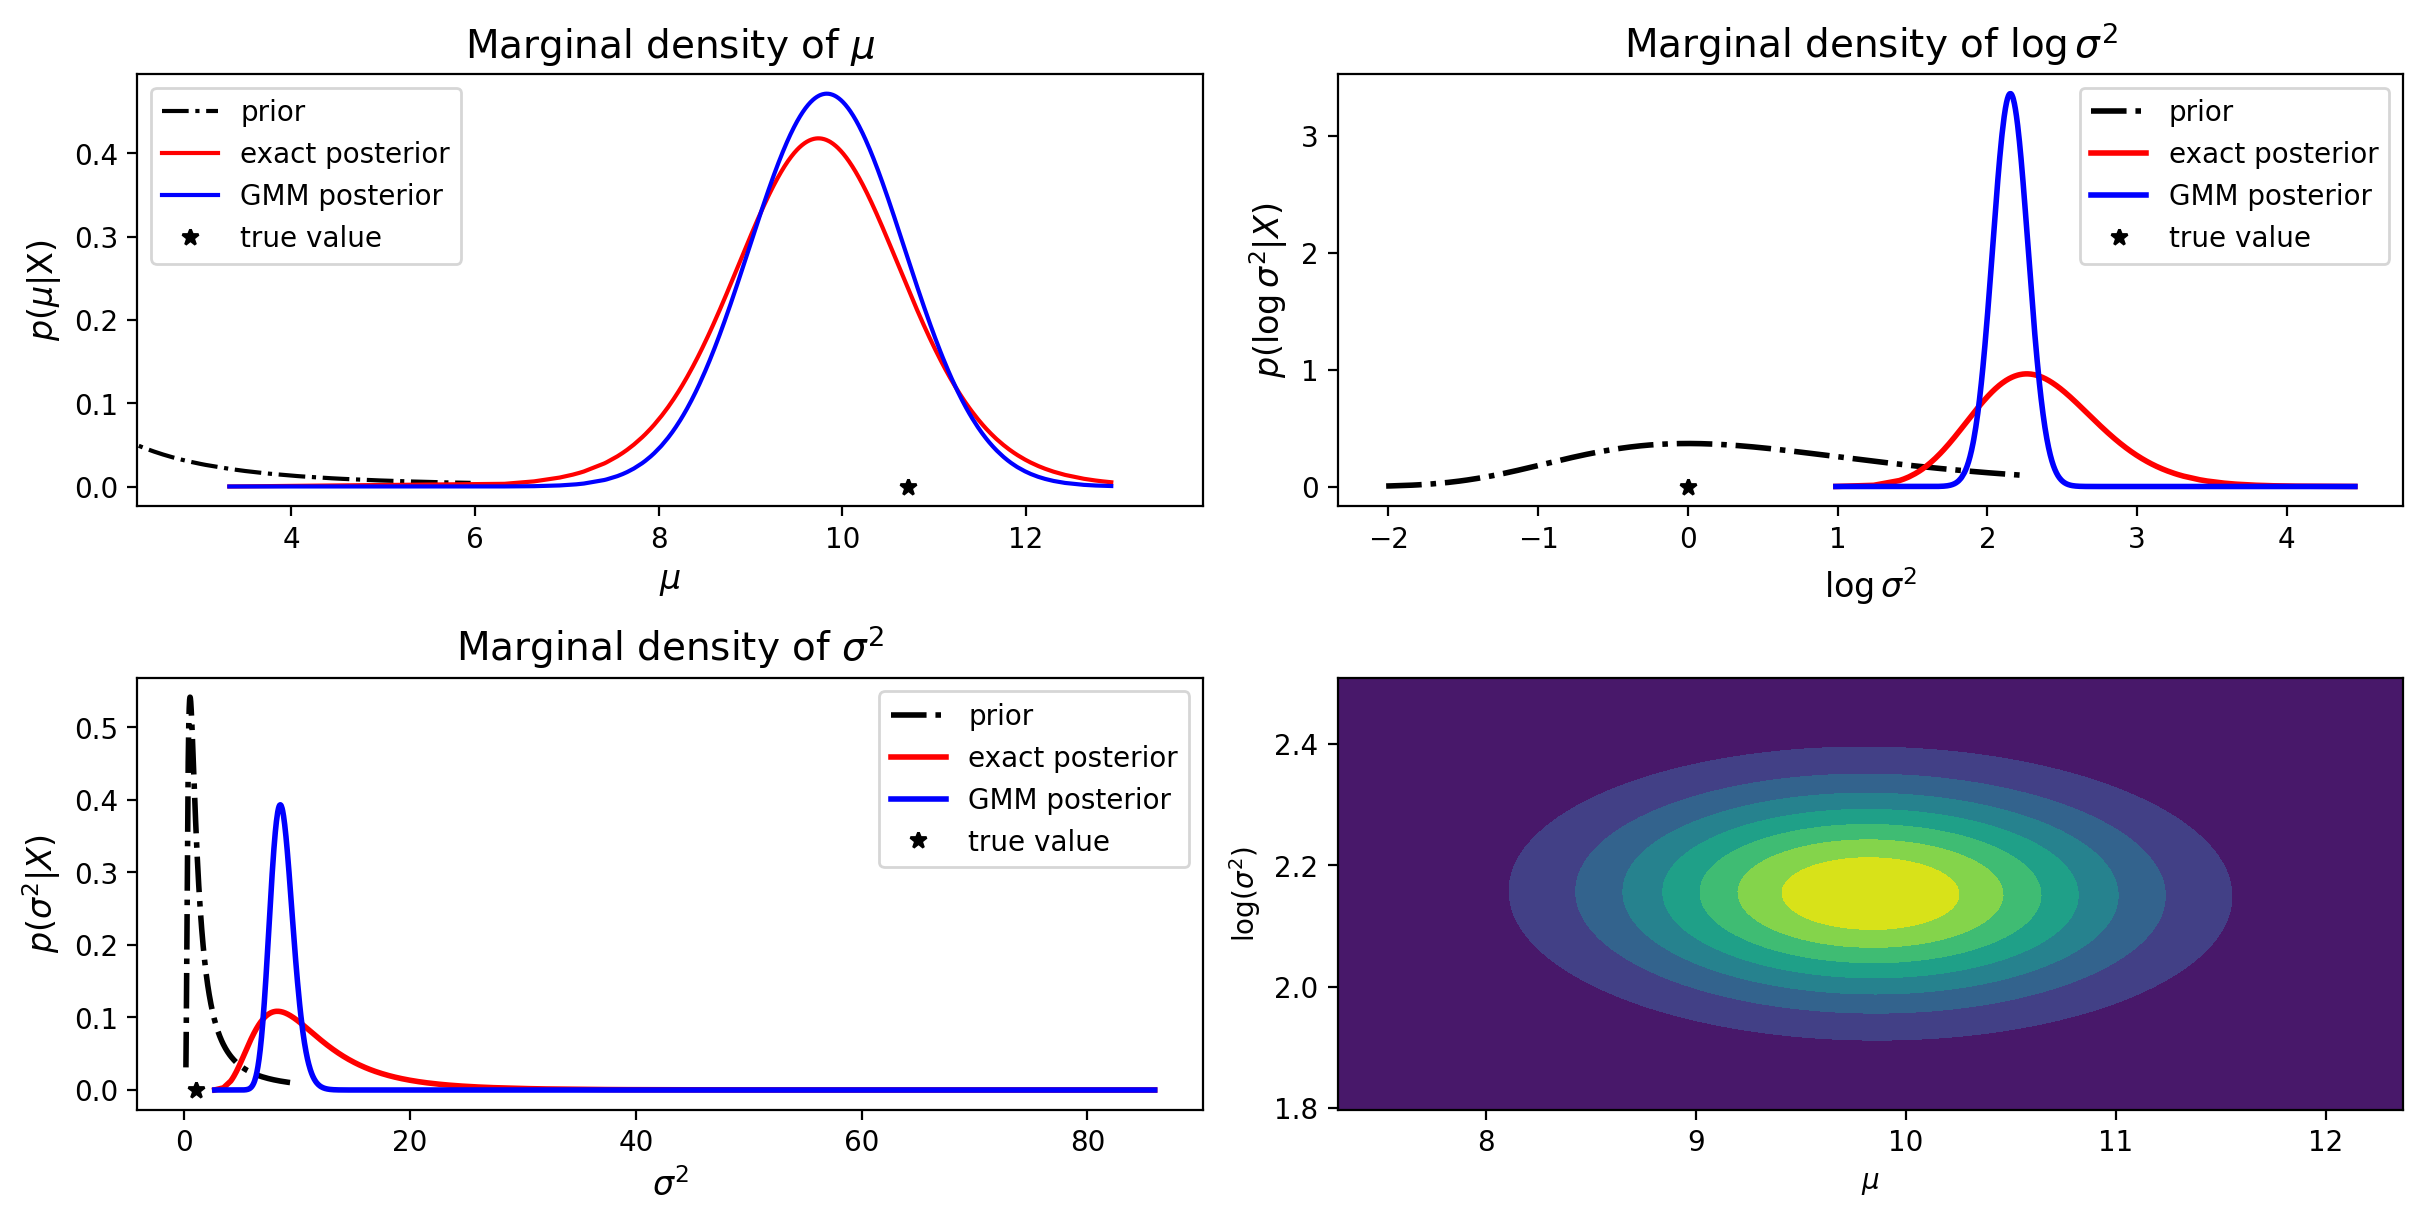

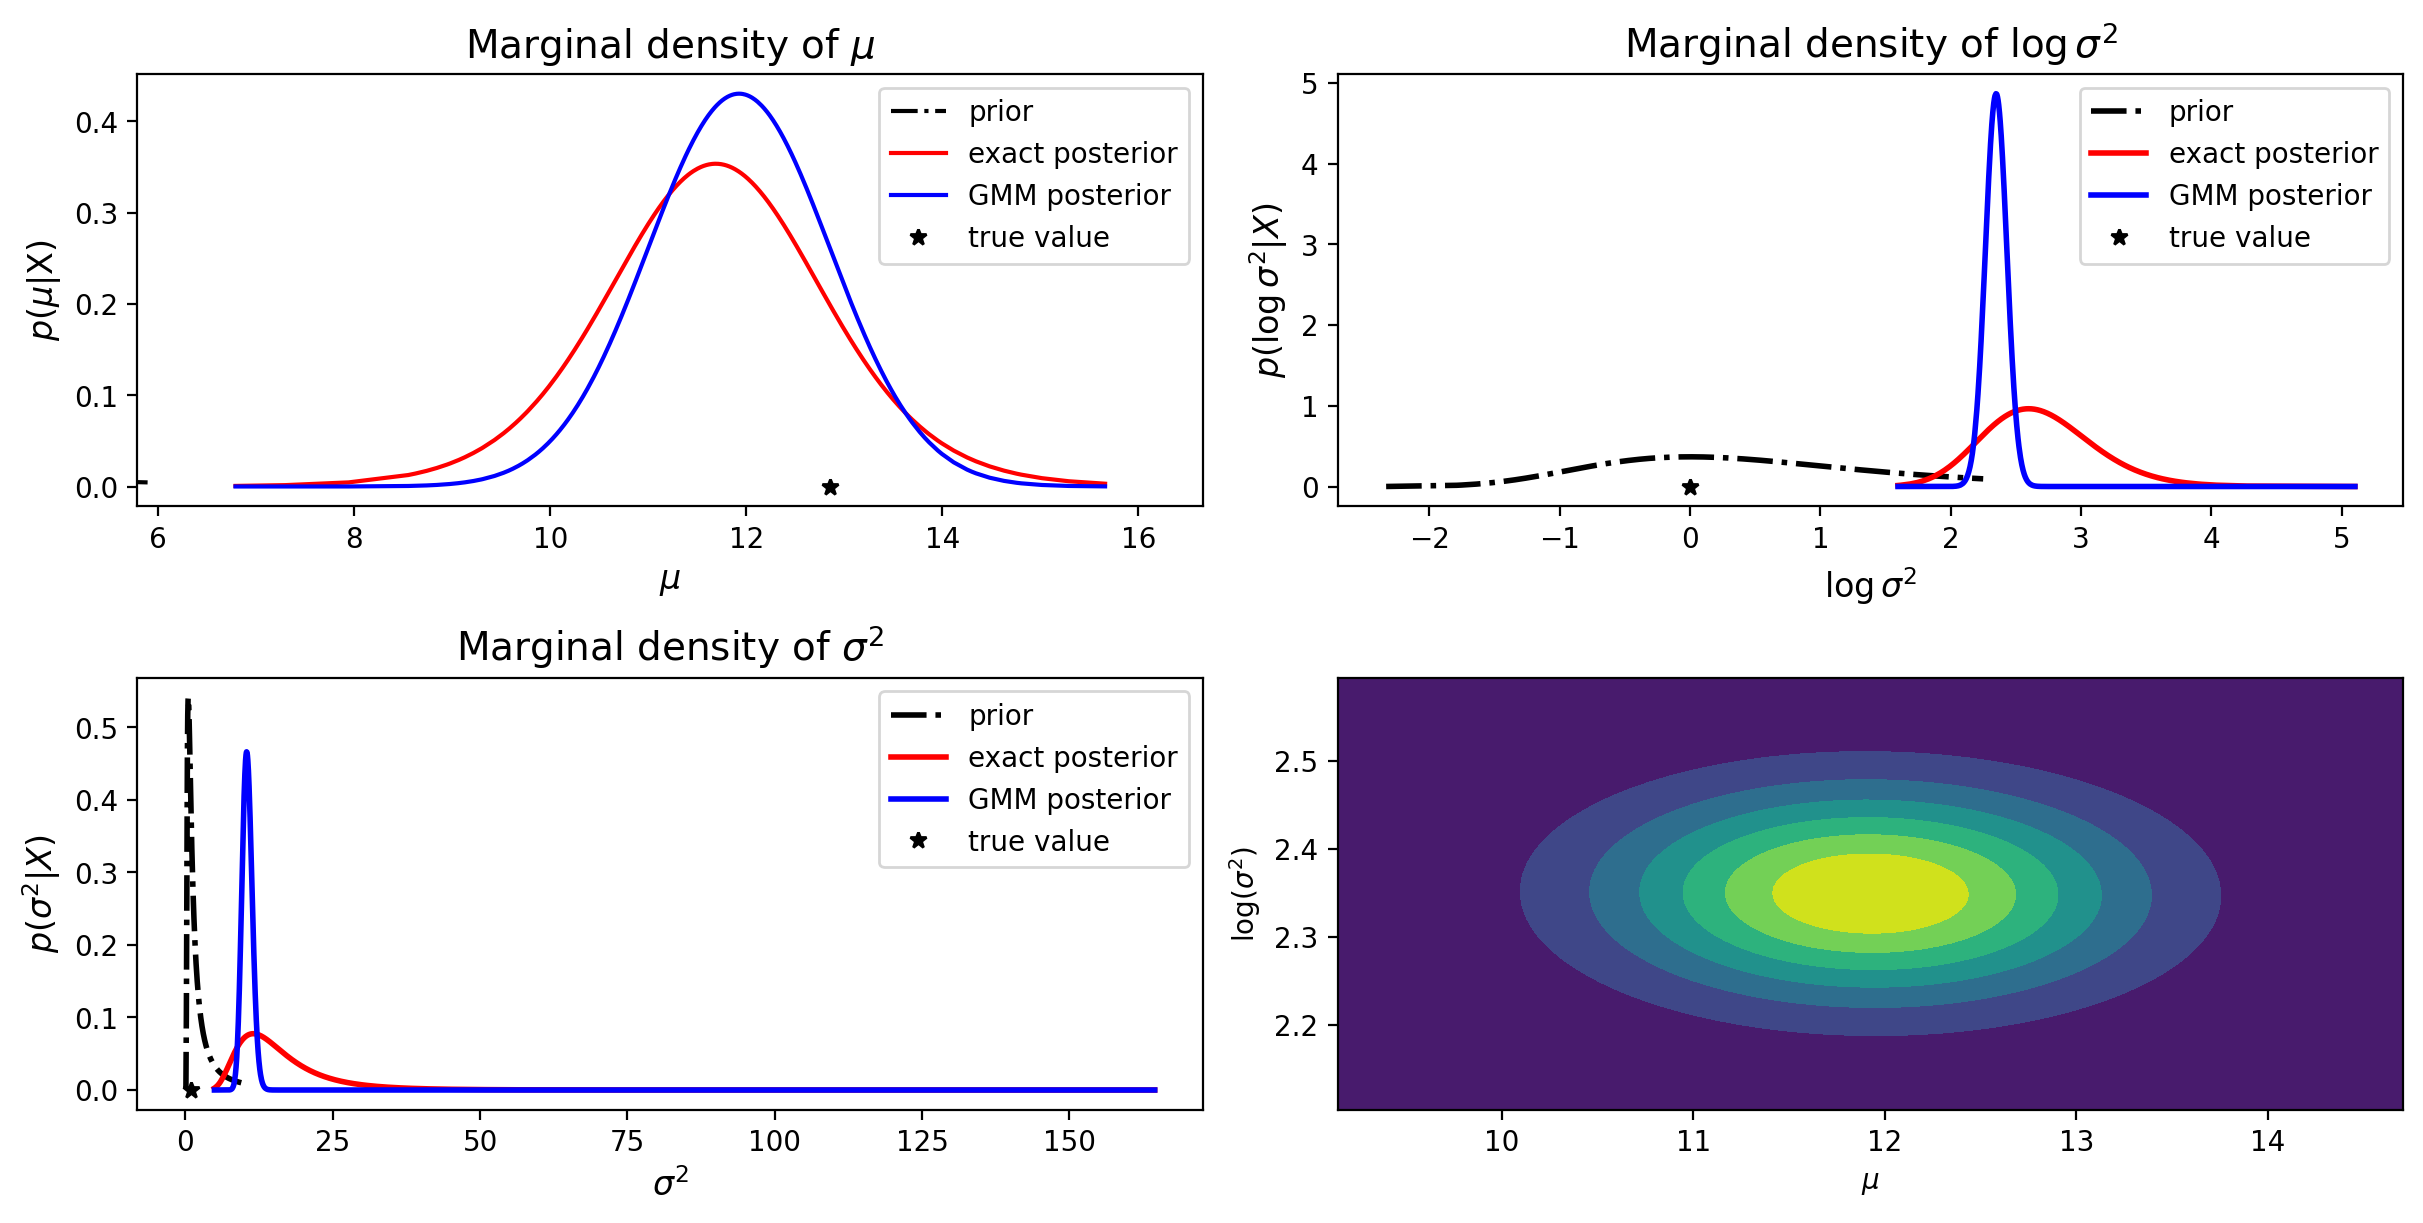

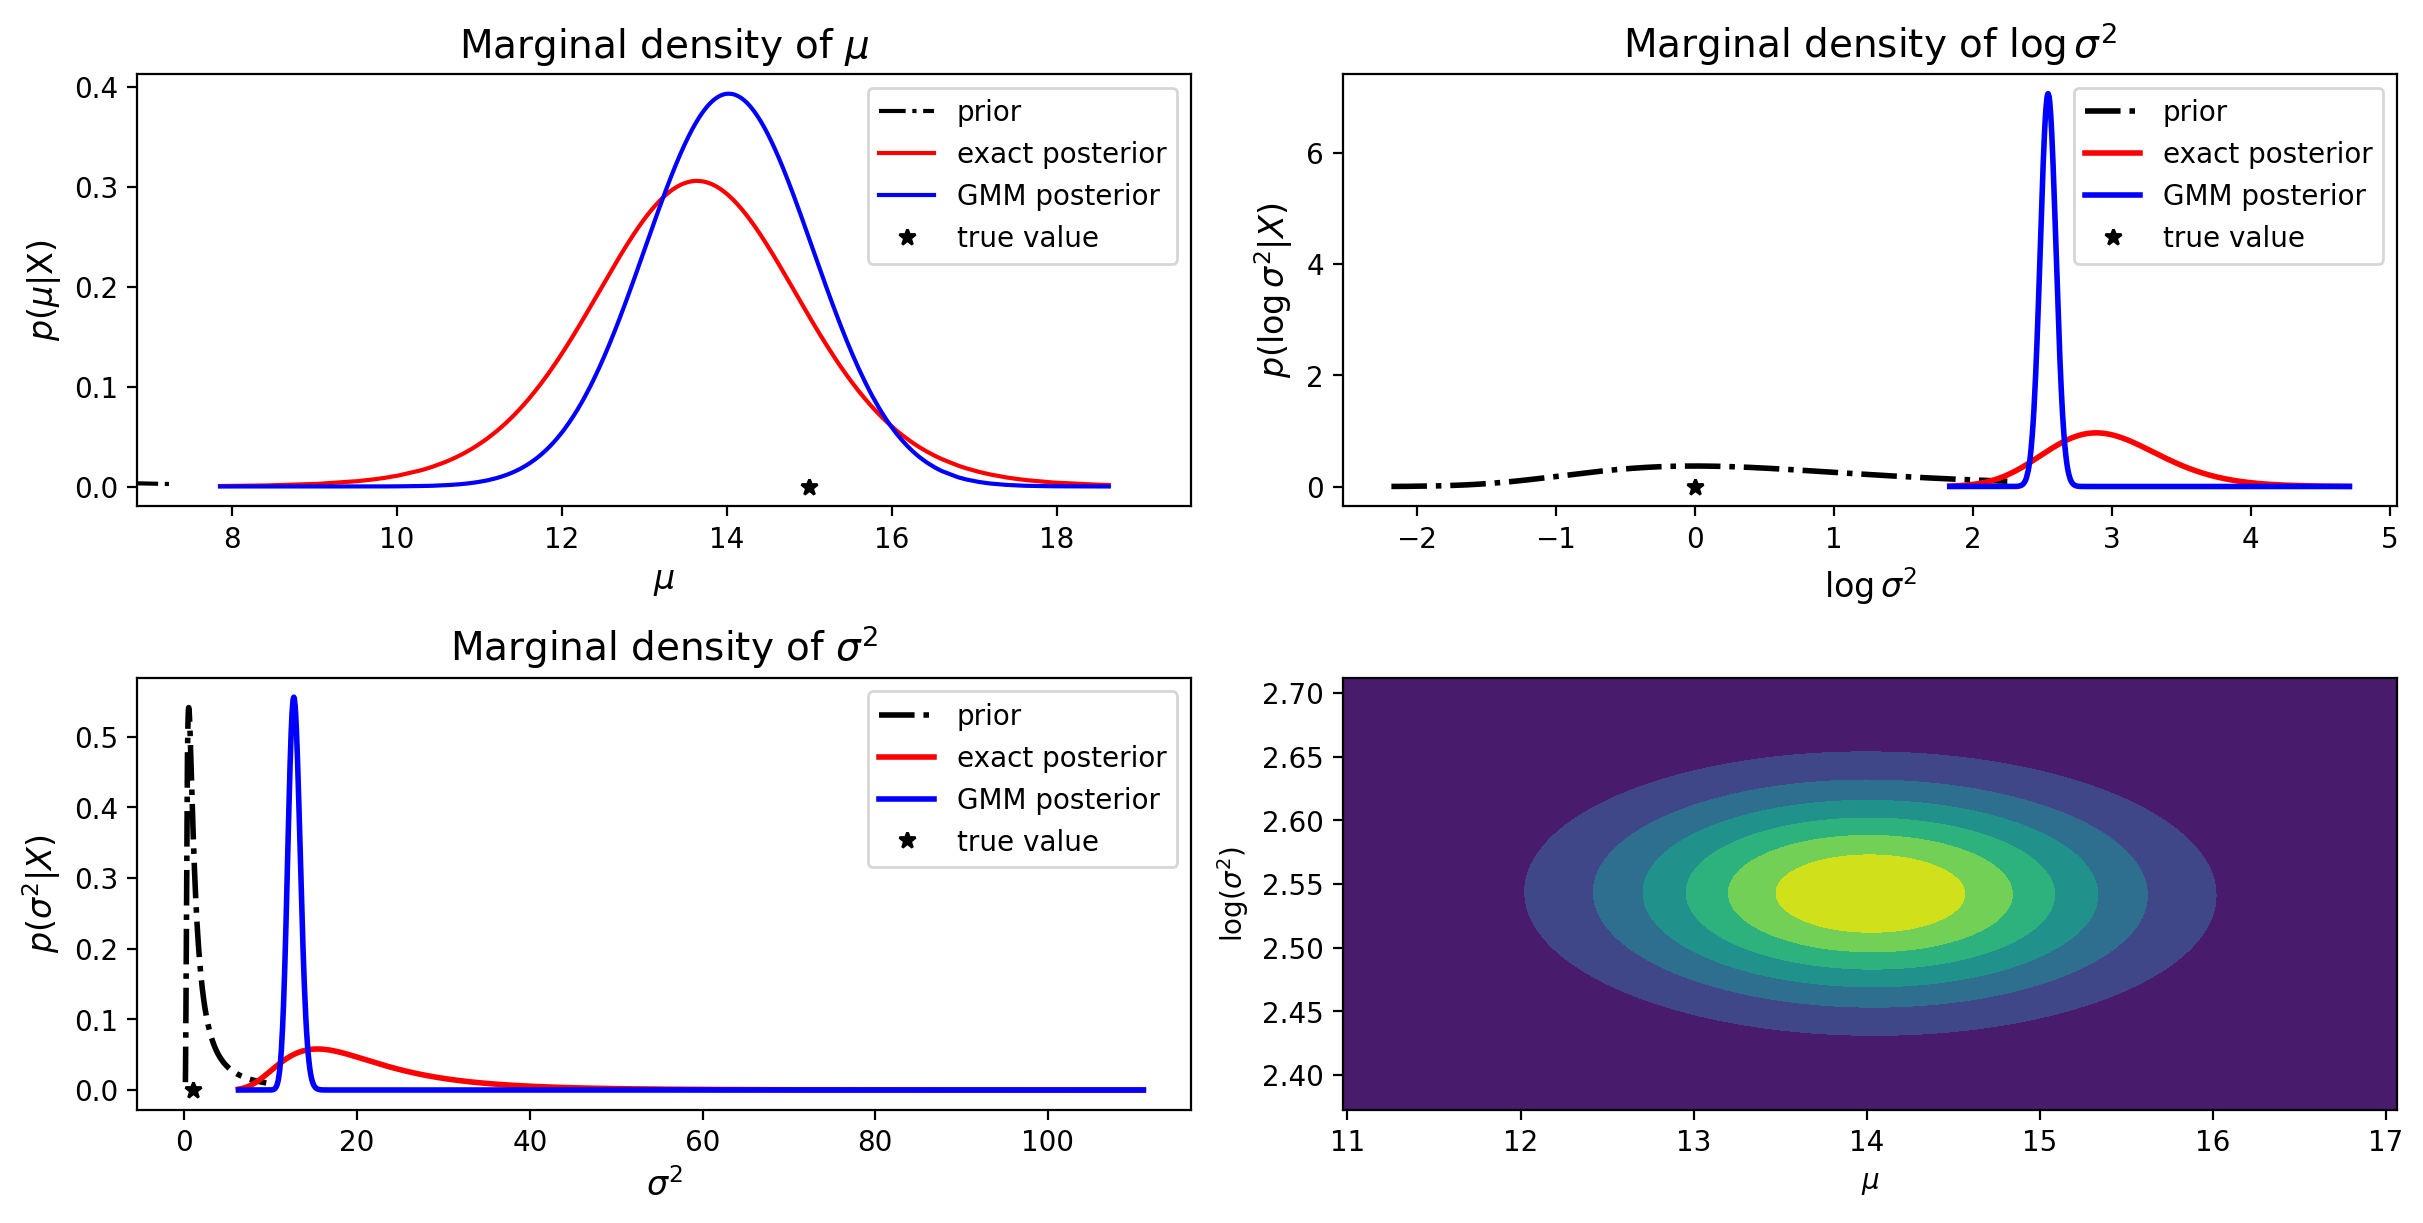

In [62]:
gaussian_model = torch_dist.normal.Normal(loc=0.0, scale=1.0)
epsilon = gaussian_model.sample((n,))
epsilon = (epsilon - epsilon.mean(dim=0)) / epsilon.std(dim=0)
 
mean = np.linspace(-15.0, 15.0, 15)

for k in range(15):
    theta_0 = torch.tensor([mean[k], 0.0])
    Y = theta_0[0] + sqrt(torch.exp(theta_0[1])) * epsilon
    compare_marginals_gaussian(model=gmm_nd, x=Y, theta=theta_0, alpha=α, beta=β, mu_0=μ_0, kappa=κ,
                            prior_only=False, posterior_only=False, upper=0.9)
 

## Adding permutation invariance

In [4]:
from sbi.neural_nets.embedding_nets import (
    FCEmbedding,
    PermutationInvariantEmbedding,
)

# embedding
latent_dim = 10
single_trial_net = FCEmbedding(
    input_dim=1,
    num_hiddens=40,
    num_layers=2,
    output_dim=latent_dim,
)
embedding_net = PermutationInvariantEmbedding(
    single_trial_net,
    trial_net_output_dim=latent_dim,
    # NOTE: post-embedding is not needed really.
    num_layers=1,
    num_hiddens=10,
    output_dim=10,
    aggregation_dim=1
)

class GMMNet(nn.Module):
    def __init__(self, input_size, posterior_dimension=1, p=0.2, embedding_net=None, latent_dim=None):
        super().__init__()
        '''
        define neural network archictecture for computing the mean and Cholesky factor of the
        approximate posterior density of theta. If the posterior is d-dimensional, then the neural net
        has a d * (d + 3) / 2 output space, where the first d entries are for the mean, and the remaining
        d*(d + 1)/2 dimensions are for the Cholesky factor of the precision matrix, with only its non-zero
        elements being calculated
        '''
        d = posterior_dimension
        if latent_dim and embedding_net:
            input_size = latent_dim

        self.hidden = nn.Sequential(          # hidden layers
            nn.Linear(input_size, 64),
            nn.ELU(),
            nn.Dropout(p=p),
            nn.Linear(64, 64),
            nn.ELU(),
            nn.Linear(64, 64),
            nn.ELU(),
            nn.Linear(64, 32),
            nn.ELU()
        )

        self.mean = nn.Linear(32, d)    # GMM posterior mean
                 
        self.cholesky_precision = nn.Linear(32, int(d * (d + 1) / 2))     # Cholesky factor of the precision matrix (log for diagonal entries)       
    
    def forward(self, x):
        if embedding_net:
            x = embedding_net(x.unsqueeze(dim=2))
        x = self.hidden(x)
        theta_mean = self.mean(x)
        theta_precision = self.cholesky_precision(x)
        
        return theta_mean, theta_precision
    

In [5]:
#Explicitly provided seeds for training process
random_seed = 12345 # recommend to find optimal value for you solution
torch.manual_seed(random_seed)

cuda = torch.cuda.is_available()
if cuda:
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

# sample training data
n = 10                   # sample size
α = 1.0                  # prior mean
β = 1.0                  # prior standard deviation
μ_0 = 0.0                 
κ = 1.0
dim = 2
N = 20000
data_loader = train_gmm_nd(alpha=α, beta=β, mu_0=μ_0, kappa=κ,
                            sample_size=n, N=N, truncated=True,
                            upper=0.9, batch_size=30, num_shuffle=1)


## instantiate DNN model
gmm_invariant = GMMNet(input_size=n,
                     posterior_dimension=dim, 
                     p=0.0,
                     embedding_net=embedding_net.to(device),
                     latent_dim=latent_dim).to(device)
loss_fn = GMMnDLoss(dim=dim, lambda_reg=1.)

# # train DNN model
# gmm_invariant = nn_optimizer(model=gmm_invariant, 
#                        data_loader=data_loader,
#                        loss_fn=loss_fn,
#                        learning_rate=1e-4, 
#                        sd_noise=1e-4,
#                        num_epochs=100,
#                        verbose=True,
#                        echo_after=1,
#                        path='trained_models/gmm/gaussian_mean_logvariance_truncated_invariant_1.pt'
#                       )

gmm_invariant = torch.load('trained_models/gmm/gaussian_mean_logvariance_truncated_invariant_1.pt')

In [12]:
print(gmm_invariant(X.to(device))[0])
print(gmm_nd(X.to(device))[0])
print(theta)

tensor([[-0.3149, -0.4734],
        [-5.4407, -0.2059],
        [ 0.8700, -0.2214],
        [ 0.0969, -0.1817],
        [-0.8943, -1.1850]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 0.4210,  1.4595],
        [-2.0908,  1.5063],
        [ 2.6011,  1.7767],
        [ 0.3478, -0.7404],
        [-1.0966, -0.3716]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 0.8913,  1.3409],
        [-3.0612,  1.5525],
        [ 2.6036,  2.0766],
        [-0.1987, -0.0973],
        [-1.0811, -0.2719]])


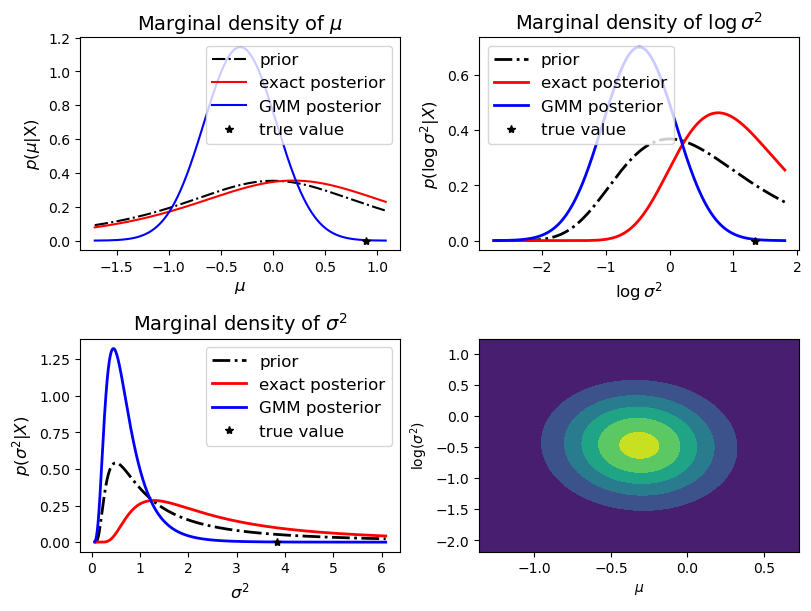

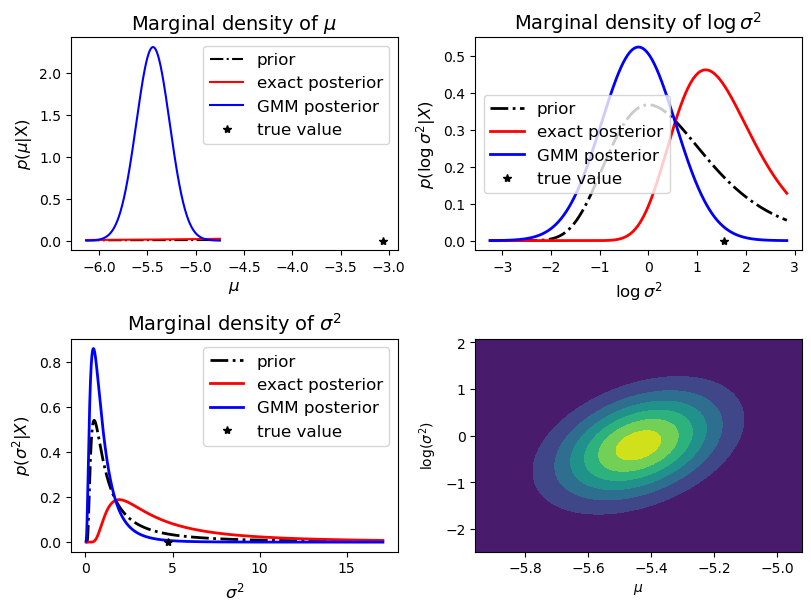

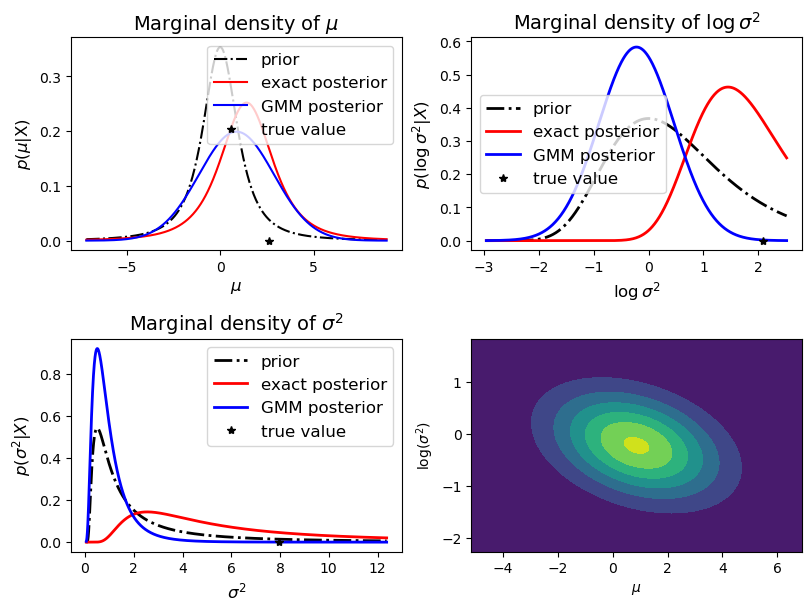

In [6]:
### testing on a single example
X, theta = train_gmm_nd(alpha=α, beta=β, mu_0=μ_0, kappa=κ,
                        sample_size=n, N=5, truncated=True,
                        upper=0.9, lower=0.1, test=True)
for i in range(3):
    compare_marginals_gaussian(model=gmm_invariant, x=X[i].unsqueeze(dim=0),
                                theta=theta[i, :], alpha=α, beta=β, mu_0=μ_0, kappa=κ)

## Multi-component, d-dimensional GMM Loss function

#### Neural network architecture

In [ ]:
class GMMnet(nn.Module):
    def __init__(self, input_size, dim=1, K=1,  p=0.0):
        super().__init__()
        '''
        define neural network archictecture for computing the mean and Cholesky factor of the
        approximate posterior density of theta. If the posterior is d-dimensional, then the neural net
        has a d * (d + 3) / 2 output space, where the first d entries are for the mean, and the remaining
        d*(d + 1)/2 dimensions are for the Cholesky factor of the precision matrix, with only its non-zero
        elements being calculated
        '''
        self.dim = dim                          # dimension of the posterior space
        self.K = K                              # number of independents Gaussian components

        self.hidden = nn.Sequential(            # hidden layers
            nn.Linear(input_size, 64),
            nn.ELU(),
            nn.Linear(64, 128),
            nn.ELU(),
            nn.Linear(128, 128),
            nn.ELU(),
            nn.Linear(128, 128),
            nn.ELU()
        )
        self.dropout = nn.Dropout(p=p)
        self.mean = nn.Sequential(              # approximate posterior mean
            nn.Linear(128, self.K * self.dim)

        )       
        self.cholesky_precision = nn.Sequential(     # Cholesky factor of the precision matrix (log for diagonal entries)
            nn.Linear(128, self.K * int(0.5 * self.dim * (self.dim + 1)))
        ) 
        self.mixing_weights = nn.Sequential(
            nn.Linear(128, self.K),
            nn.Softmax(dim=1)
        )       
    
    def forward(self, x):
        n = x.shape[0]                      # number of training examples/batch size
        x = self.hidden(x)
        #x = self.dropout(x)
        gmm_mean = self.mean(x).reshape((n, self.K, self.dim))
        gmm_precision = self.cholesky_precision(x).reshape((n, self.K, int(0.5 * self.dim * (self.dim + 1))))
        gmm_coeffs = self.mixing_weights(x)
        return gmm_mean, gmm_precision, gmm_coeffs


#### Experiment 1: Gaussian with unknown mean and variance

In [ ]:
#Explicitly provided seeds for training process
random_seed = 1234 # recommend to find optimal value for you solution
torch.manual_seed(random_seed)

cuda = torch.cuda.is_available()
if cuda:
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

# sample training data
n = 10                   # sample size
α = 3.0                  # prior mean
β = 3.0                  # prior standard deviation
μ_0 = 2.0                 
κ = .2
dim = 2
K = 5
N = 10000
data_loader, params = train_gmm_nd(α=α, β=β,
                                μ_0=μ_0,κ=κ,
                                sample_size=n,
                                N=N, batch_size=30)


## instantiate DNN model
gmm_net = GMMnet(input_size=n,
                     dim=dim, K=K).to(device)
loss_fn = GMMLoss(dim=dim, K=K)

# train DNN model
gmm_net = nn_optimizer(model=gmm_net, 
                       data_loader=data_loader,
                       loss_fn=loss_fn,
                       learning_rate=1e-5, 
                       K=K,
                       sd_noise=1e-5,
                       num_epochs=401,
                       verbose=True,
                       echo_after=10,
                       path='trained_models/gmm/gaussian_mean_logvariance_2.pt'
                      )

#gmm_nd = torch.load('trained_models/gmm/gaussian_mean_logvariance.pt')

In [ ]:
X, theta = train_gmm_nd(α=α, β=β,
                                μ_0=μ_0,κ=κ,
                                sample_size=n,
                                N=20, test='True')
theta = theta.to(device)

gmm_net = GMMnet(input_size=n,
                     dim=2, K=4).to(device)
loss_fn = GMMLoss(dim=2, K=4)

with torch.no_grad():
        gmm_mean, gmm_precision, gmm_coeffs = gmm_net(X.to(device))